# Srilanka Dengue Outbreak Forecasting using Darts

## Environment Setup

In [1]:
!pip install darts
!pip install dask[dataframe]
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 9.5 MB/s eta 0:00:00
  Crea

## 1. Imports

In [2]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from darts import TimeSeries

%matplotlib inline

## 2. Load Dataset

In [3]:
df = pd.read_csv("/kaggle/input/srilanka/Copy of Sri_lanka_dengue_cases_weather_weekly_2007_2024_.csv")

In [4]:
df.head()

Unnamed: 0 District  Number_of_Cases Week_Start_Date  Month  Year  Week  \
0           0   Ampara                0      2007-01-01      1  2007     1   
1           1   Ampara                0      2007-01-08      1  2007     2   
2           2   Ampara                0      2007-01-15      1  2007     3   
3           3   Ampara                0      2007-01-22      1  2007     4   
4           4   Ampara                0      2007-01-29      1  2007     5   

  Week_End_Date  Avg Max Temp (°C)  Avg Min Temp (°C)  \
0    2007-01-08            26.9375            21.8625   
1    2007-01-15            26.3500            23.3250   
2    2007-01-22            27.2125            23.1625   
3    2007-01-29            26.7250            23.0375   
4    2007-02-05            27.3625            22.9625   

   Avg Apparent Max Temp (°C)  Avg Apparent Min Temp (°C)  \
0                     28.8500                     24.1000   
1                     30.2625                     26.7000   
2                     29.5750                     25.9625   
3                     29.9500                     26.1125   
4                     30.7500                     26.1250   

   Total Precipitation (mm)  Total Rain (mm)  Avg Wind Speed (km/h)  \
0                       8.0              8.0                18.2000   
1                      86.1             86.1                17.0250   
2                       3.1              3.1                20.1875   
3                      53.6             53.6                17.2000   
4                       8.2              8.2                17.2625   

   Max Wind Gusts (km/h)  Weather Code  Avg Daylight Duration (hours)  \
0                   44.3             3                      11.714583   
1                   43.6            53                      11.733333   
2                   48.2            51                      11.754167   
3                   42.5            61                      11.783333   
4                   40.0            51                      11.812500   

   Avg Sunrise Time  Avg Sunset Time  
0               376             1079  
1               378             1082  
2               380             1085  
3               381             1088  
4               382             1090

In [5]:
df = df.drop(columns = ["Unnamed: 0"])

In [6]:
len(df)

22900

In [7]:
districts = df['District'].unique()
districts

array(['Ampara', 'Anuradhapura', 'Badulla', 'Batticaloa', 'Colombo',
       'Galle', 'Gampaha', 'Hambantota', 'Jaffna', 'Kalutara', 'Kandy',
       'Kegalle', 'Kilinochchi', 'Kurunegala', 'Mannar', 'Matale',
       'Matara', 'Monaragala', 'Mullaitivu', 'NuwaraEliya', 'Polonnaruwa',
       'Puttalam', 'Ratnapura', 'Trincomalee', 'Vavuniya'], dtype=object)

## 3. Small Visualization

In [8]:
# Check Duplicate values
duplicates = df[['District', 'Week_Start_Date', 'Week_End_Date']].duplicated().any()
if duplicates:
    print("There are duplicate values.")
else:
    print("No duplicates found.")

No duplicates found.


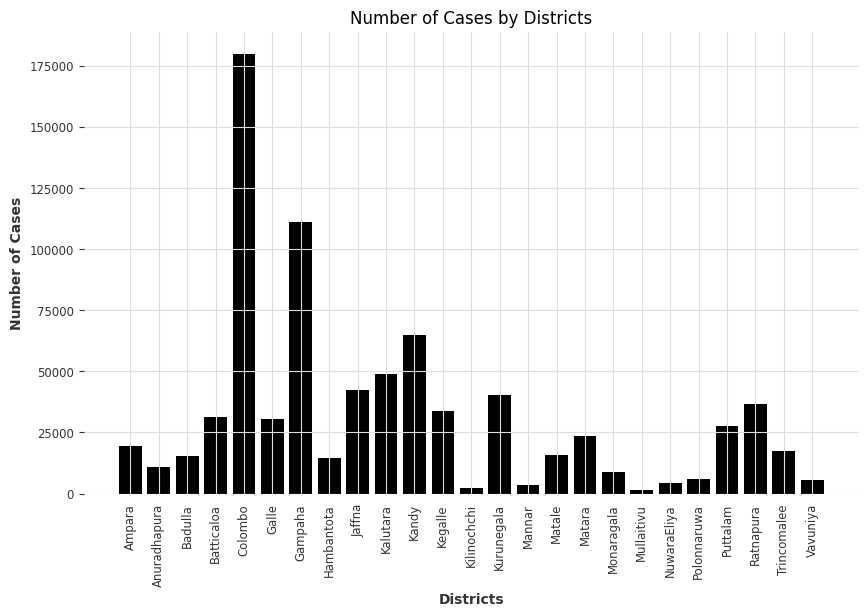

In [9]:
# Group by District and sum the Number of Cases
district_cases = df.groupby('District')['Number_of_Cases'].sum().reset_index()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(district_cases['District'], district_cases['Number_of_Cases'])
plt.xlabel('Districts')
plt.ylabel('Number of Cases')
plt.title('Number of Cases by Districts')
plt.xticks(rotation=90)
plt.show()


## 4. Minor pre-processing
1. Only taking single timestamp for each row. Either `Week_Start_Date` or `Week_Start_Date`. We gonna take `Week_End_Date`.
2. Convert the `Week_End_Date` to Python Datetime format.
3. Eliminate un-used features such as `Week_Start_Date`, `Month`, `Year`, and `Week`

In [10]:
df['Week_End_Date'] = pd.to_datetime(df['Week_End_Date'])

In [11]:
df.head()

District  Number_of_Cases Week_Start_Date  Month  Year  Week Week_End_Date  \
0   Ampara                0      2007-01-01      1  2007     1    2007-01-08   
1   Ampara                0      2007-01-08      1  2007     2    2007-01-15   
2   Ampara                0      2007-01-15      1  2007     3    2007-01-22   
3   Ampara                0      2007-01-22      1  2007     4    2007-01-29   
4   Ampara                0      2007-01-29      1  2007     5    2007-02-05   

   Avg Max Temp (°C)  Avg Min Temp (°C)  Avg Apparent Max Temp (°C)  \
0            26.9375            21.8625                     28.8500   
1            26.3500            23.3250                     30.2625   
2            27.2125            23.1625                     29.5750   
3            26.7250            23.0375                     29.9500   
4            27.3625            22.9625                     30.7500   

   Avg Apparent Min Temp (°C)  Total Precipitation (mm)  Total Rain (mm)  \
0                     24.1000                       8.0              8.0   
1                     26.7000                      86.1             86.1   
2                     25.9625                       3.1              3.1   
3                     26.1125                      53.6             53.6   
4                     26.1250                       8.2              8.2   

   Avg Wind Speed (km/h)  Max Wind Gusts (km/h)  Weather Code  \
0                18.2000                   44.3             3   
1                17.0250                   43.6            53   
2                20.1875                   48.2            51   
3                17.2000                   42.5            61   
4                17.2625                   40.0            51   

   Avg Daylight Duration (hours)  Avg Sunrise Time  Avg Sunset Time  
0                      11.714583               376             1079  
1                      11.733333               378             1082  
2                      11.754167               380             1085  
3                      11.783333               381             1088  
4                      11.812500               382             1090

** The trend of cases of all 25 districts

In [12]:
import plotly.express as px

# List of all districts
districts = df['District'].unique()

for district in districts:
    # Filter data for the current district
    df_district = df[df['District'] == district]

    # Create an interactive line plot using Plotly without markers
    fig = px.line(
        df_district,
        x="Week_End_Date",
        y="Number_of_Cases",
        title=f"Number of Cases Over Time - {district}",
        labels={'Week_End_Date': 'Week End Date', 'Number_of_Cases': 'Number of Cases'}
    )

    # Customize the layout for a bigger and clearer plot
    fig.update_layout(
        width=1000,  # Width of the figure
        height=600,  # Height of the figure
        title_font_size=18,
        xaxis_title_font_size=14,
        yaxis_title_font_size=14,
        hovermode="x"  # Show hover data for the x-axis
    )

    # Show the interactive plot with zoom and pan features
    fig.show()


## 5. Modelling
List of deep learning models.
- NBEATSModel
- TCNModel
- TransformerModel
- TFTModel
- TSMixerModel

There are other models as well to check go here:
https://unit8co.github.io/darts/generated_api/darts.models.forecasting.html

In [13]:
from darts.models import RNNModel, NBEATSModel, TCNModel, TransformerModel, TFTModel, TSMixerModel
from darts.metrics import rmse, mae, smape, r2_score, rmsle
import plotly.graph_objects as go

In [14]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

pl_trainer_kwargs={"accelerator": "gpu"}

In [15]:
nbeats = NBEATSModel(                 # or 'GRU' or 'RNN'
    input_chunk_length=52,           # length of input sequence
    output_chunk_length=12,
    dropout=0.4,                     # dropout to avoid overfitting
    batch_size=32,                   # batch size during training
    n_epochs=100,                    # number of epochs for training
    activation='LeakyReLU',
    random_state=42,
    pl_trainer_kwargs=pl_trainer_kwargs
)
tcn = TCNModel(
    input_chunk_length=52,           # length of input sequence
    output_chunk_length=12,              # number of RNN layers
    dropout=0.4,                     # dropout to avoid overfitting
    batch_size=32,                   # batch size during training
    n_epochs=100,                    # number of epochs for training
    random_state=42,
    pl_trainer_kwargs=pl_trainer_kwargs
)
transformer = TransformerModel(
    input_chunk_length=52,           # length of input sequence
    output_chunk_length=12,
    norm_type="LayerNorm",
    dropout=0.4,                     # dropout to avoid overfitting
    batch_size=32,                   # batch size during training
    n_epochs=100,                    # number of epochs for training
    random_state=42,
    pl_trainer_kwargs=pl_trainer_kwargs
)
tft = TFTModel(
    input_chunk_length=52,           # length of input sequence
    output_chunk_length=12,
    dropout=0.4,                     # dropout to avoid overfitting
    batch_size=32,                   # batch size during training
    n_epochs=100,                    # number of epochs for training
    random_state=42,
    pl_trainer_kwargs=pl_trainer_kwargs,
    add_relative_index=True
)
tsmixer = TSMixerModel(
    input_chunk_length=52,           # length of input sequence
    output_chunk_length=12,
    dropout=0.4,                     # dropout to avoid overfitting
    batch_size=32,                   # batch size during training
    norm_type="LayerNorm",
    activation='LeakyReLU',
    n_epochs=100,                    # number of epochs for training
    random_state=42,
    pl_trainer_kwargs=pl_trainer_kwargs
)

In [16]:
models = [nbeats, tcn, transformer, tft, tsmixer]

In [17]:
def save_model(model, model_name, district_name, folder='saved_models'):
    # Create directory if it doesn't exist
    os.makedirs(folder, exist_ok=True)

    # Define the model file path
    model_file = os.path.join(folder, f'{district_name}_{model_name}')
    model.save(model_file)

    print(f"Model saved for {district_name}: {model_file}")

In [18]:
def train_and_forecast(train_series, test_series, model, district_name):
    model.fit(train_series)

    model_folder = f"/kaggle/working/{district_name}"
    # Save Model
    save_model(model, type(model).__name__, model_folder)

    # Forecast for the next 12 weeks
    forecast = model.predict(n=len(test_series))

    # Plot the results
    plt.figure(figsize=(12, 6))
    train_series.plot(label='Historical Data')
    test_series.plot(label='Validation Data', color='orange')
    forecast.plot(label='Forecast', color='green')
    plt.legend()
    plt.title(f"Forecast vs Validation for {district_name}")
    plt.show()

    # Calculate metrics
    val_values = test_series.values()
    forecast_values = forecast.values()

    # Ensure the forecast and validation values are the same length
    assert len(val_values) == len(forecast_values), "Forecast and validation series must have the same length for metrics calculation."

    # Compute metrics
    error_rmse = rmse(test_series, forecast)
    error_mae = mae(test_series, forecast)
    error_smape = smape(test_series, forecast)
    error_r2 = r2_score(test_series, forecast)
    error_rmsle = rmsle(test_series, forecast)

    errors = {
        "RMSE": error_rmse,
        "MAE": error_mae,
        "SMAPE": error_smape,
        "R2": error_r2,
        "RMSLE": error_rmsle
    }
    results = [forecast, errors]
    return results

In [19]:
def main(data, models):
    districts = data['District'].unique()
    final_output = []
    for district in districts:
      # Filter data for the specified district
      district_data = data[data['District'] == district]

      # Ensure the 'Week_End_Date' column is in datetime format
      district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])

      # Prepare the data for ARIMA
      series = TimeSeries.from_dataframe(district_data, time_col='Week_End_Date', value_cols=['Number_of_Cases'])

      # Split series
      # Set aside the last 12 weeks as a validation series
      train_data, val_data = series[:-12], series[-12:]

      print(f"Training length: {len(train_data)}")
      print(f"Validation length: {len(val_data)}")
      district_output = []
      for m in models:
        result = train_and_forecast(train_data, val_data, m, district)
        district_output.append(result)

      final_output.append(district_output)

    return final_output


/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training length: 904
Validation length: 12


Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Ampara: /kaggle/working/Ampara_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

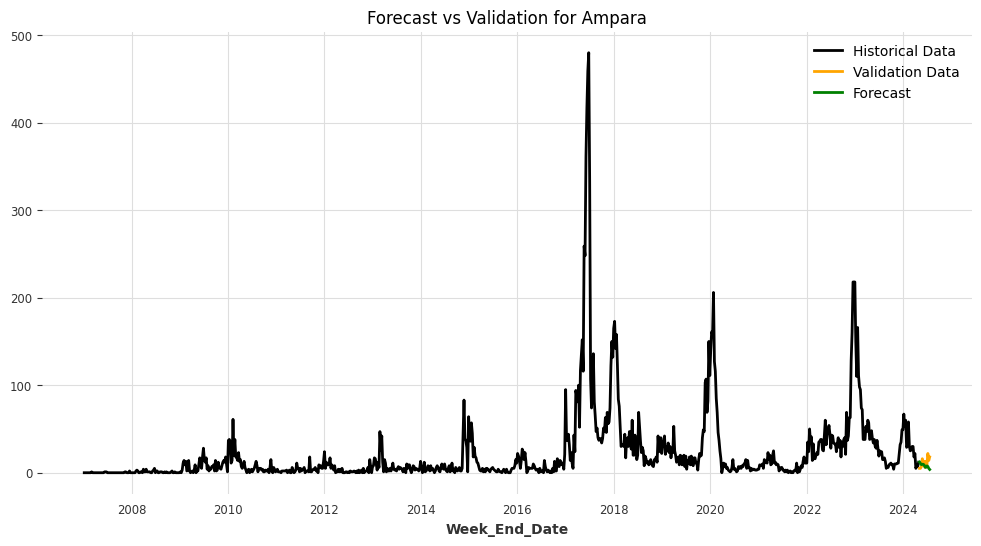

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Ampara: /kaggle/working/Ampara_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

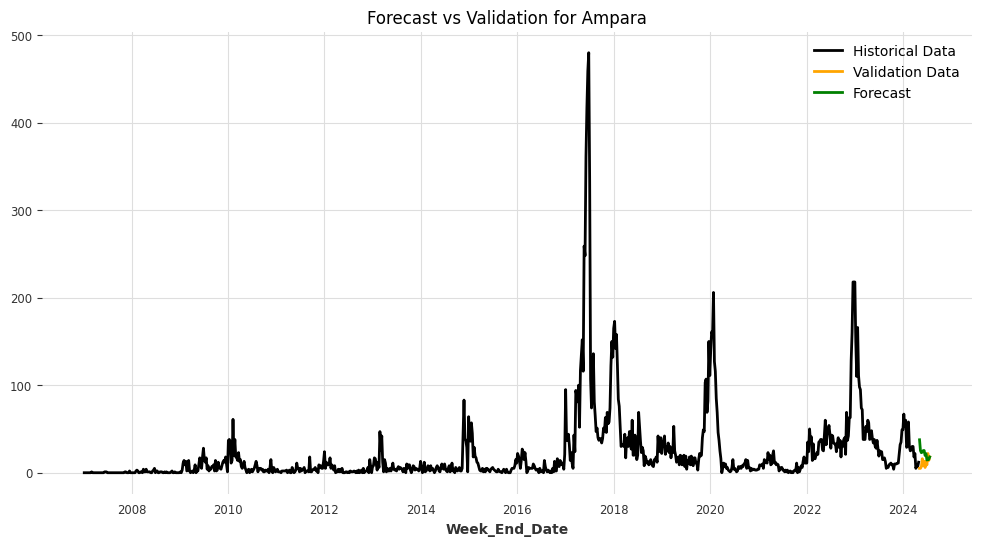

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Ampara: /kaggle/working/Ampara_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

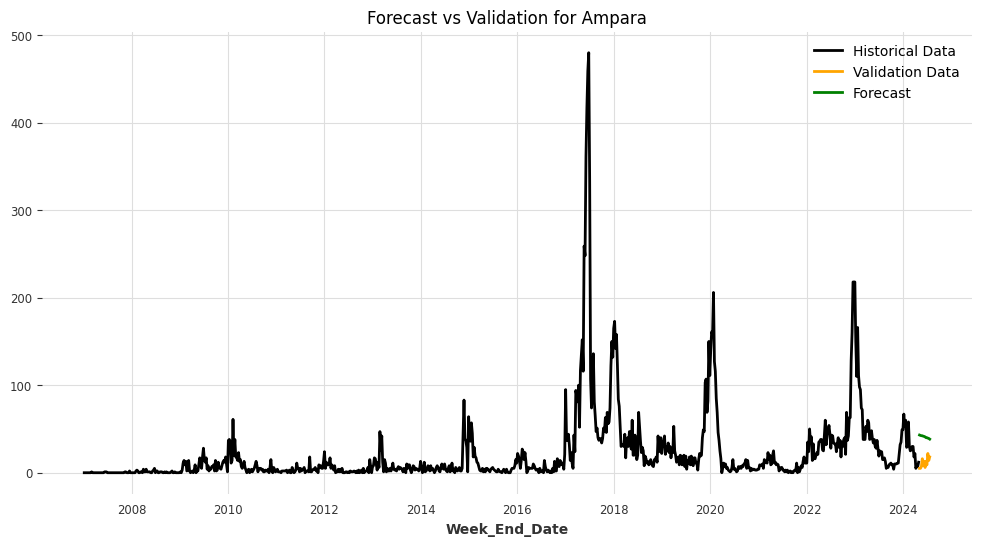

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Ampara: /kaggle/working/Ampara_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

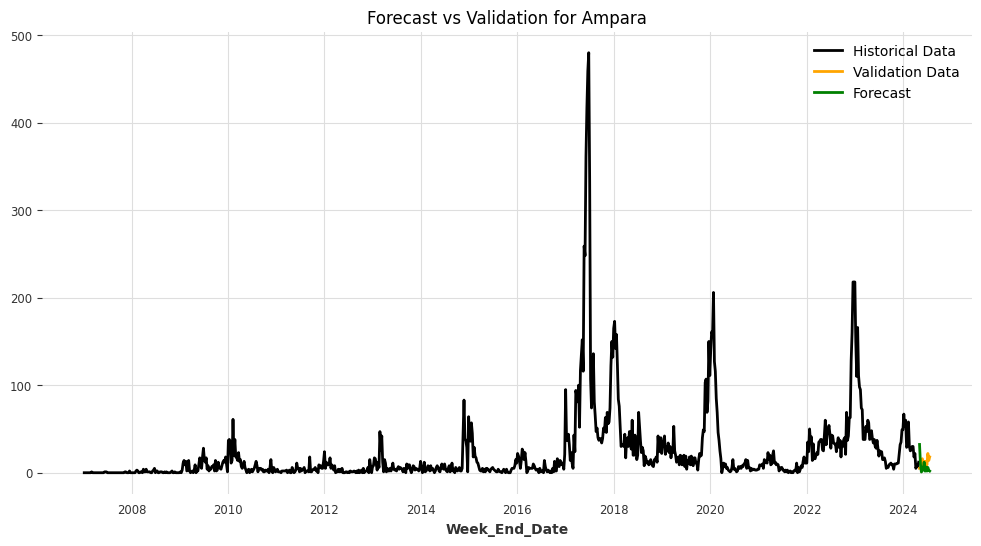

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Ampara: /kaggle/working/Ampara_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

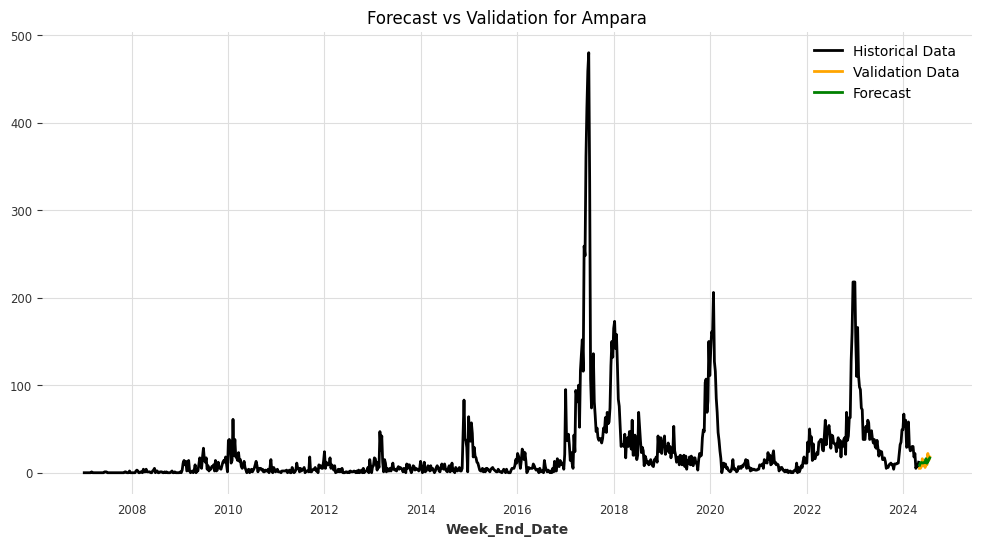

Training length: 904
Validation length: 12


/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Anuradhapura: /kaggle/working/Anuradhapura_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

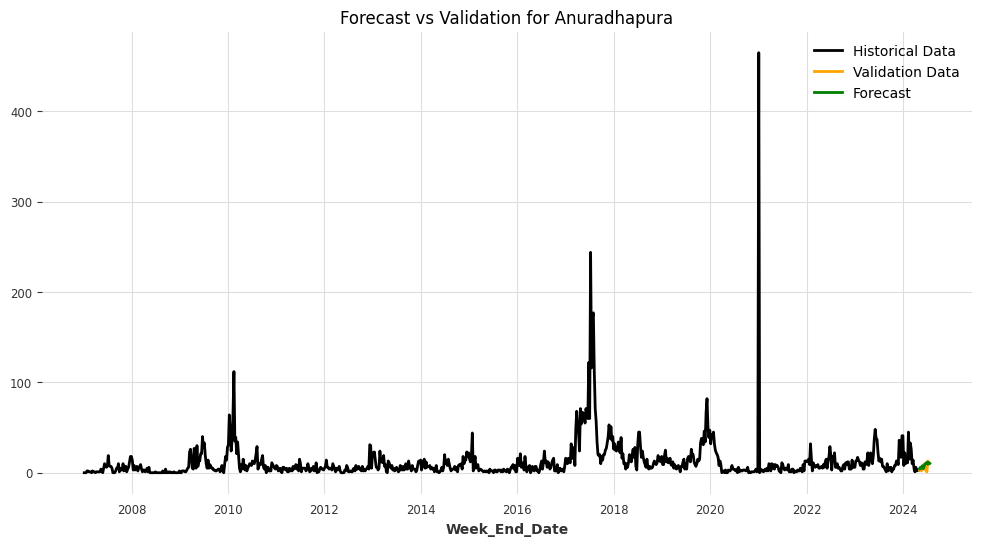

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Anuradhapura: /kaggle/working/Anuradhapura_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

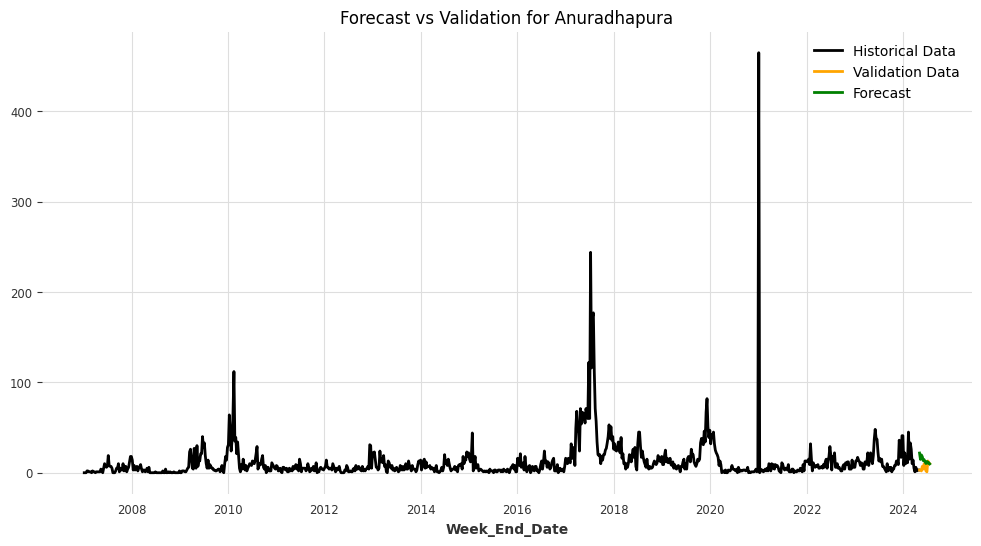

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Anuradhapura: /kaggle/working/Anuradhapura_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

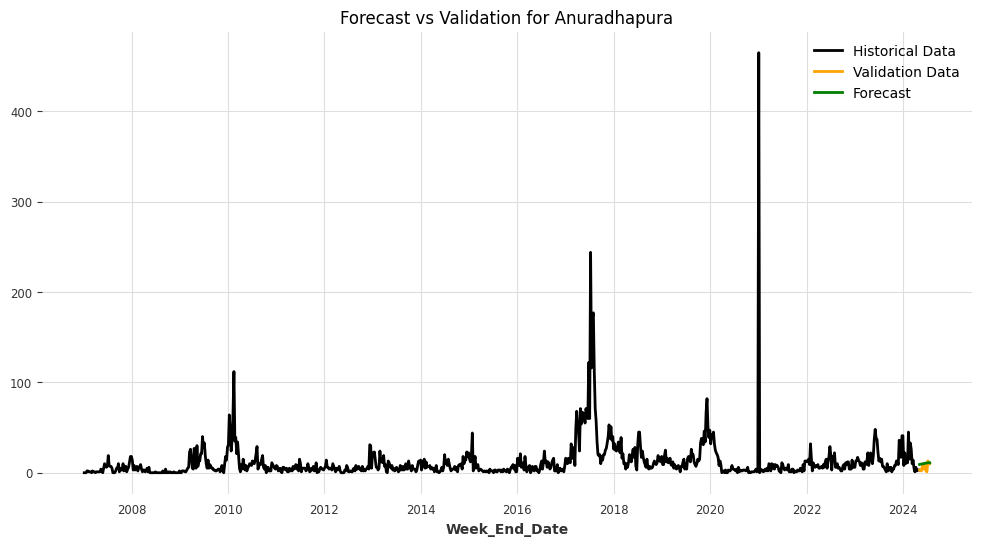

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Anuradhapura: /kaggle/working/Anuradhapura_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

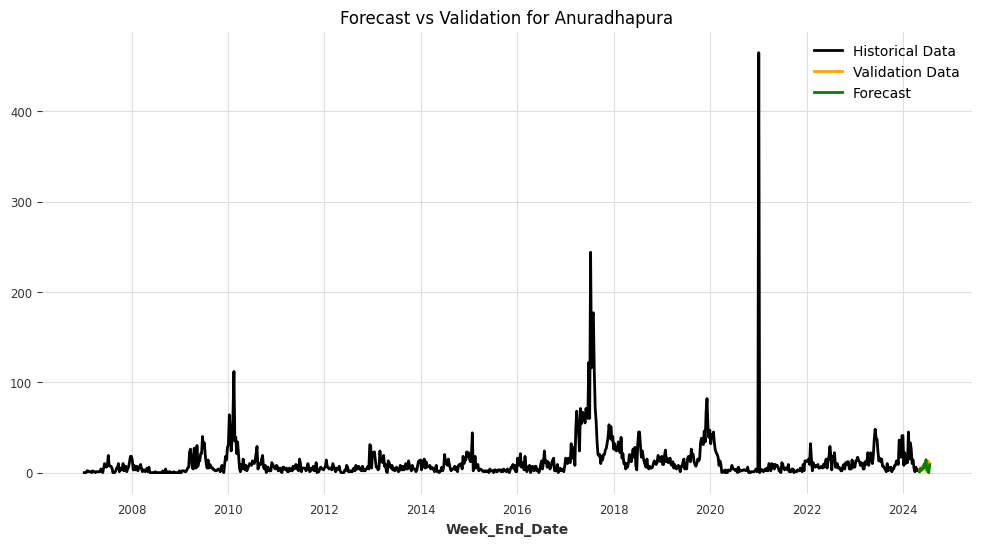

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Anuradhapura: /kaggle/working/Anuradhapura_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

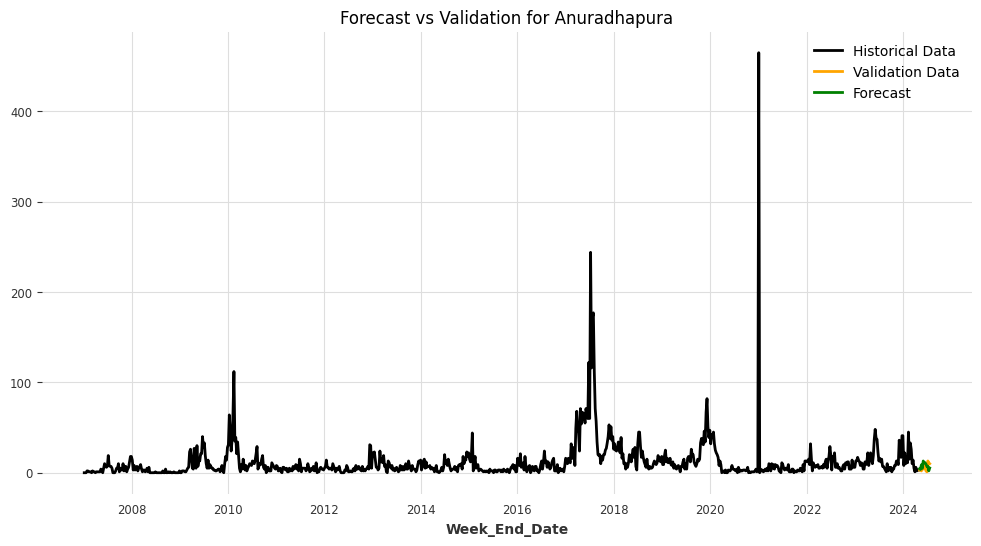

Training length: 904
Validation length: 12


/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Badulla: /kaggle/working/Badulla_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

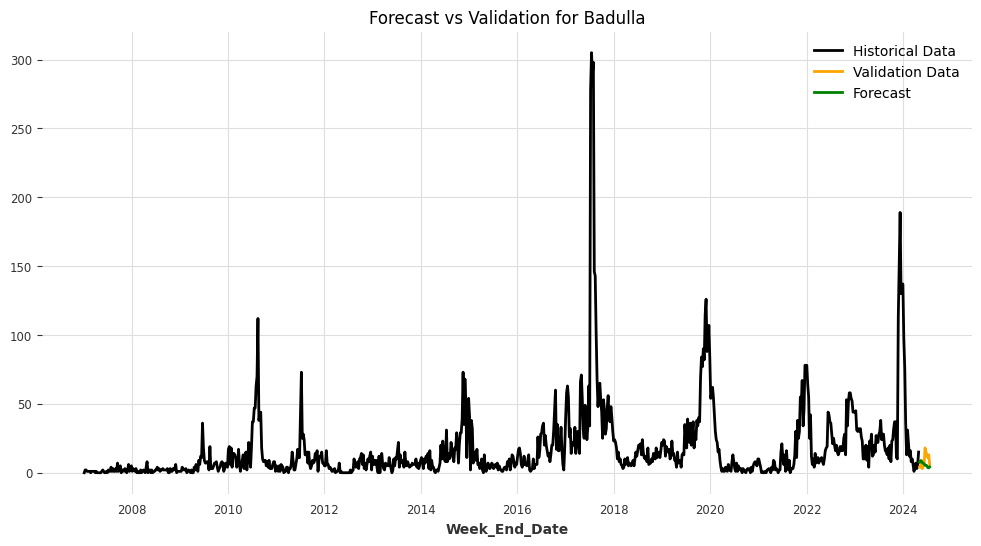

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Badulla: /kaggle/working/Badulla_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

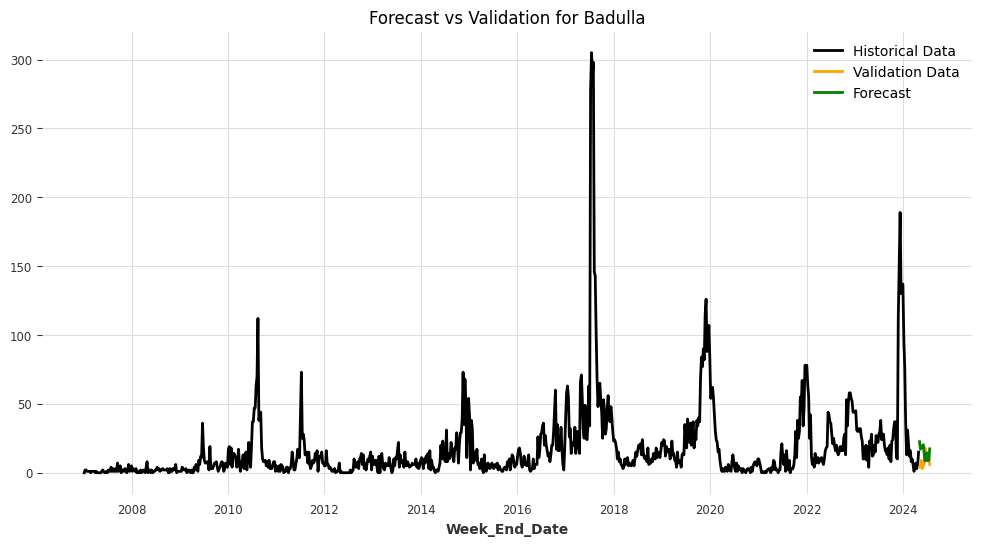

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Badulla: /kaggle/working/Badulla_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

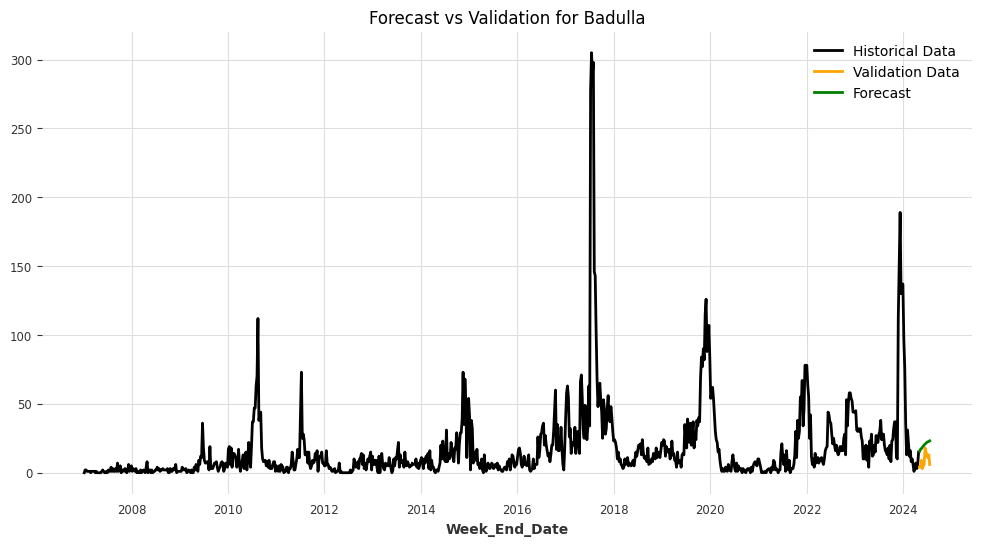

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Badulla: /kaggle/working/Badulla_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

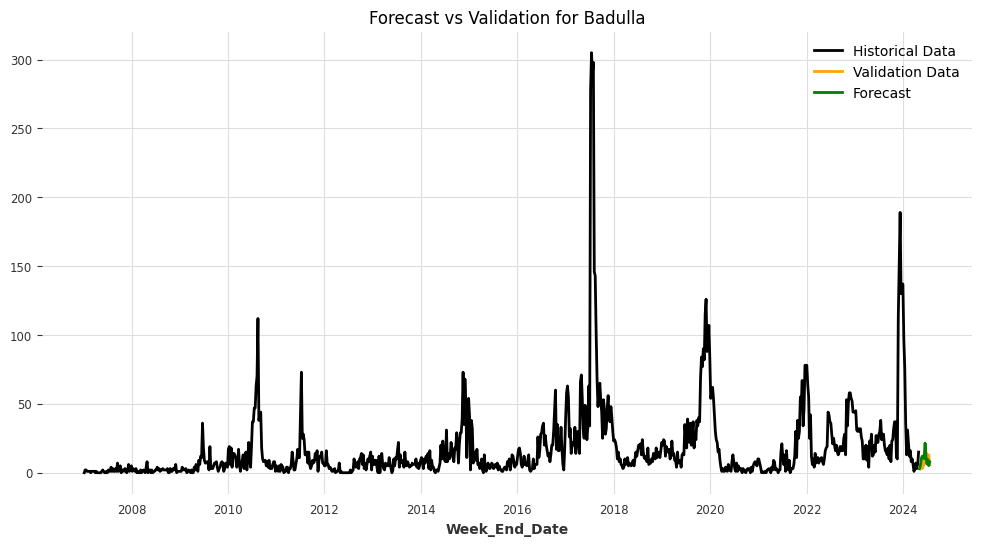

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Badulla: /kaggle/working/Badulla_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

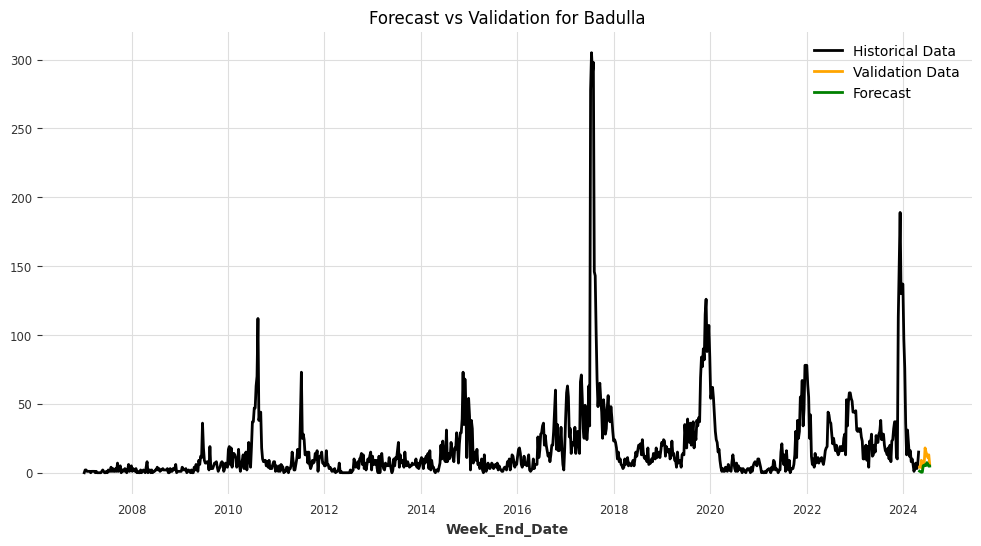

Training length: 904
Validation length: 12


/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Batticaloa: /kaggle/working/Batticaloa_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

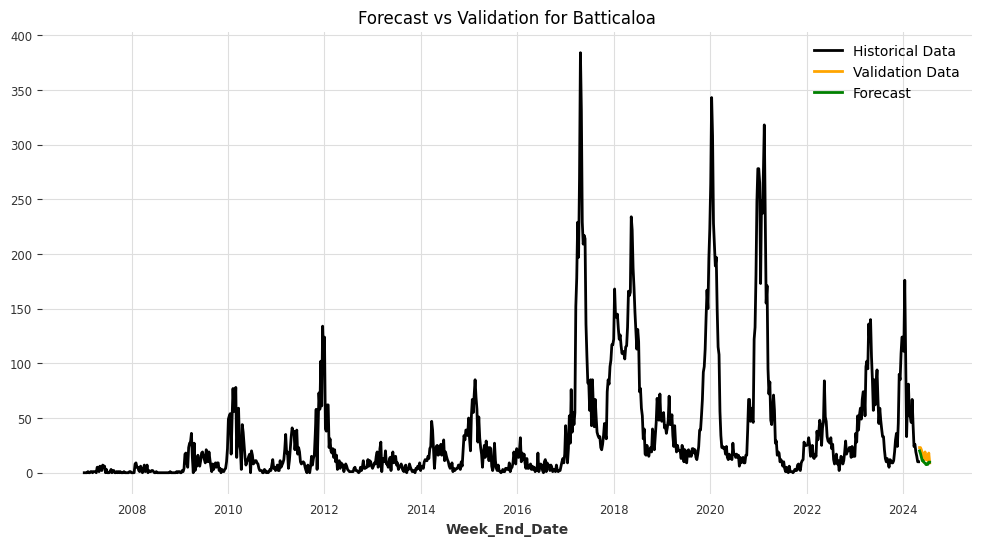

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Batticaloa: /kaggle/working/Batticaloa_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

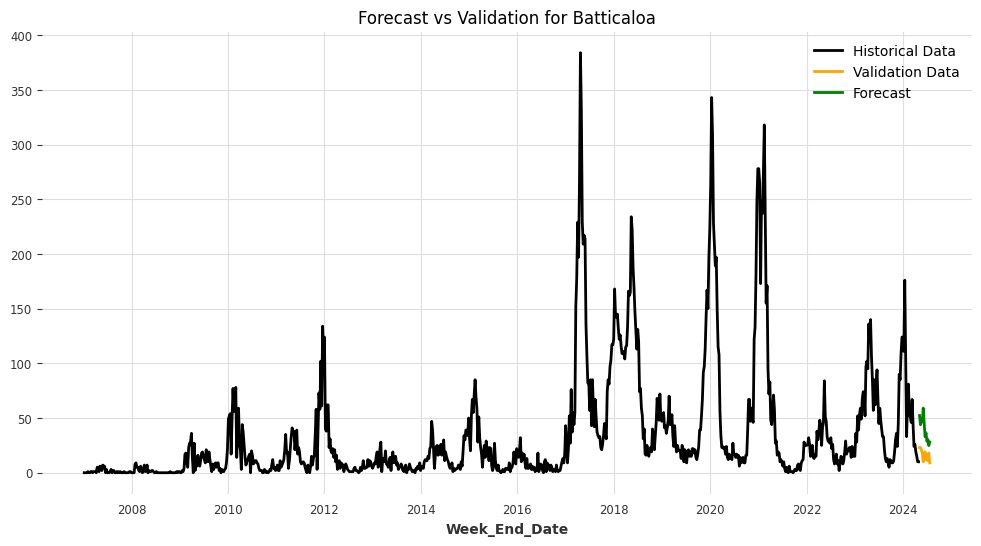

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Batticaloa: /kaggle/working/Batticaloa_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

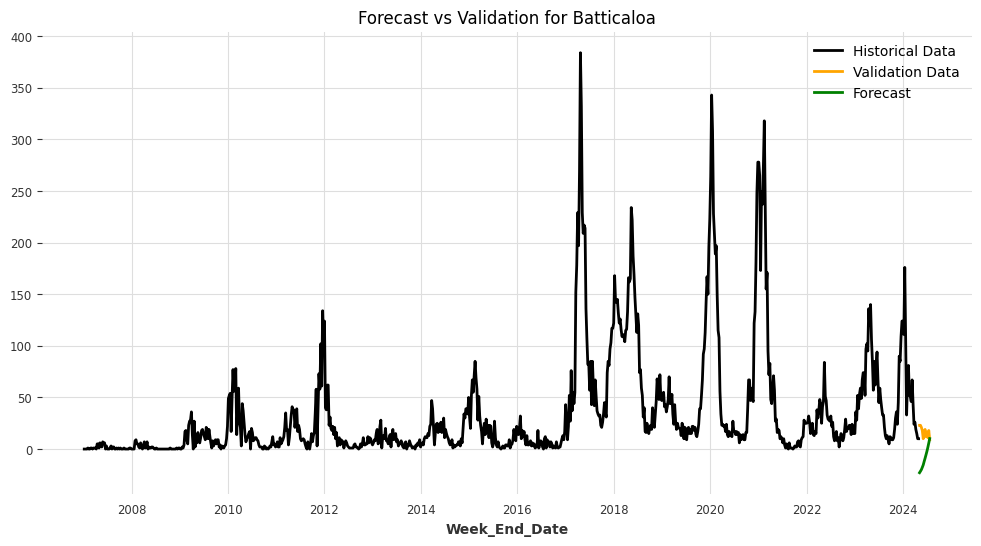

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Batticaloa: /kaggle/working/Batticaloa_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

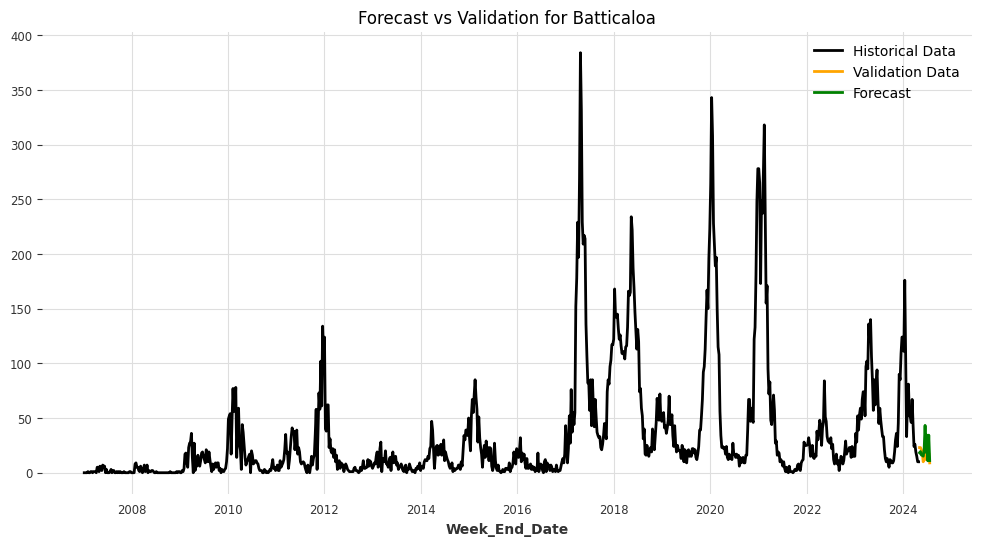

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Batticaloa: /kaggle/working/Batticaloa_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

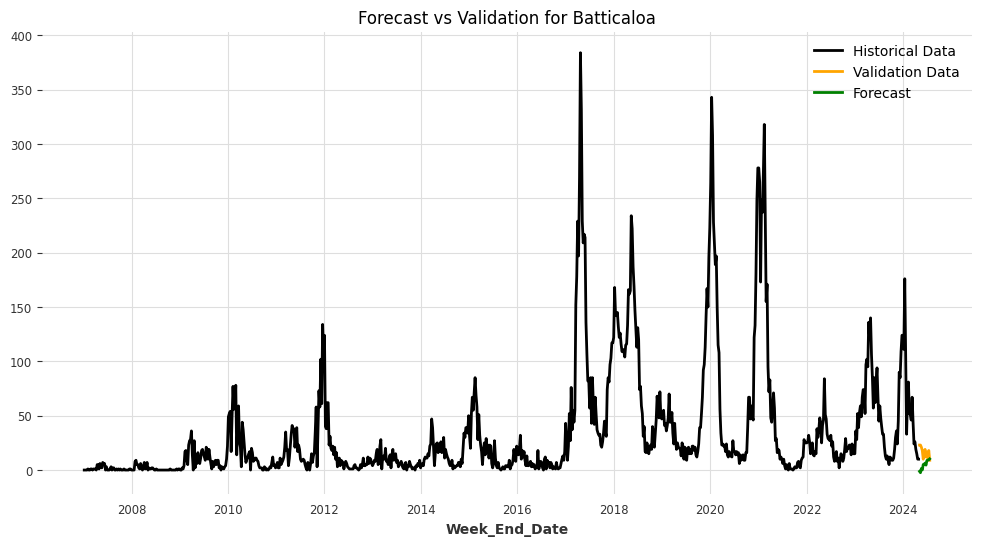

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Colombo: /kaggle/working/Colombo_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

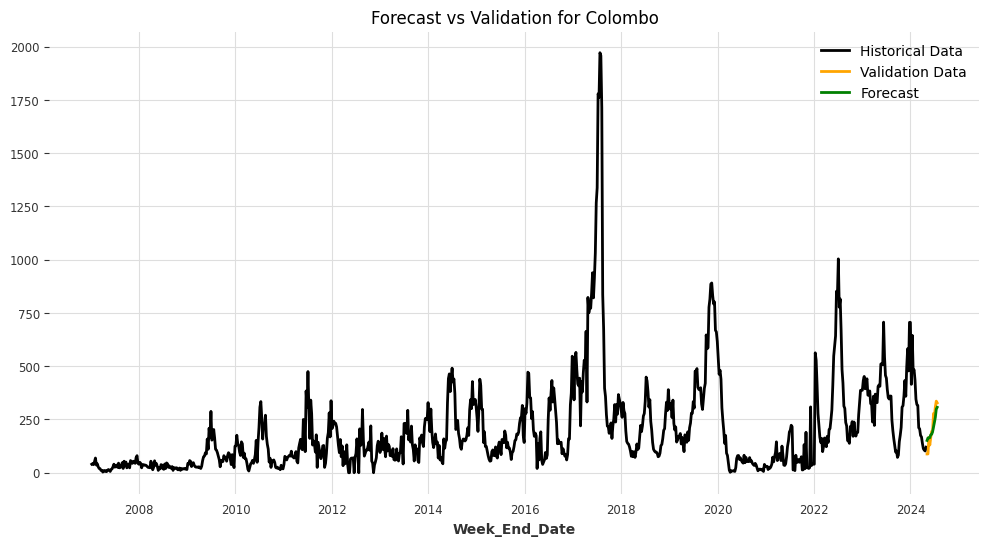

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Colombo: /kaggle/working/Colombo_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

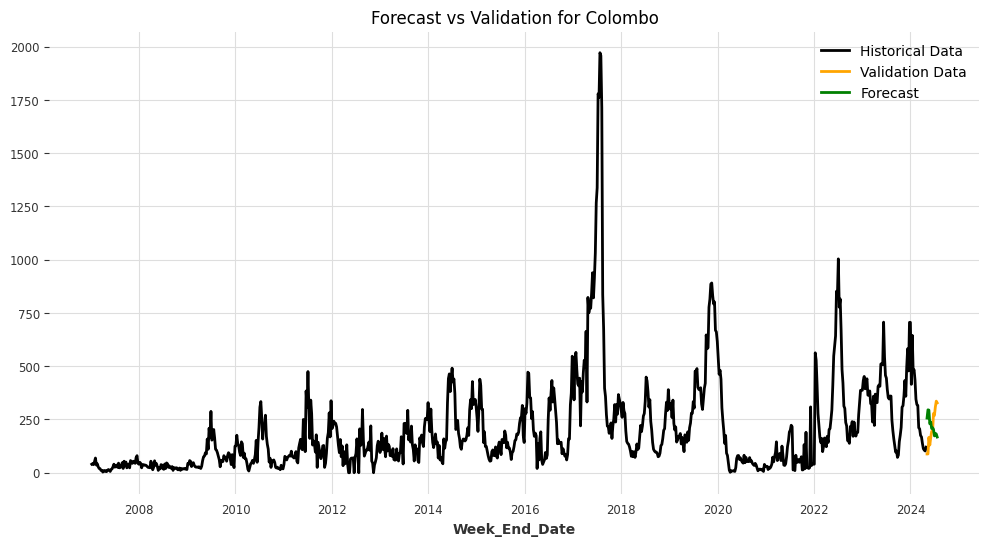

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Colombo: /kaggle/working/Colombo_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

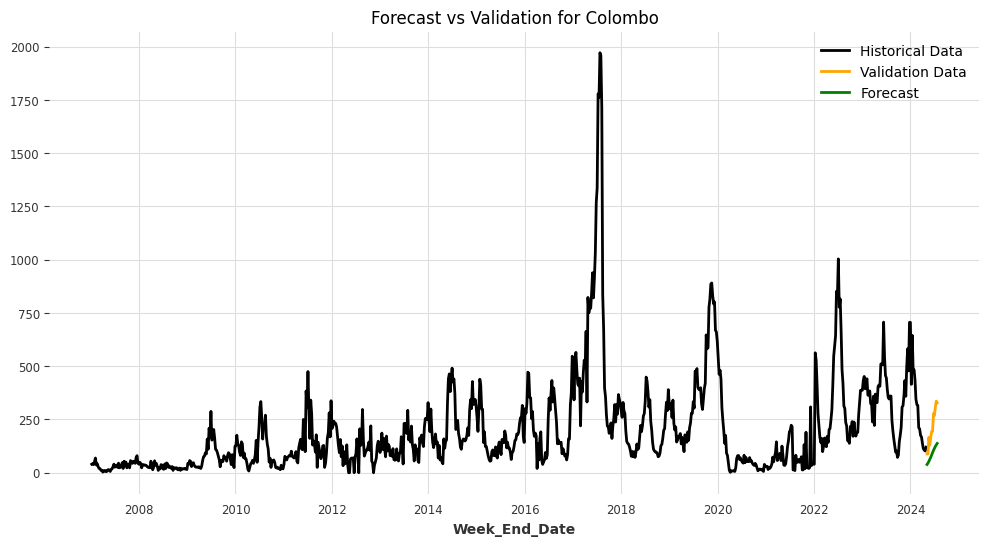

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Colombo: /kaggle/working/Colombo_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

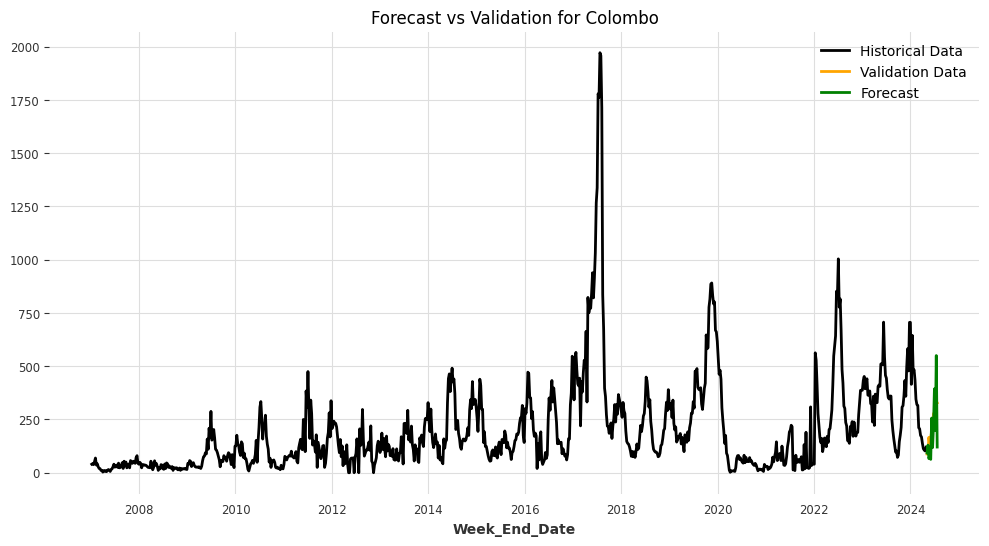

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Colombo: /kaggle/working/Colombo_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

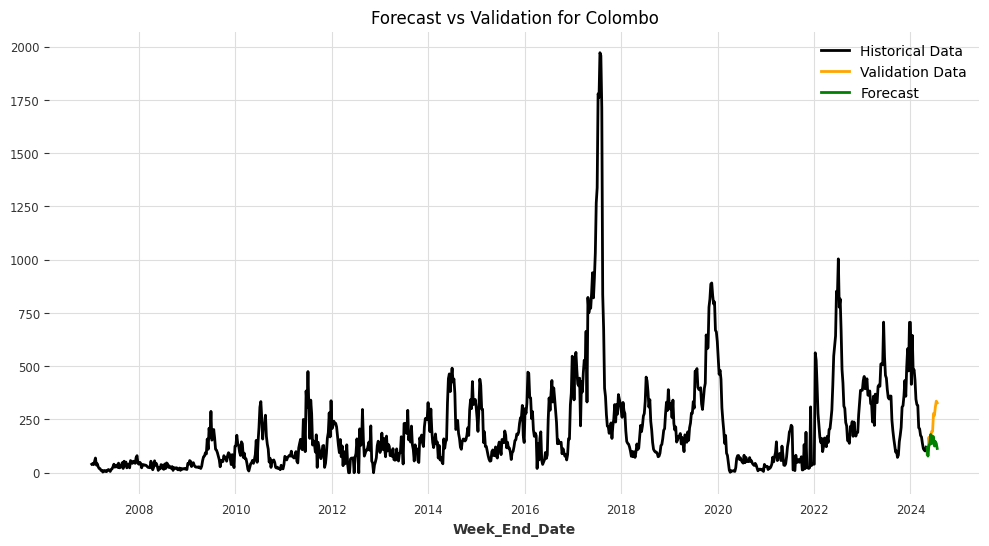

Training length: 904
Validation length: 12


/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Galle: /kaggle/working/Galle_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

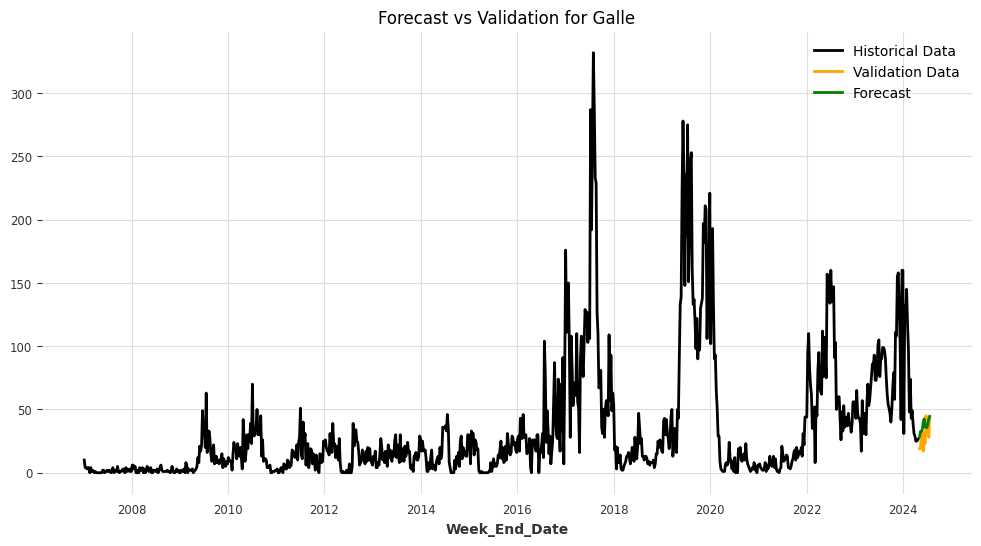

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Galle: /kaggle/working/Galle_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

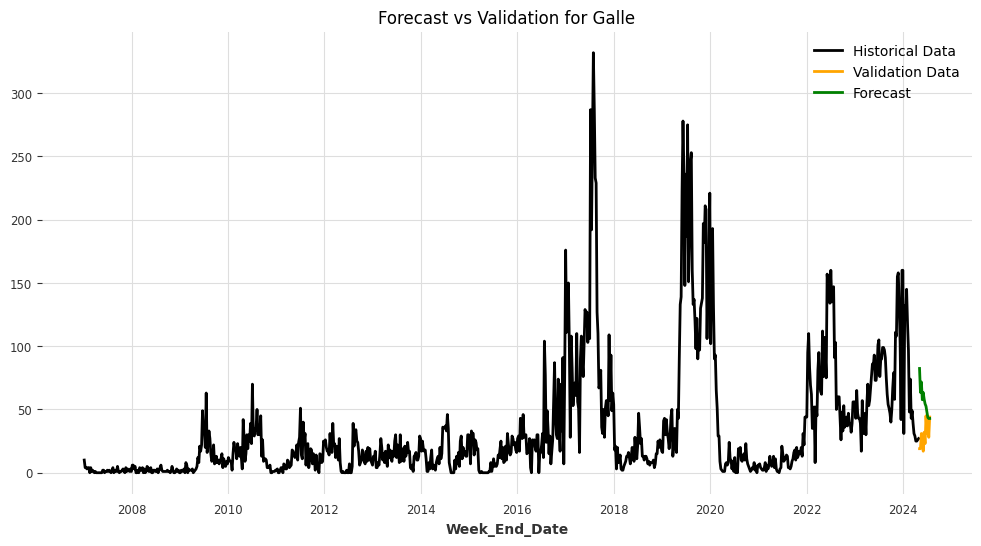

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Galle: /kaggle/working/Galle_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

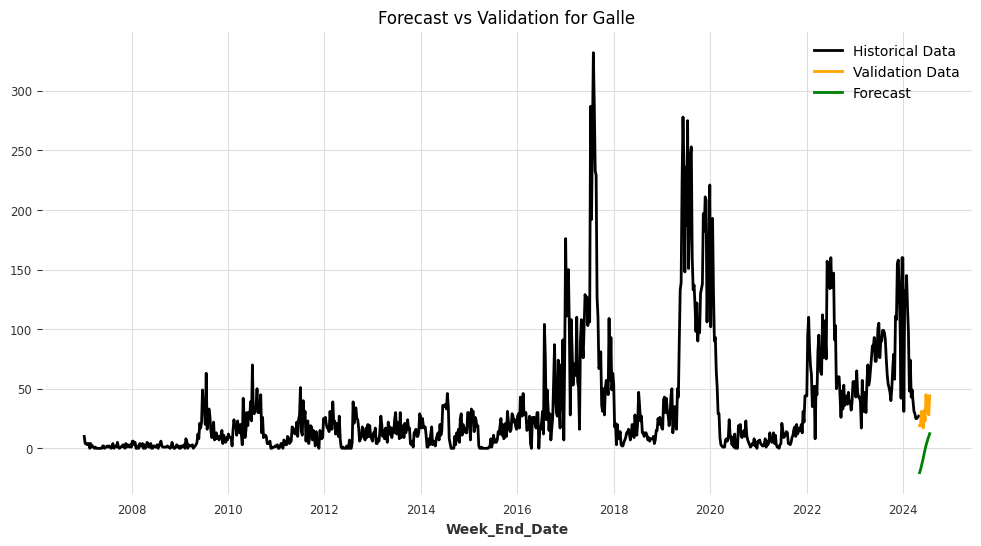

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Galle: /kaggle/working/Galle_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

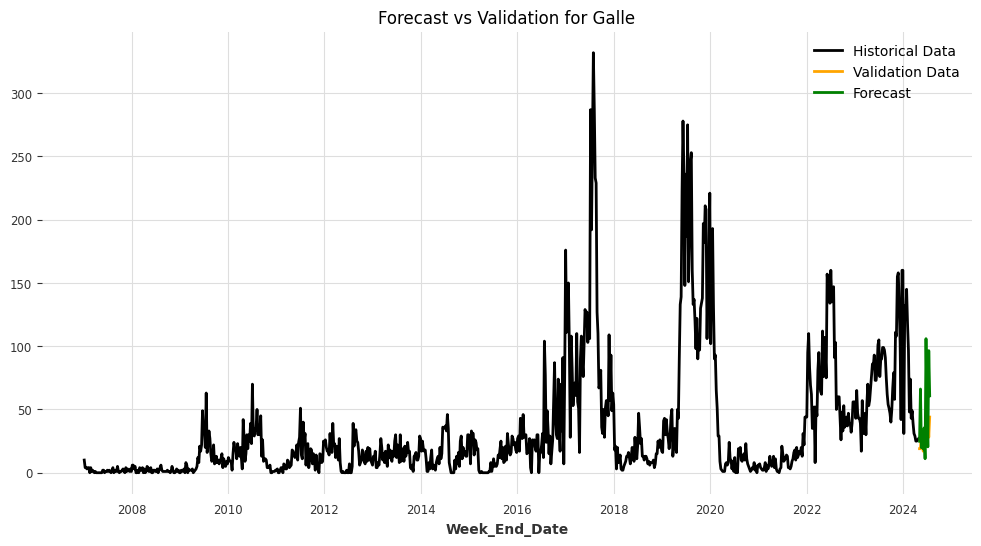

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Galle: /kaggle/working/Galle_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

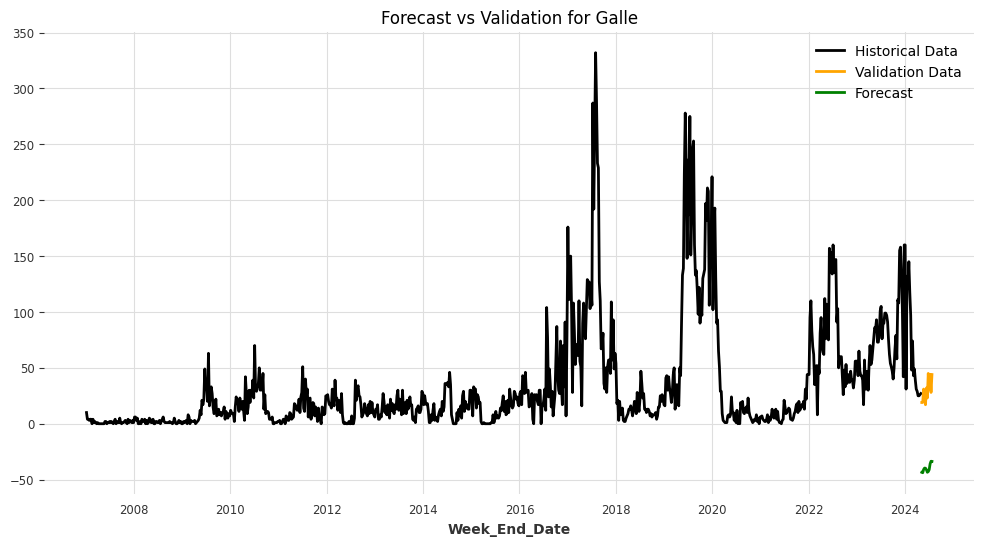

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Gampaha: /kaggle/working/Gampaha_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

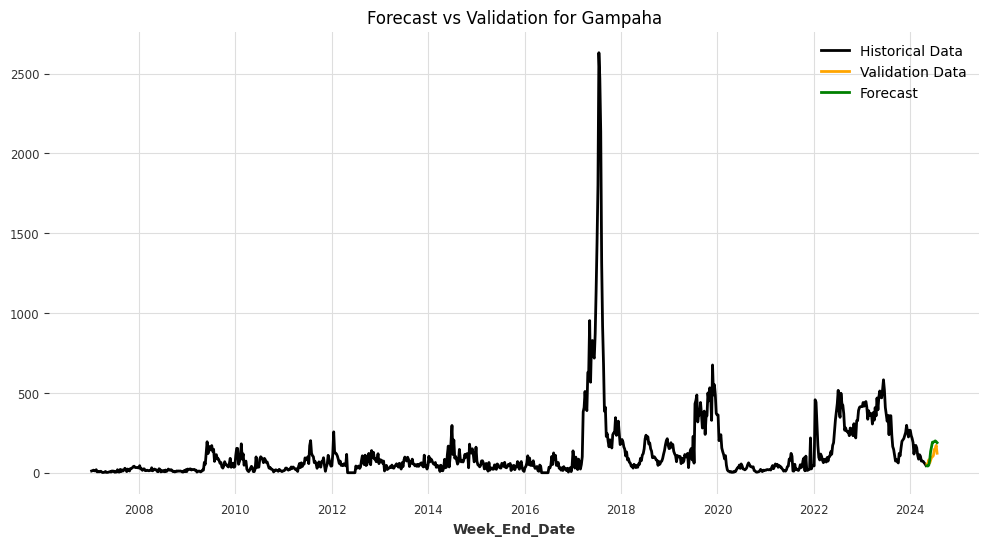

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Gampaha: /kaggle/working/Gampaha_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

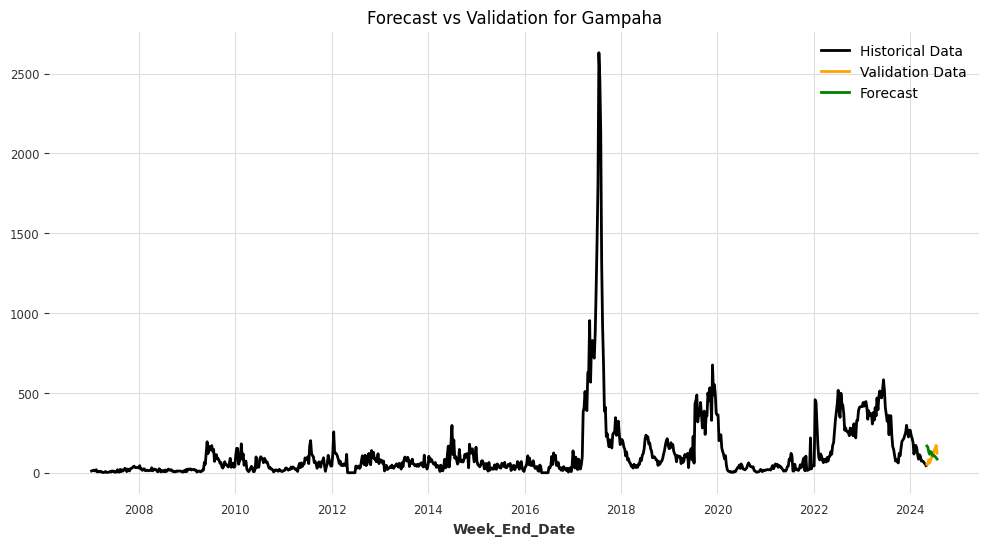

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Gampaha: /kaggle/working/Gampaha_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

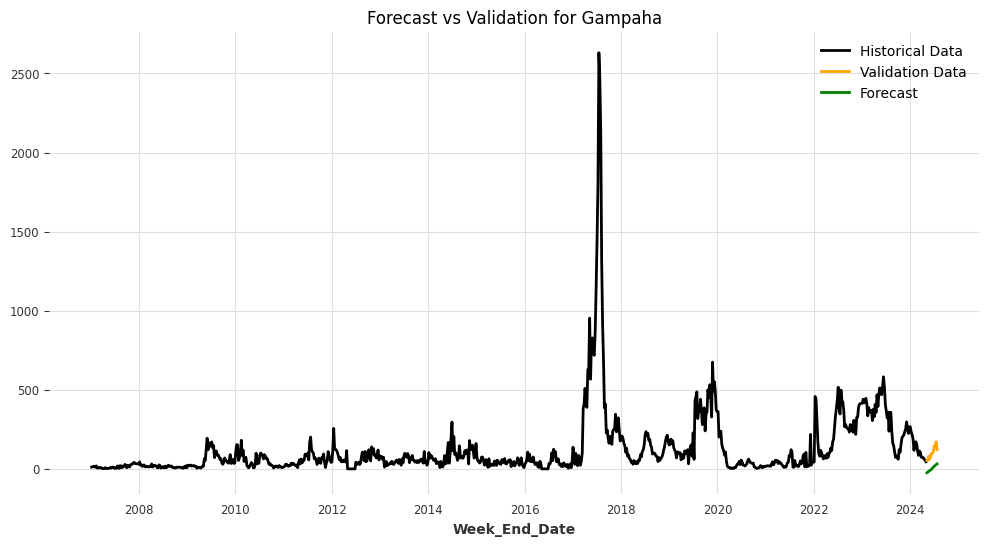

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Gampaha: /kaggle/working/Gampaha_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

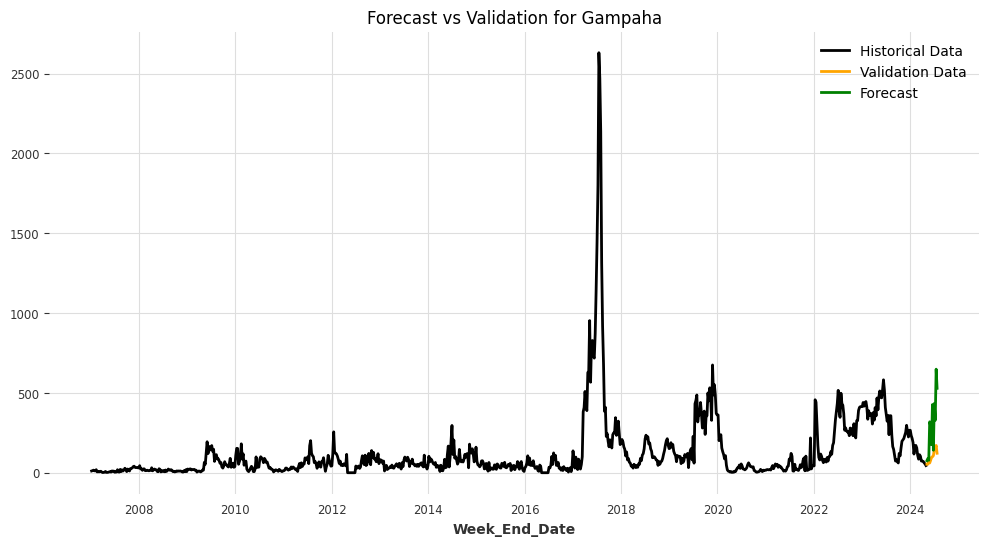

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Gampaha: /kaggle/working/Gampaha_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

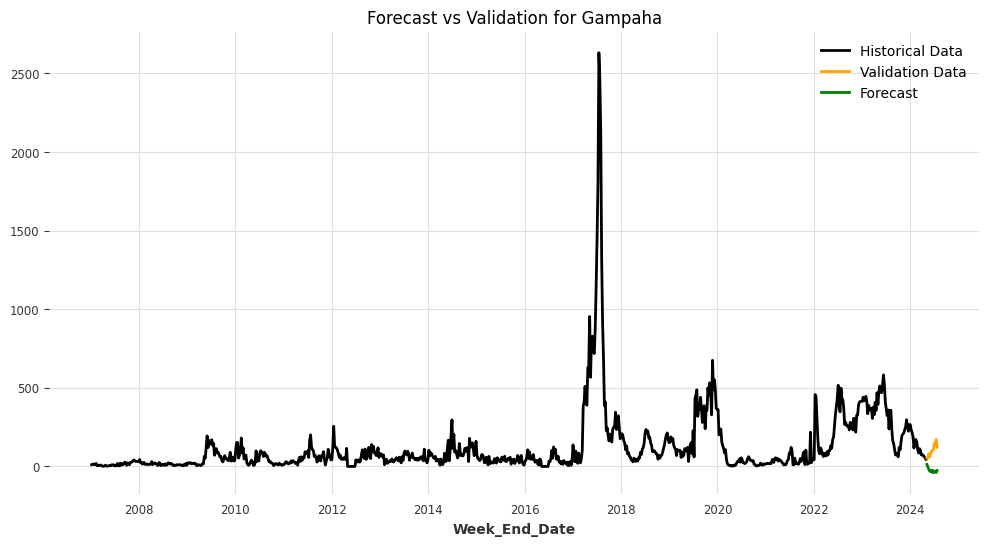

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Hambantota: /kaggle/working/Hambantota_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

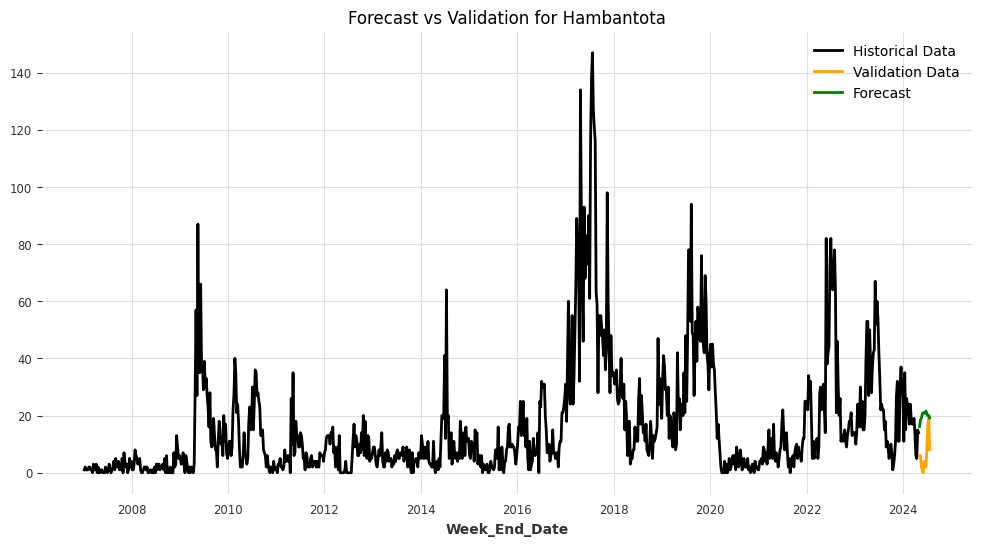

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Hambantota: /kaggle/working/Hambantota_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

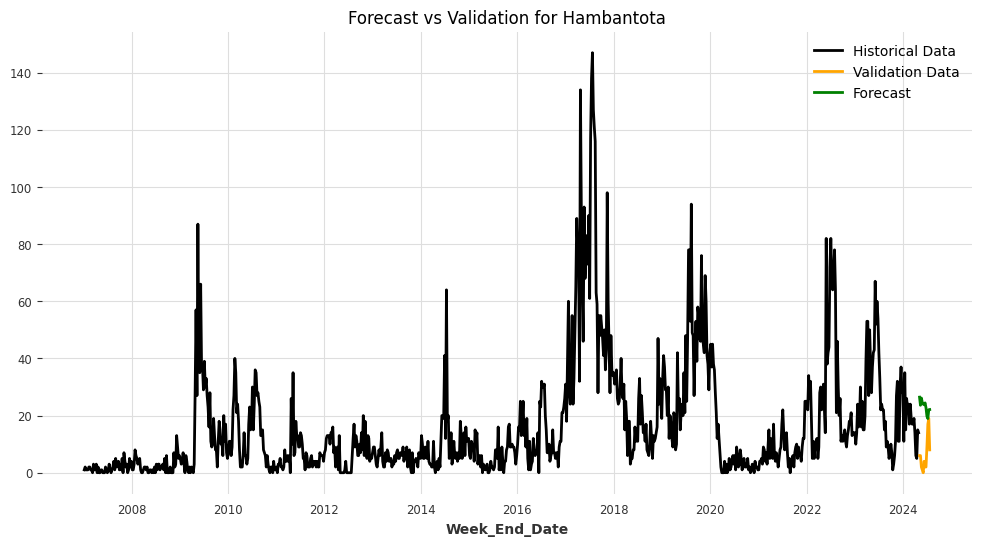

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Hambantota: /kaggle/working/Hambantota_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

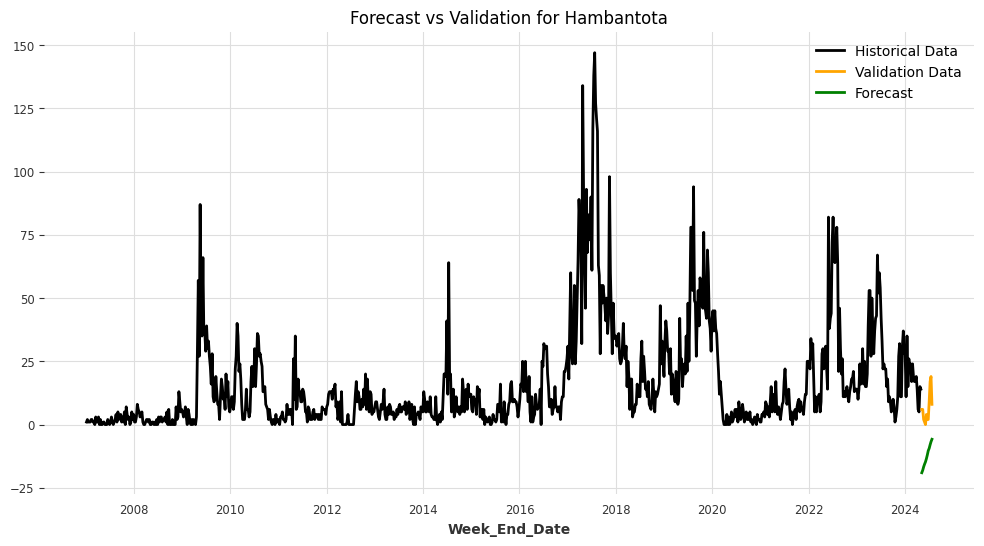

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Hambantota: /kaggle/working/Hambantota_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

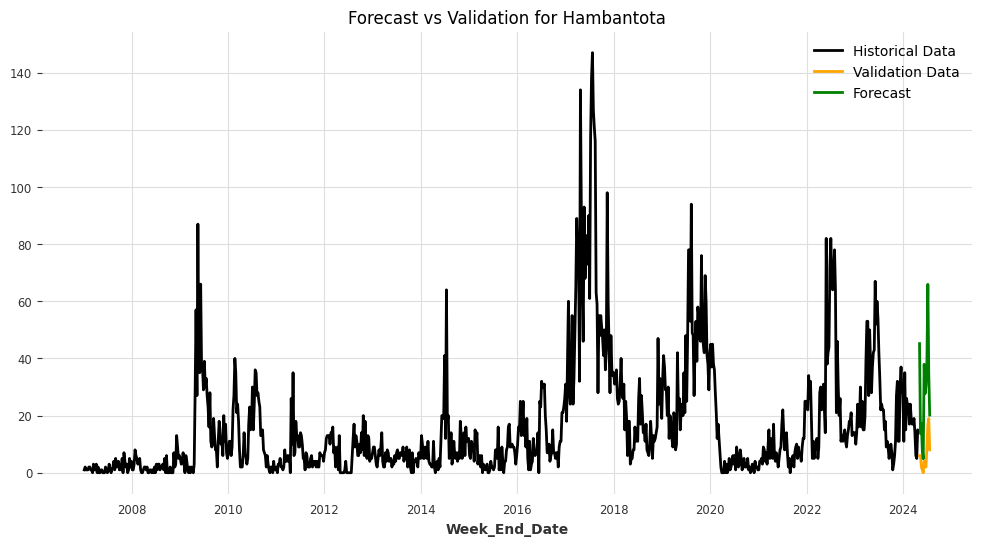

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Hambantota: /kaggle/working/Hambantota_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

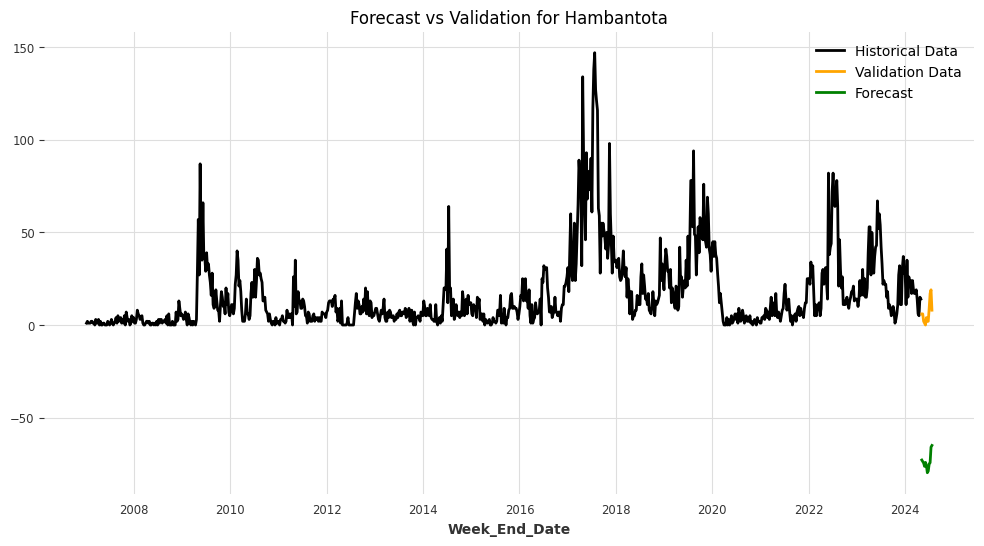

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Jaffna: /kaggle/working/Jaffna_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

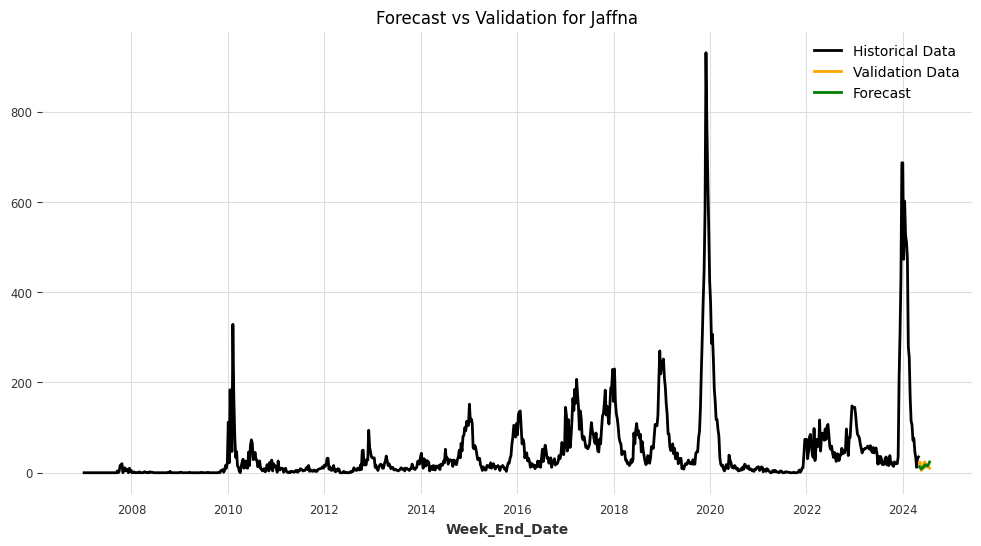

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Jaffna: /kaggle/working/Jaffna_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

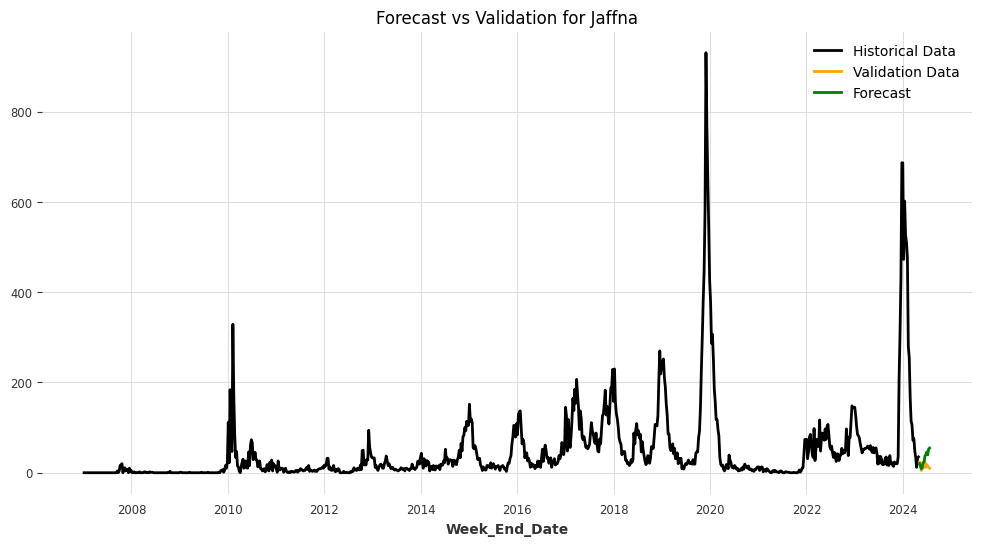

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Jaffna: /kaggle/working/Jaffna_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

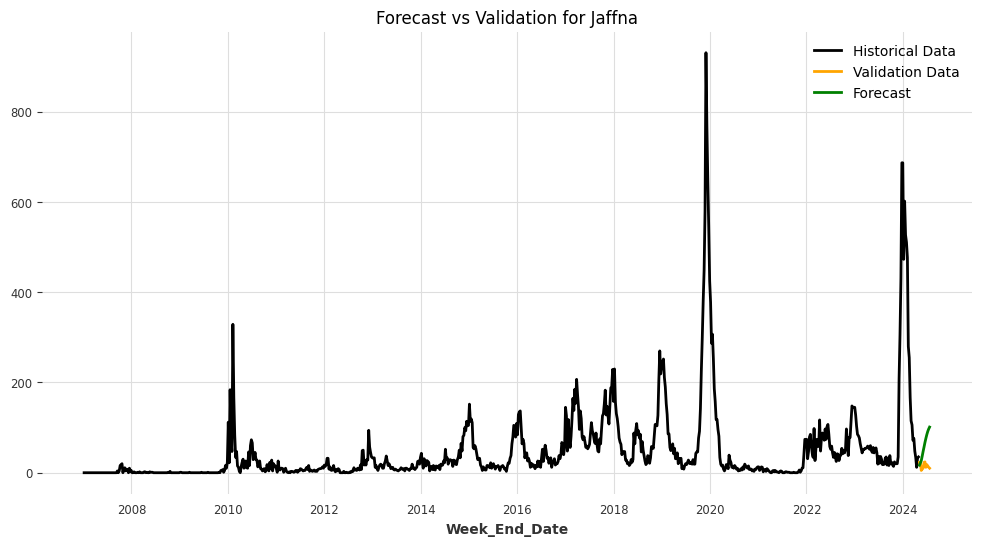

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Jaffna: /kaggle/working/Jaffna_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

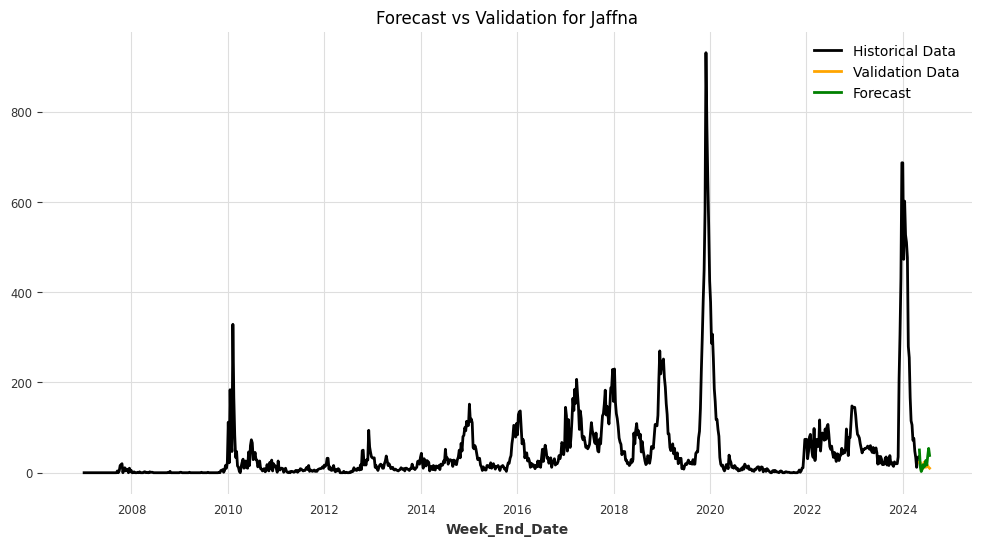

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Jaffna: /kaggle/working/Jaffna_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

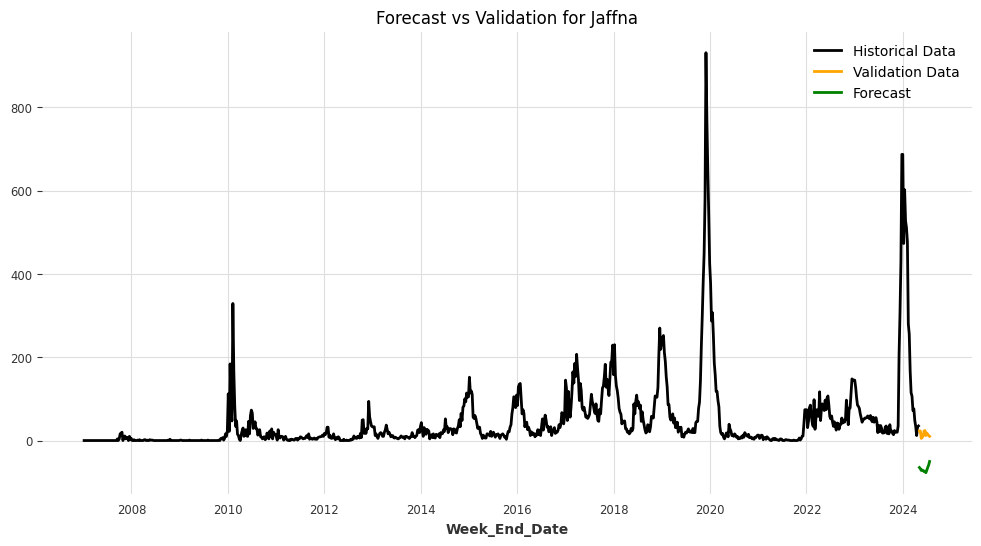

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kalutara: /kaggle/working/Kalutara_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

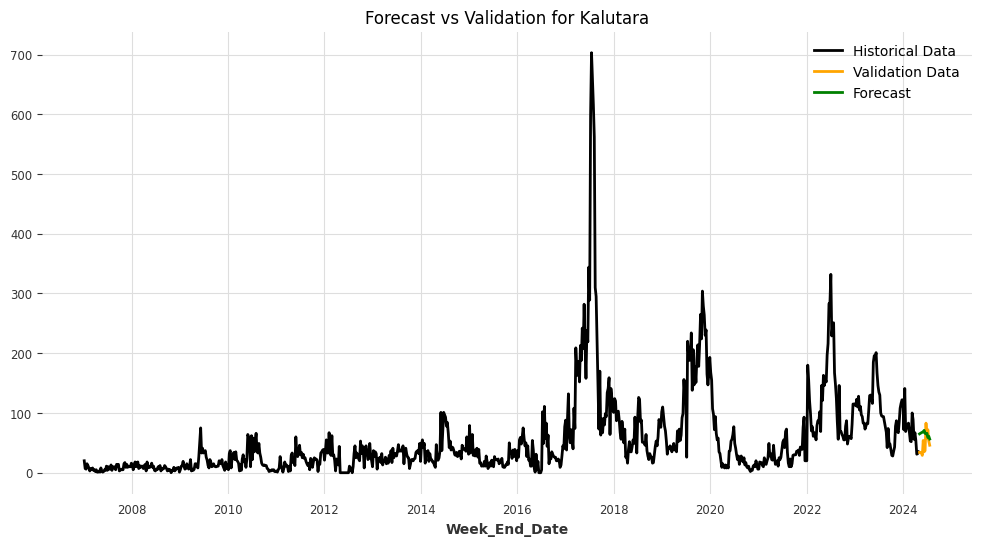

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kalutara: /kaggle/working/Kalutara_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

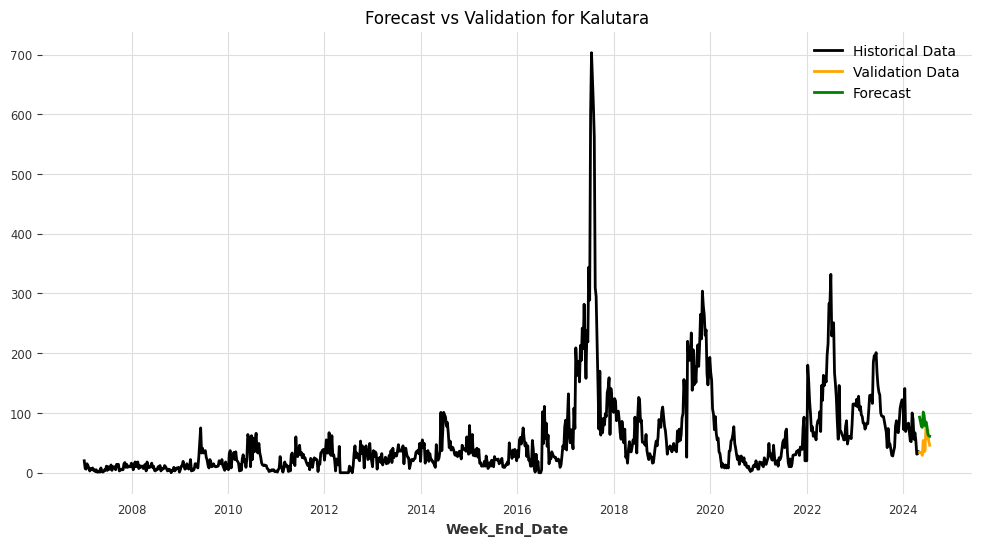

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kalutara: /kaggle/working/Kalutara_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

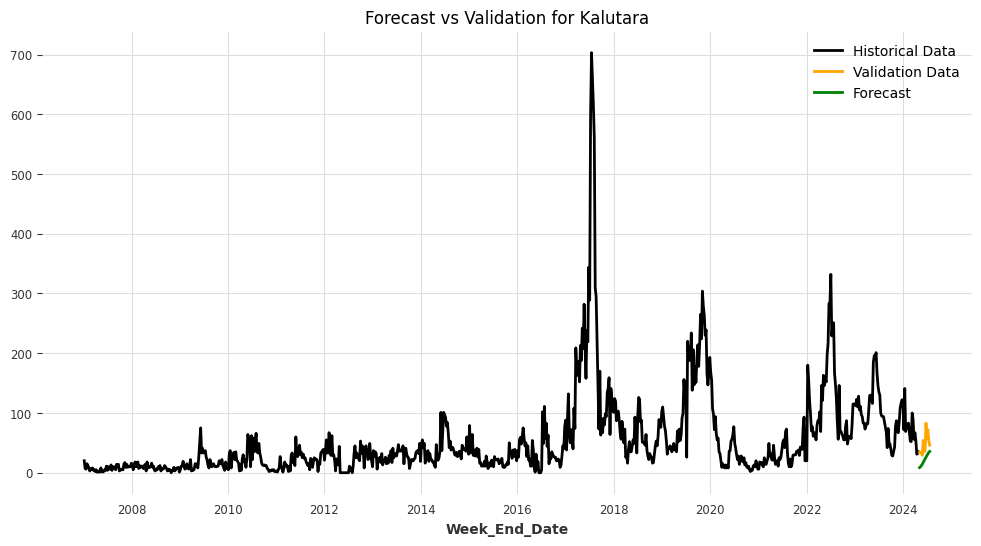

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kalutara: /kaggle/working/Kalutara_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

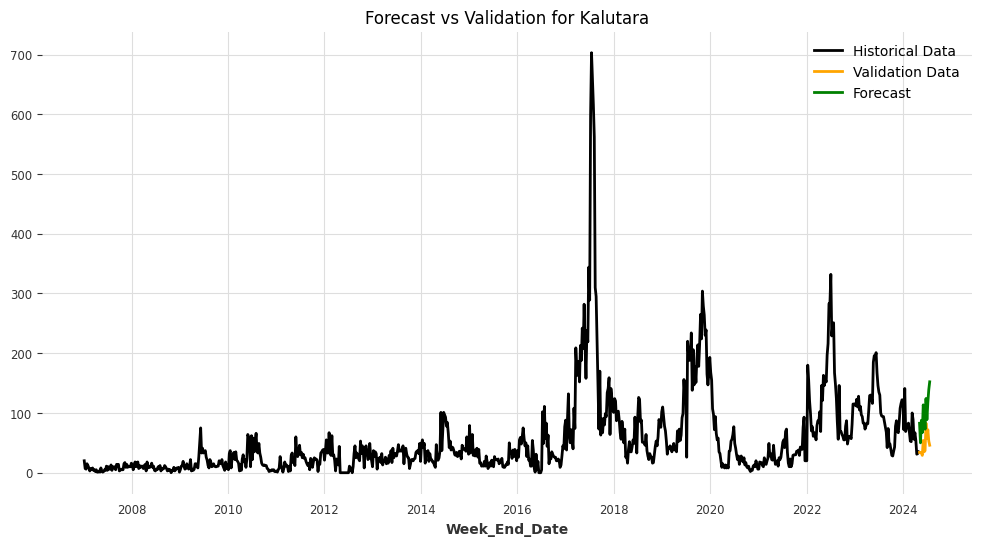

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kalutara: /kaggle/working/Kalutara_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

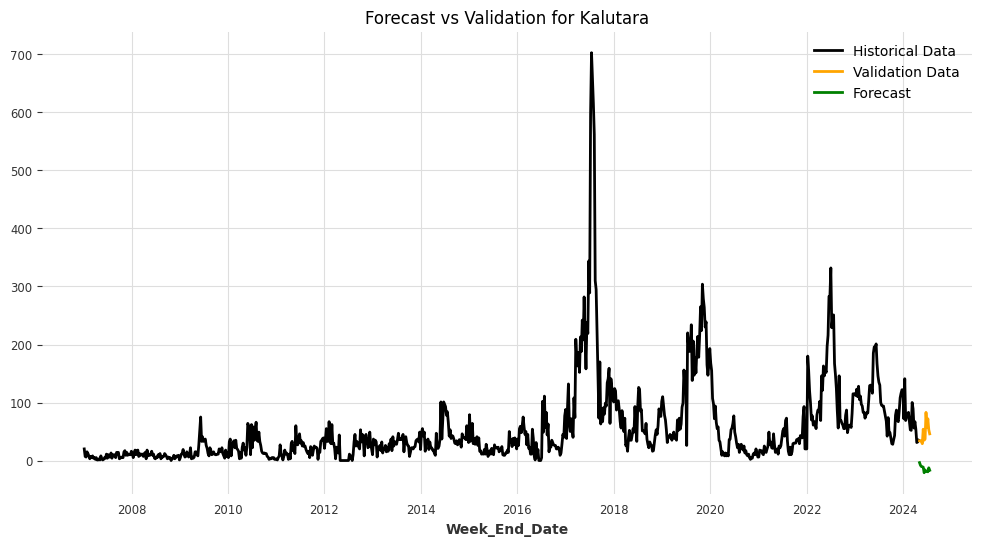

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kandy: /kaggle/working/Kandy_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

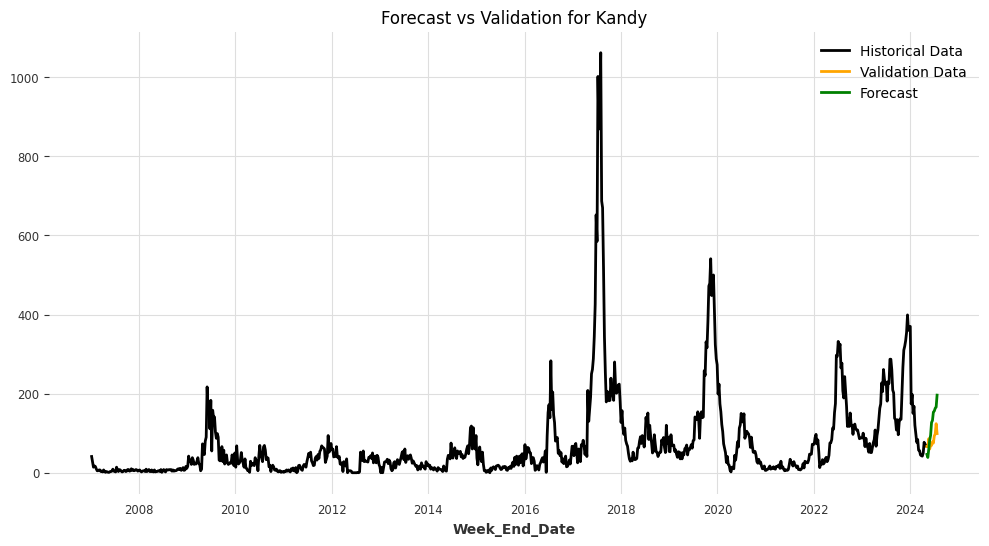

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kandy: /kaggle/working/Kandy_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

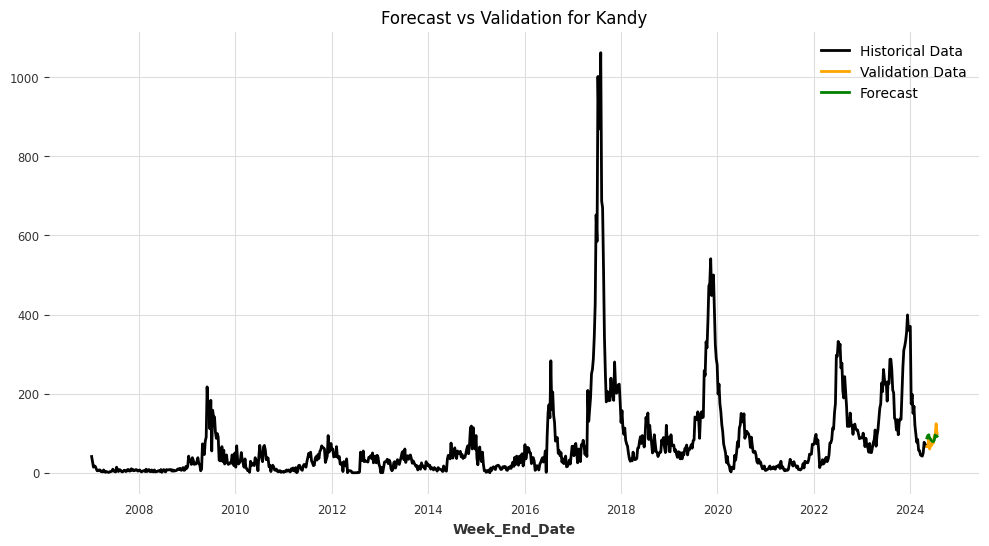

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kandy: /kaggle/working/Kandy_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

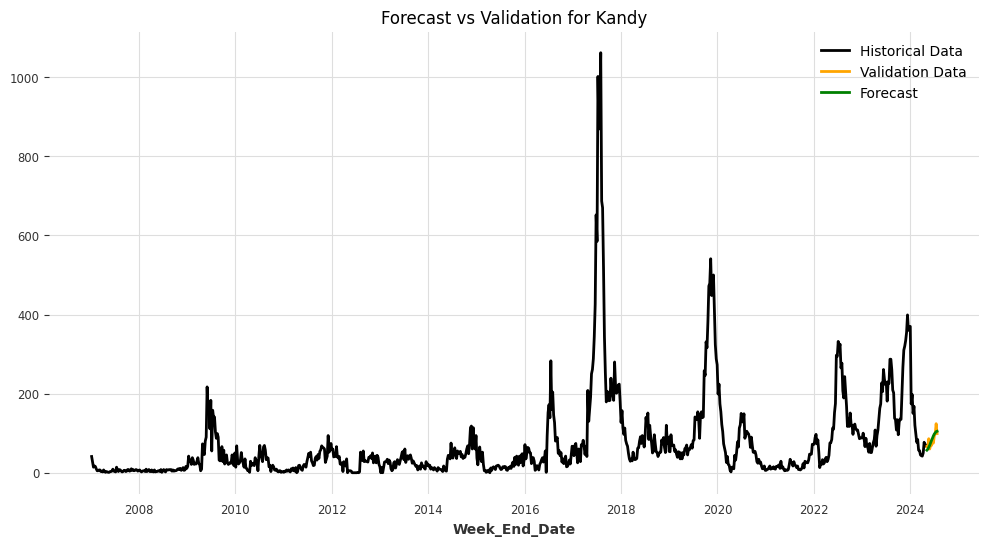

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kandy: /kaggle/working/Kandy_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

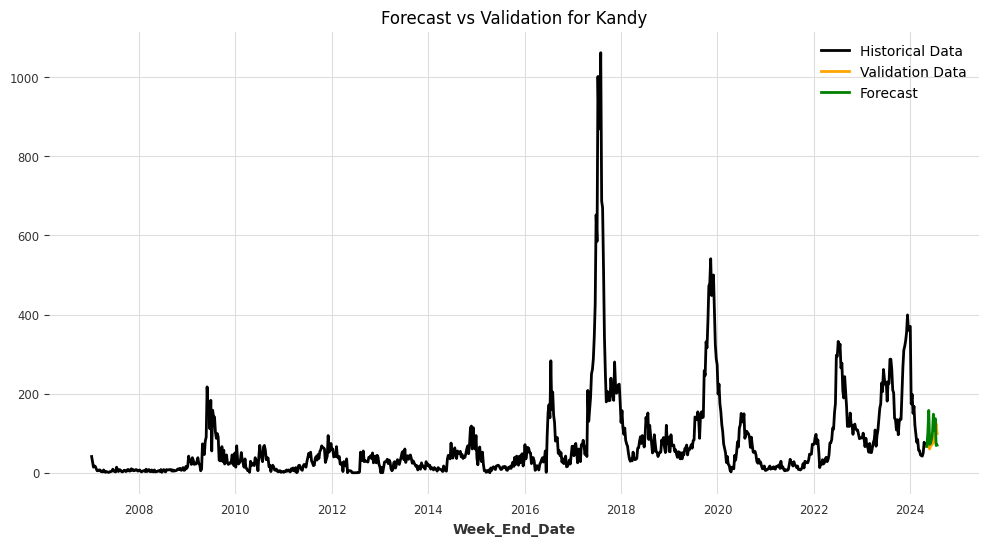

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kandy: /kaggle/working/Kandy_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

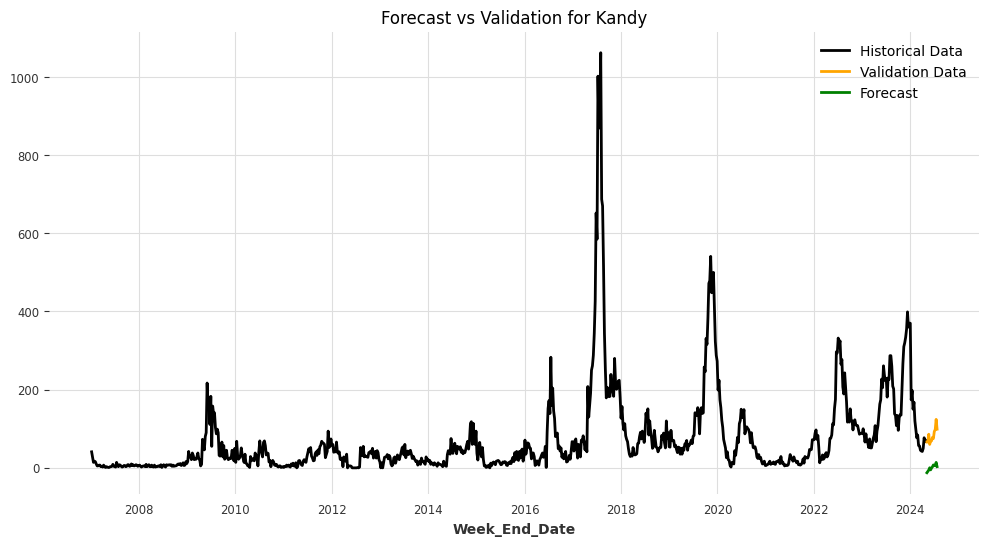

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kegalle: /kaggle/working/Kegalle_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

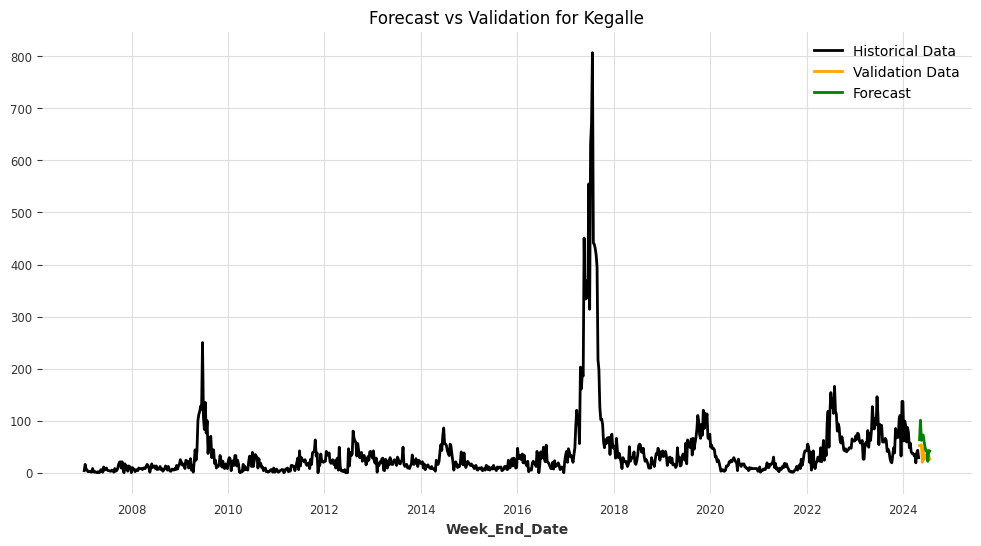

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kegalle: /kaggle/working/Kegalle_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

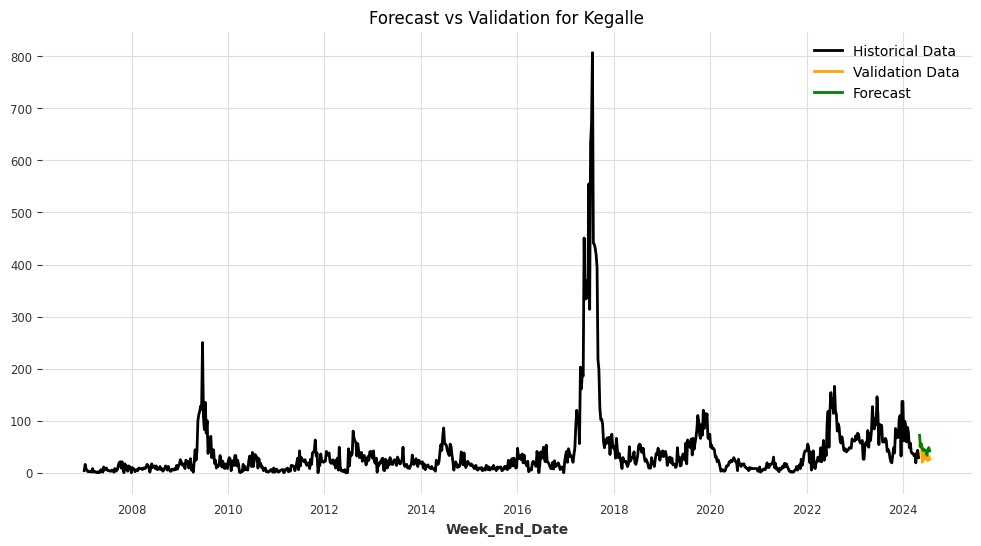

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kegalle: /kaggle/working/Kegalle_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

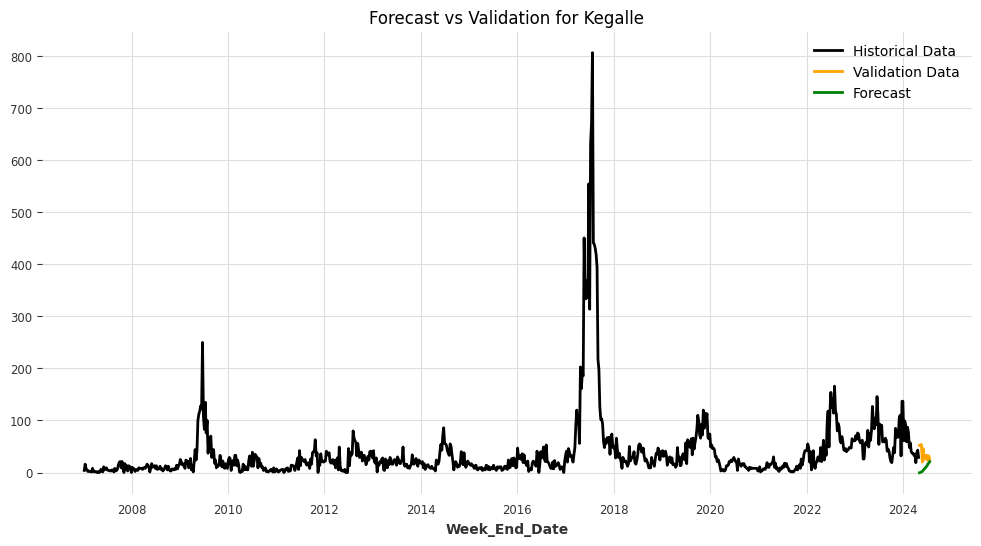

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kegalle: /kaggle/working/Kegalle_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

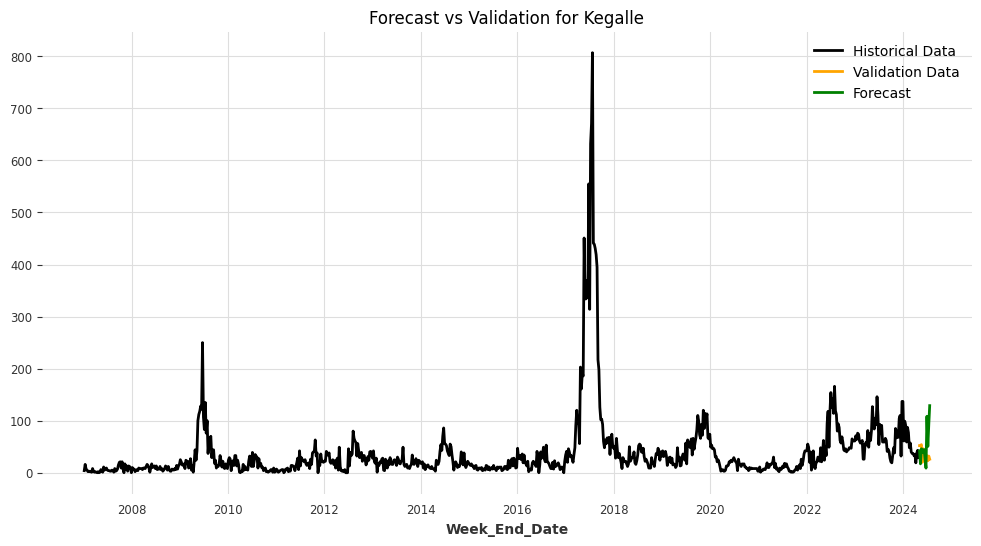

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kegalle: /kaggle/working/Kegalle_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

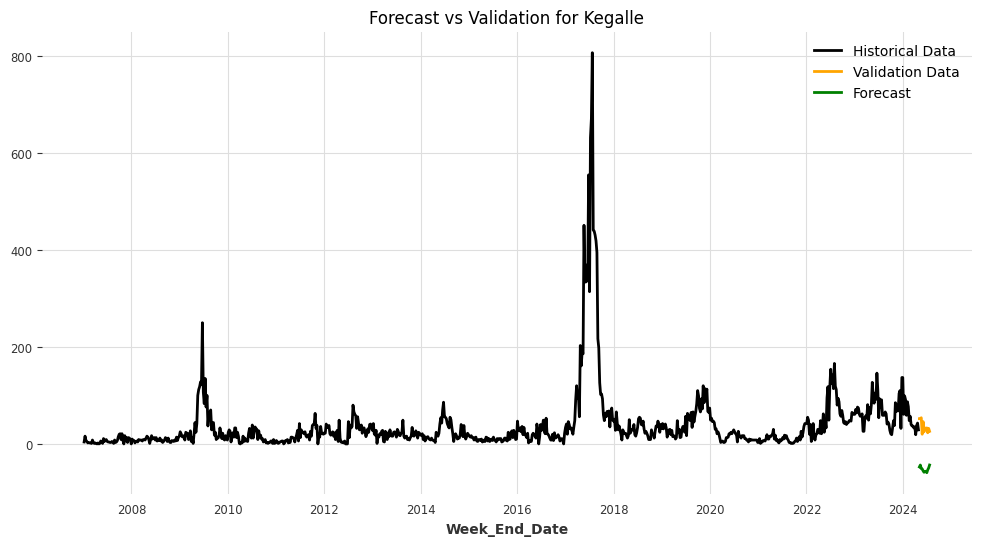

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kilinochchi: /kaggle/working/Kilinochchi_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

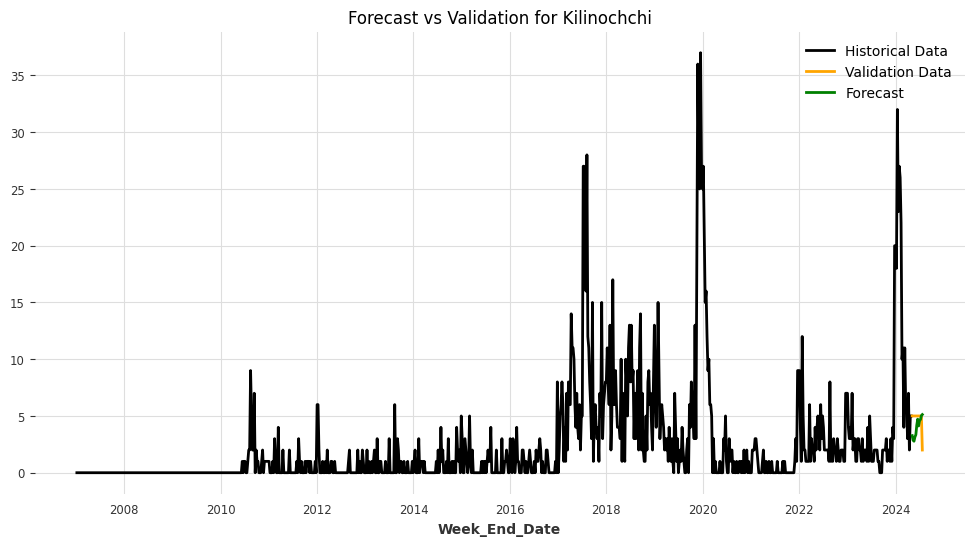

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kilinochchi: /kaggle/working/Kilinochchi_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

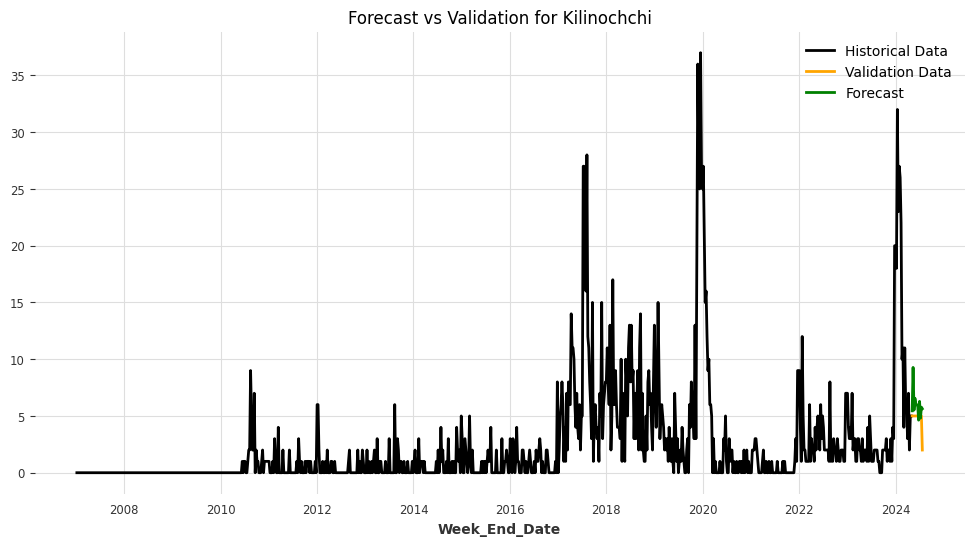

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kilinochchi: /kaggle/working/Kilinochchi_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

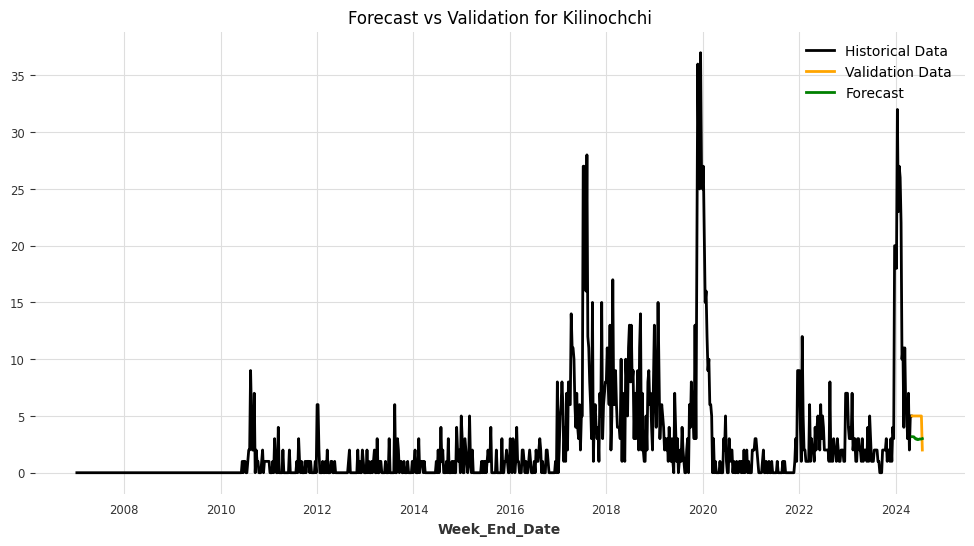

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kilinochchi: /kaggle/working/Kilinochchi_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

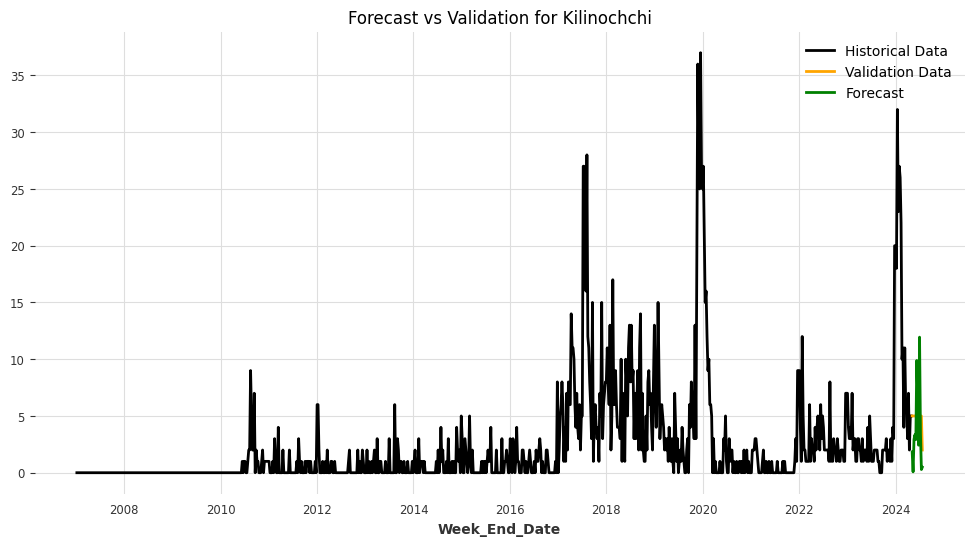

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kilinochchi: /kaggle/working/Kilinochchi_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

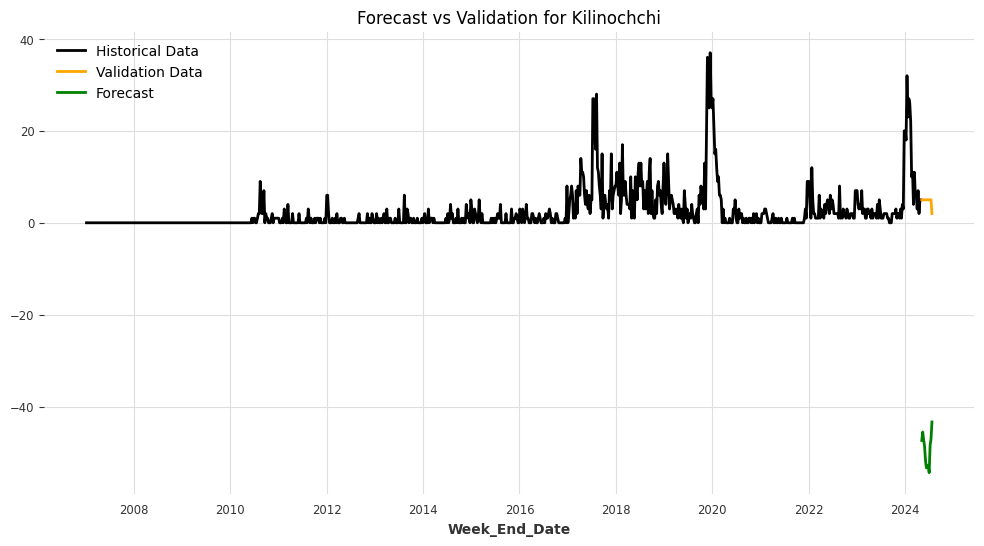

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kurunegala: /kaggle/working/Kurunegala_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

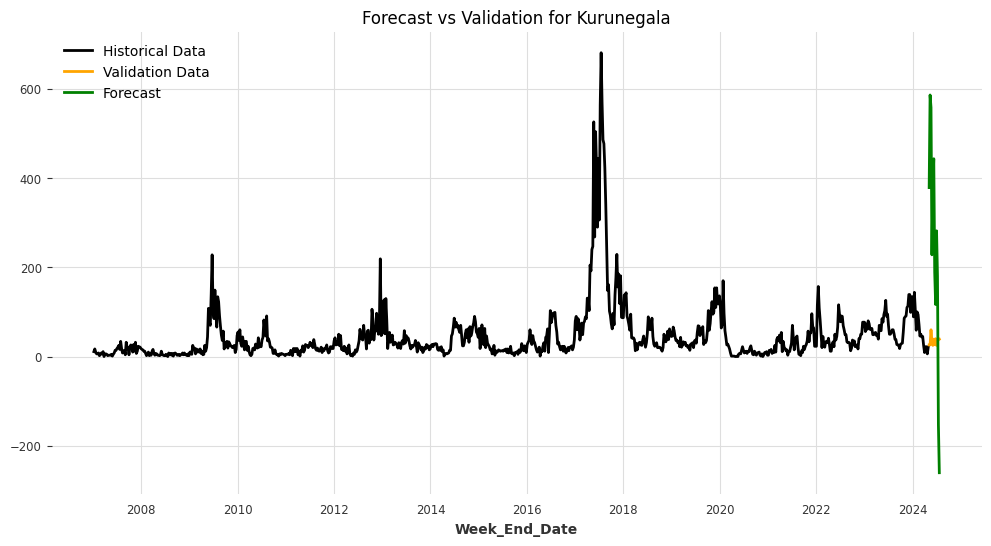

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kurunegala: /kaggle/working/Kurunegala_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

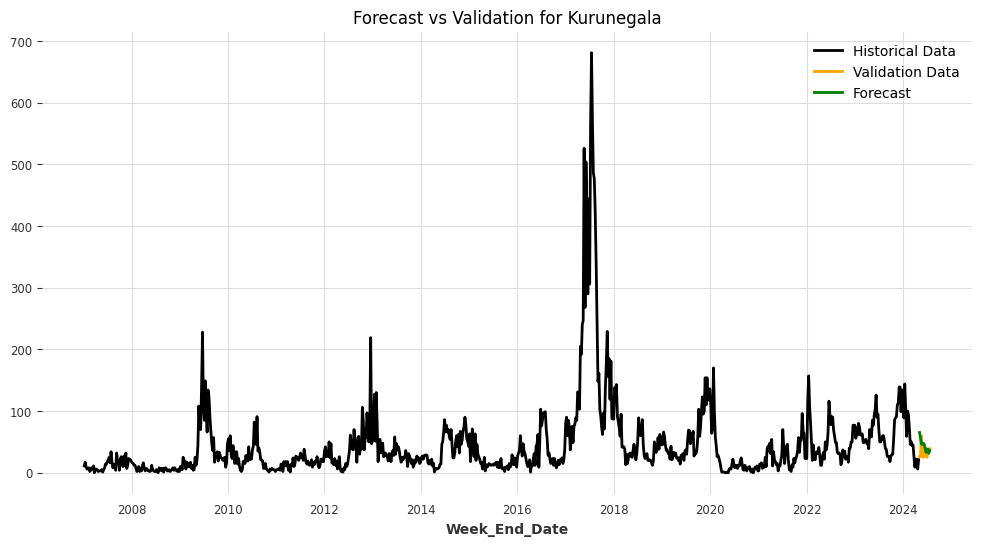

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kurunegala: /kaggle/working/Kurunegala_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

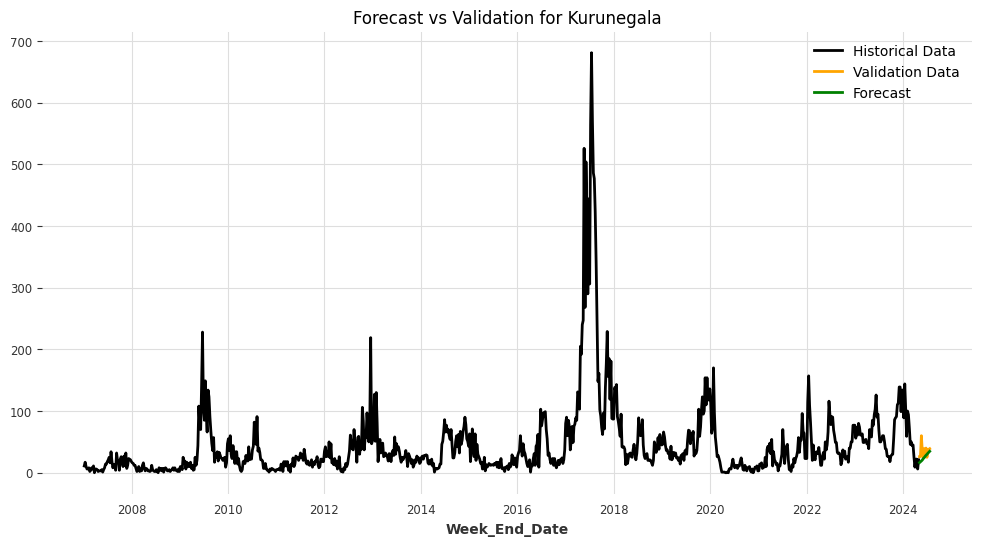

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kurunegala: /kaggle/working/Kurunegala_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

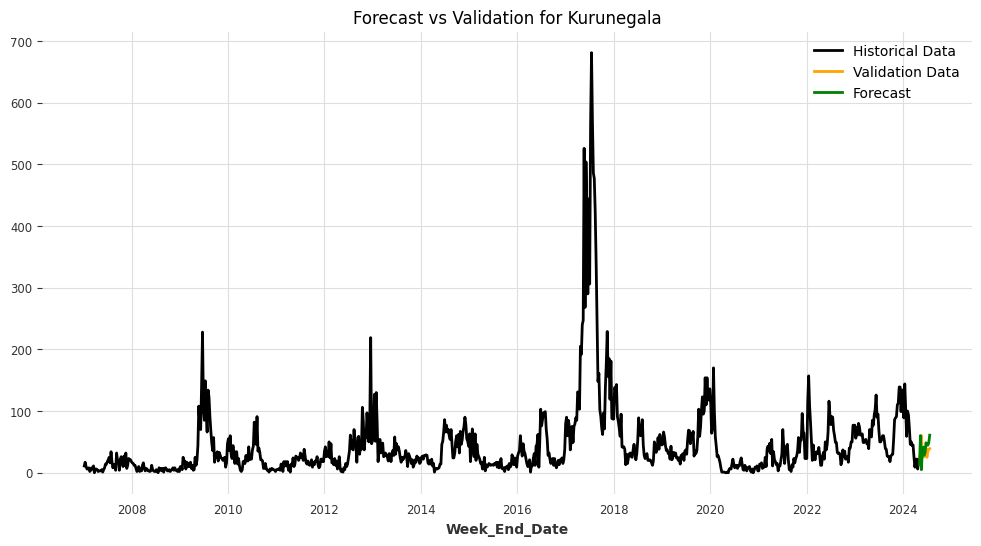

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Kurunegala: /kaggle/working/Kurunegala_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

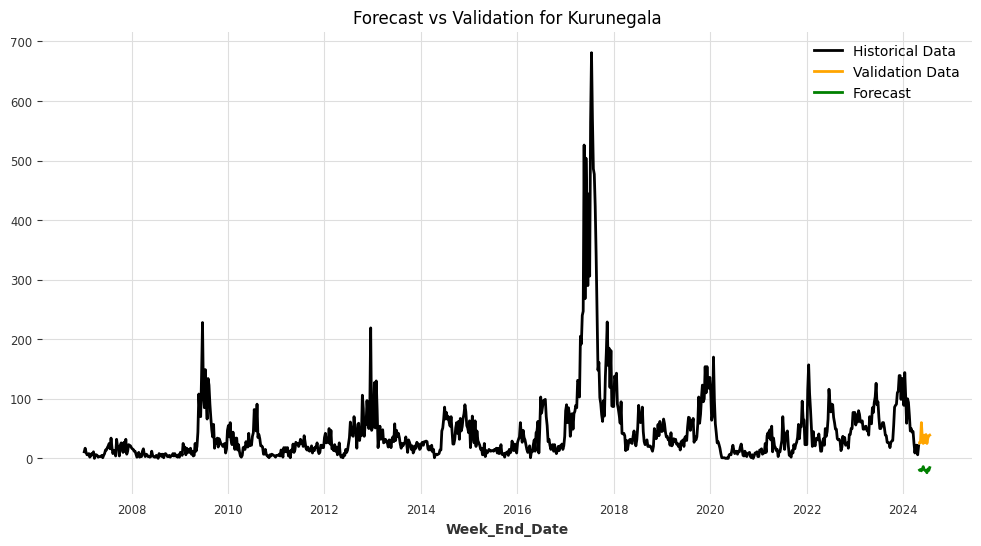

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Mannar: /kaggle/working/Mannar_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

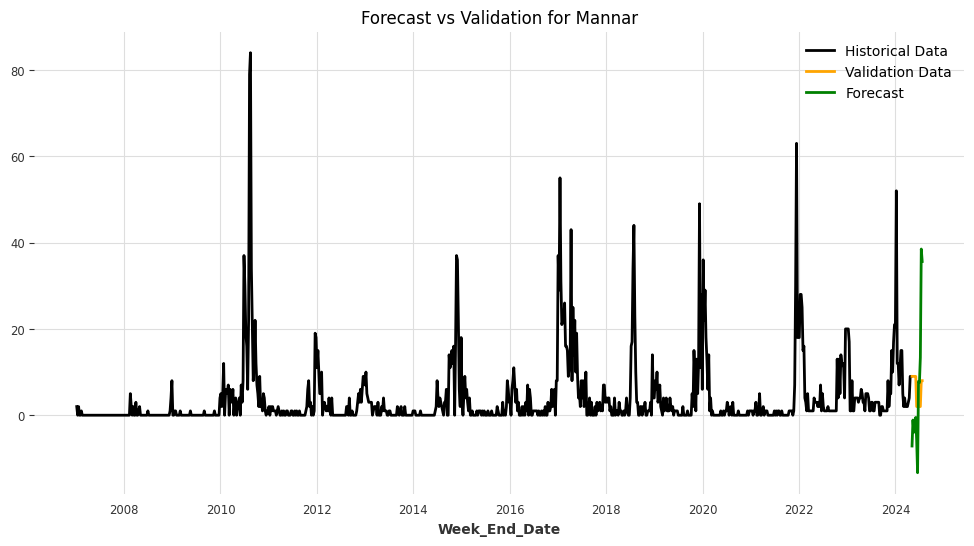

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Mannar: /kaggle/working/Mannar_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

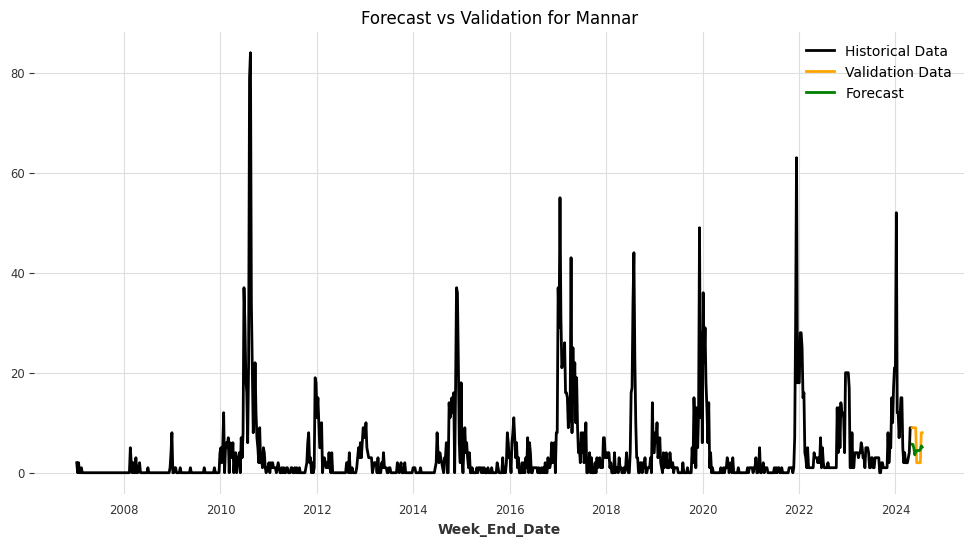

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Mannar: /kaggle/working/Mannar_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

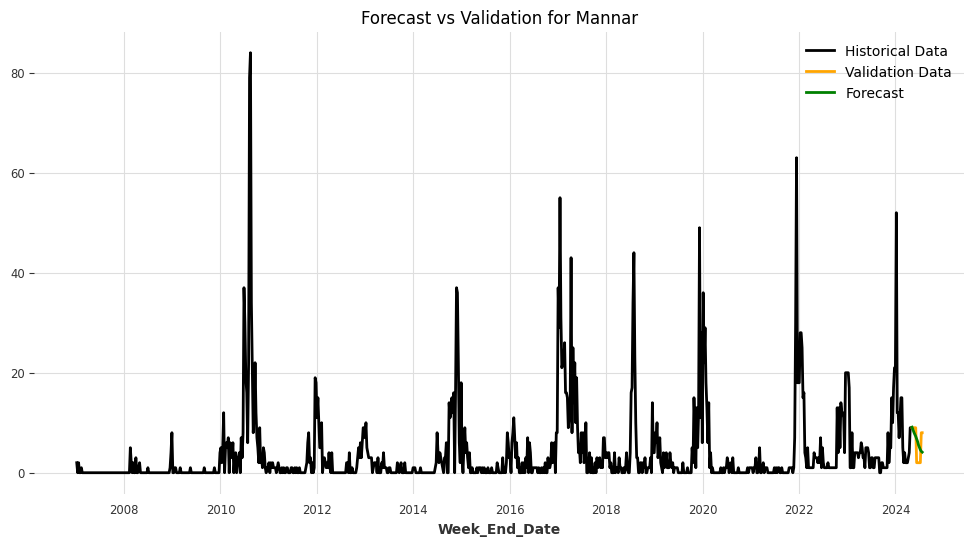

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Mannar: /kaggle/working/Mannar_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

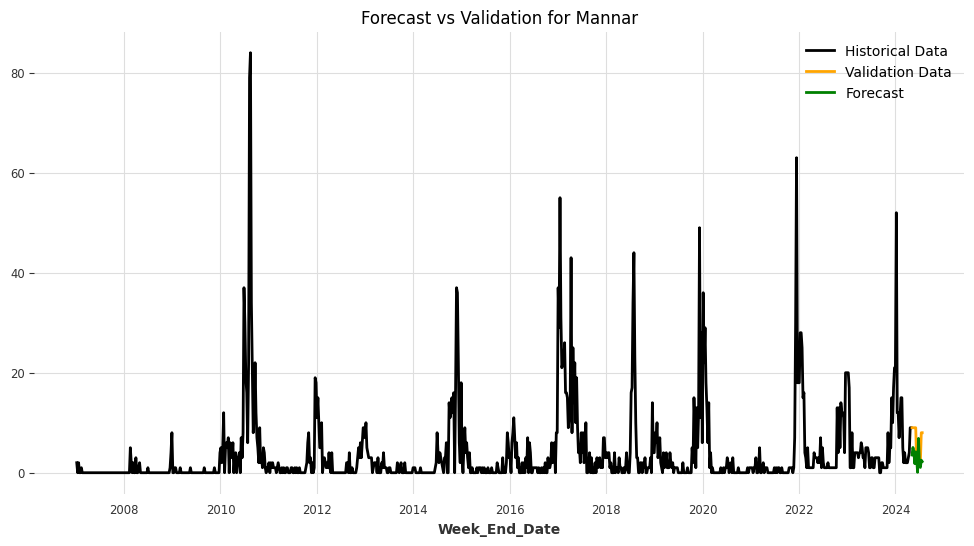

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Mannar: /kaggle/working/Mannar_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

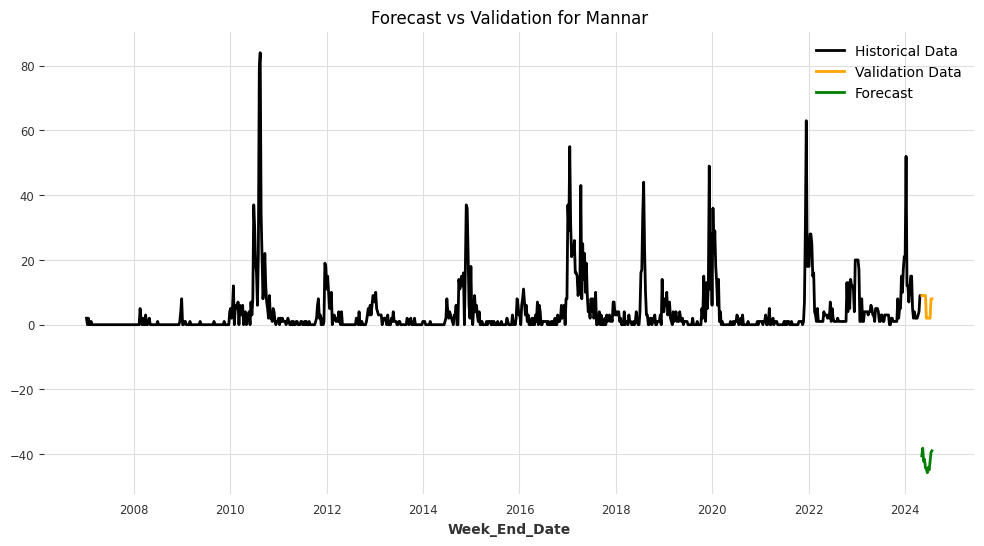

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Matale: /kaggle/working/Matale_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

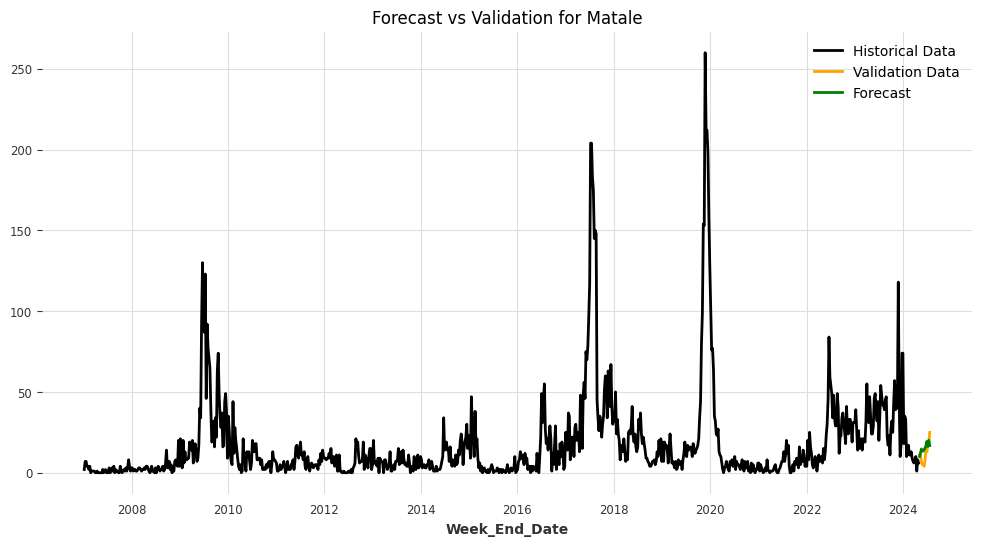

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Matale: /kaggle/working/Matale_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

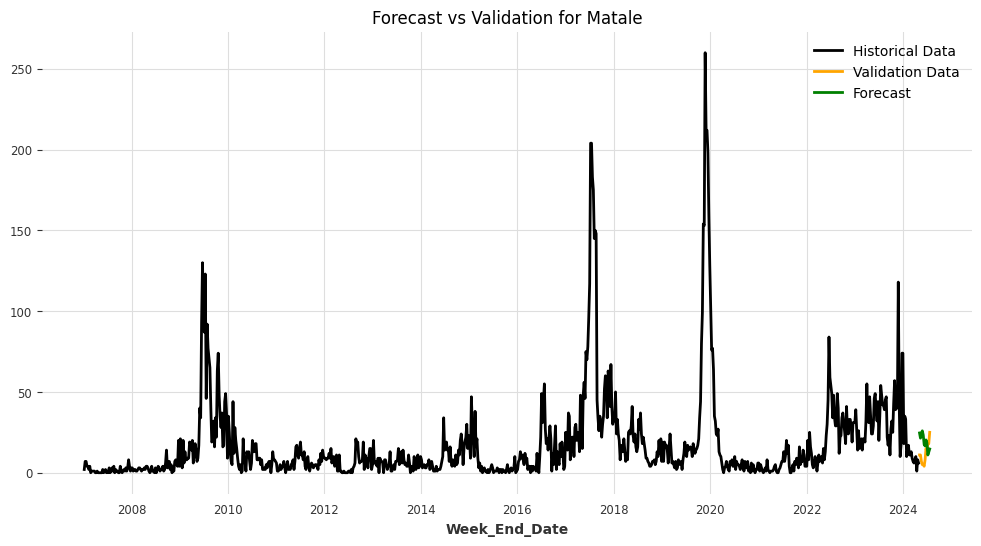

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Matale: /kaggle/working/Matale_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

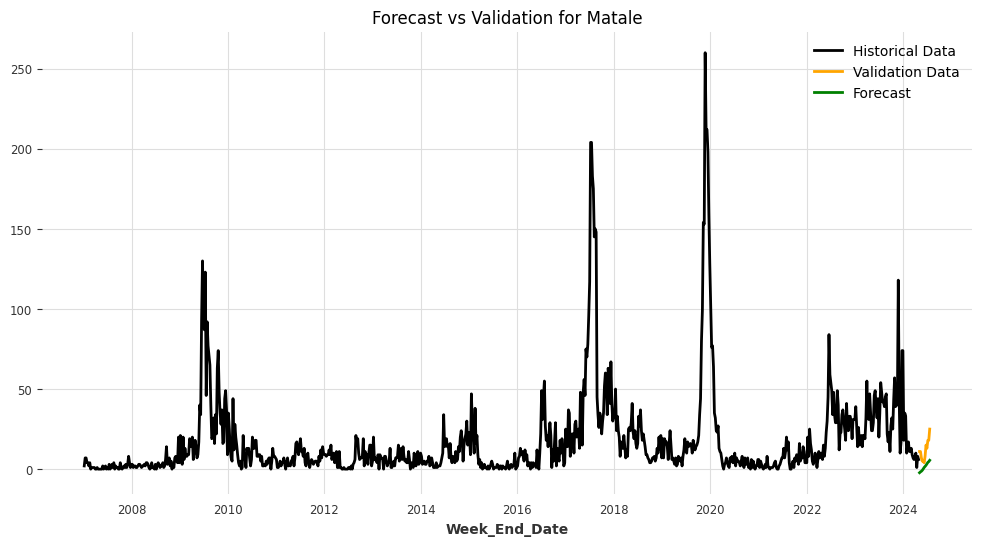

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Matale: /kaggle/working/Matale_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

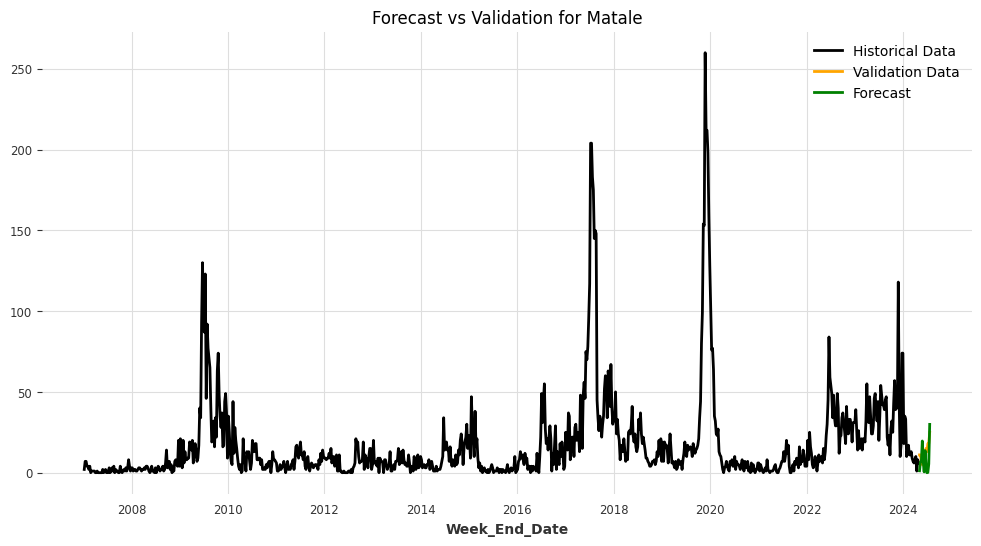

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Matale: /kaggle/working/Matale_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

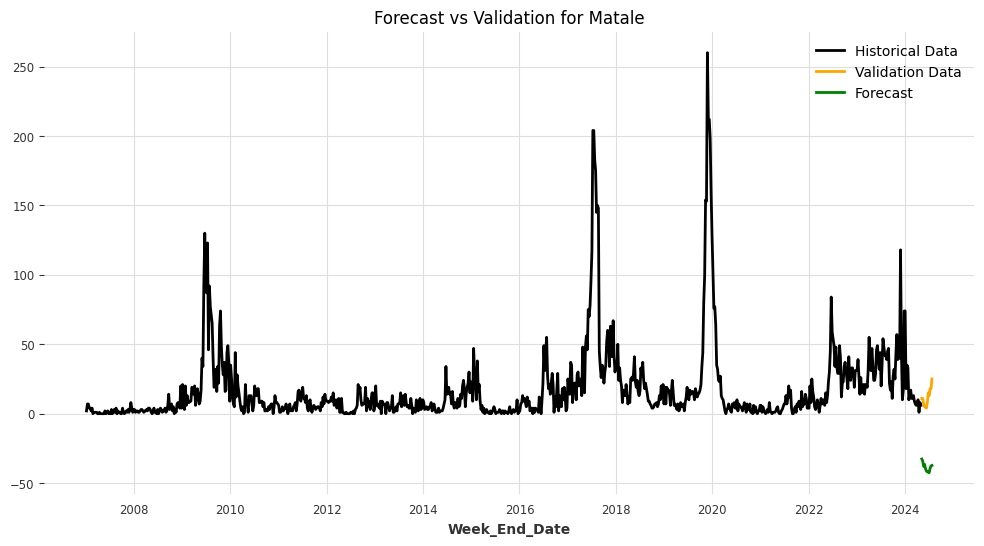

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Matara: /kaggle/working/Matara_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

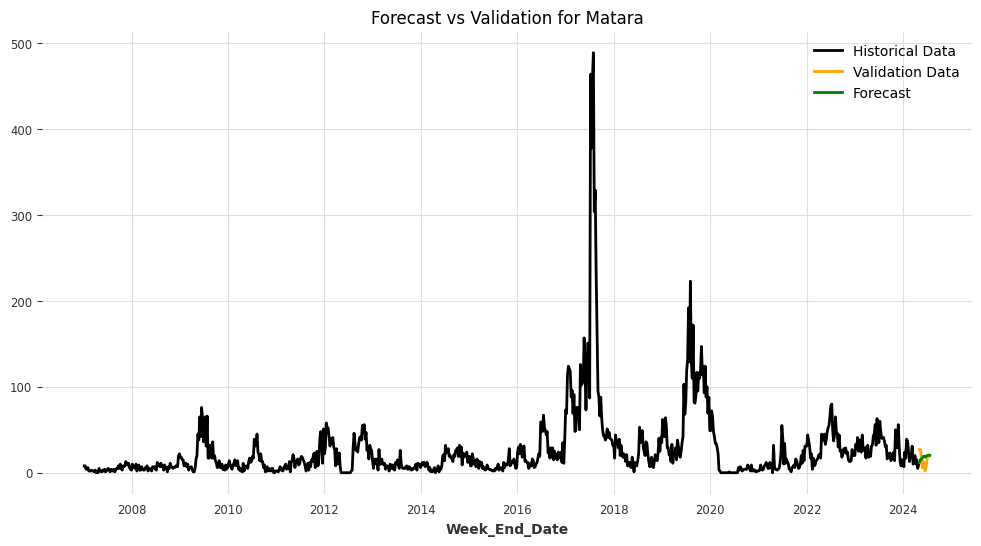

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Matara: /kaggle/working/Matara_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

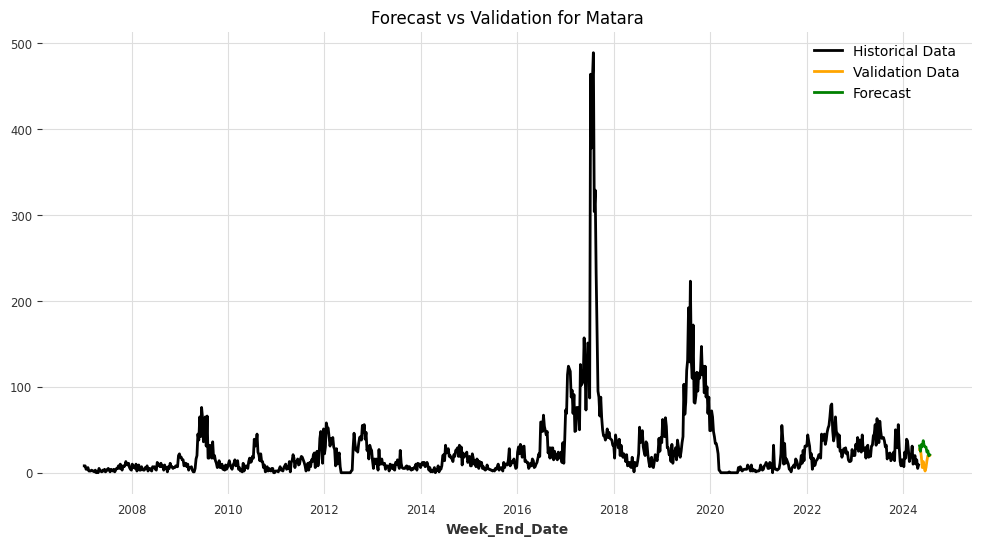

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Matara: /kaggle/working/Matara_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

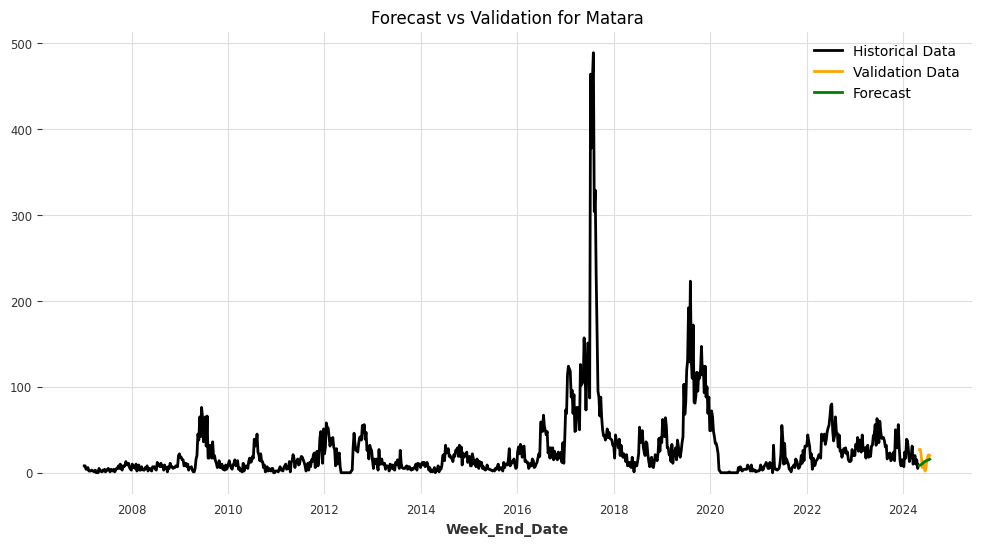

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Matara: /kaggle/working/Matara_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

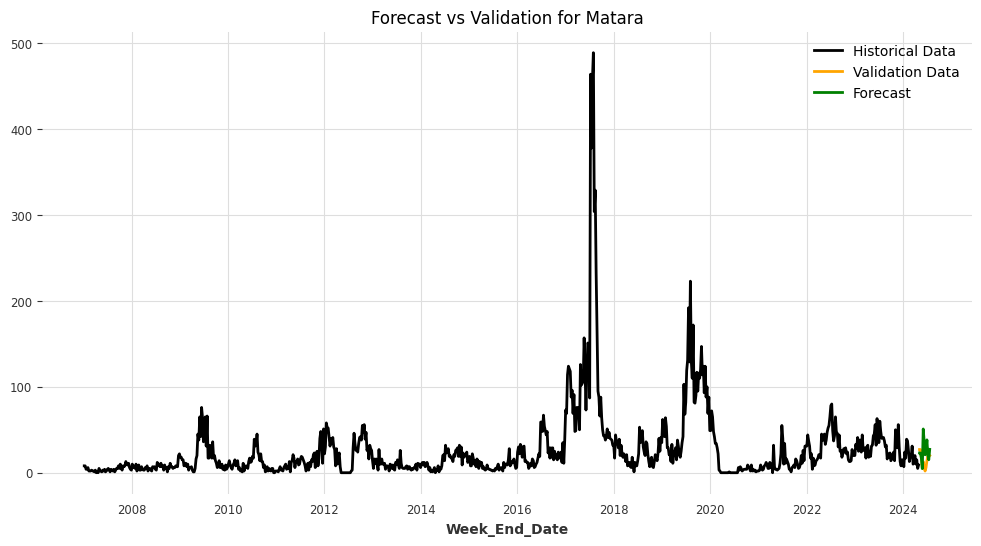

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Matara: /kaggle/working/Matara_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

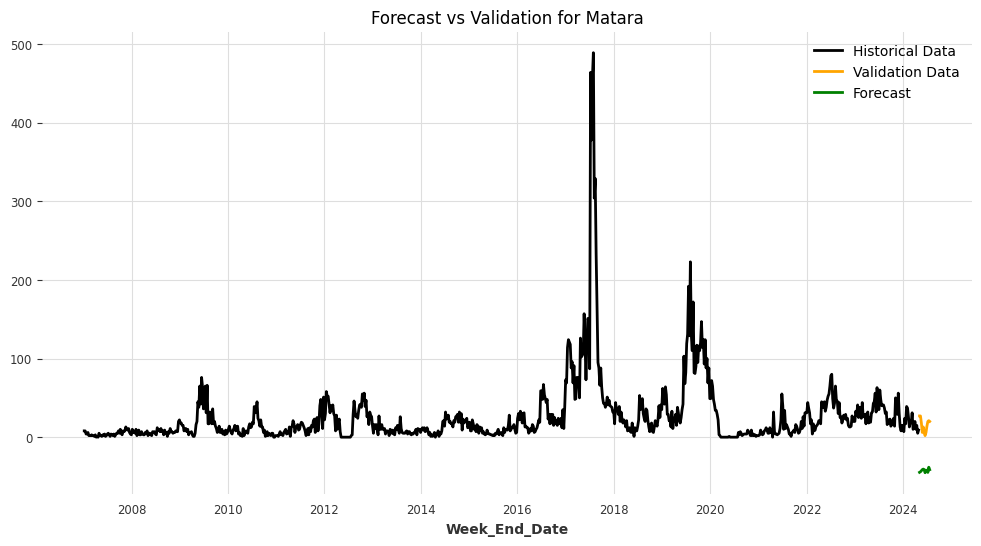

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Monaragala: /kaggle/working/Monaragala_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

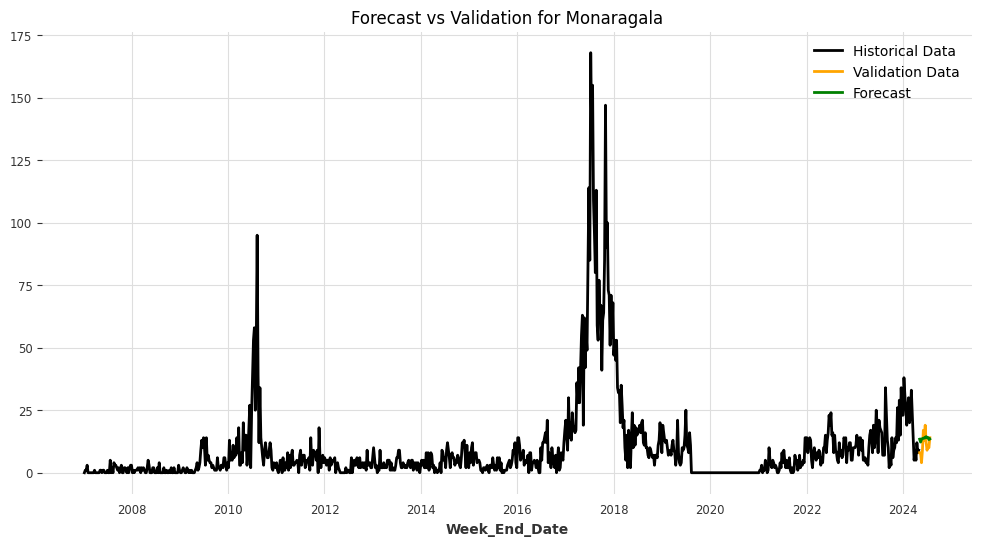

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Monaragala: /kaggle/working/Monaragala_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

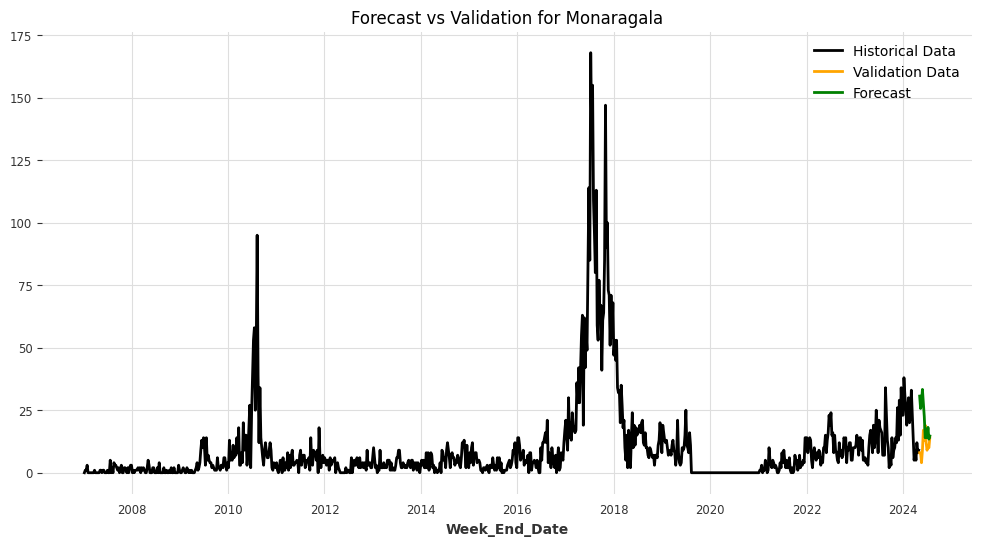

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Monaragala: /kaggle/working/Monaragala_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

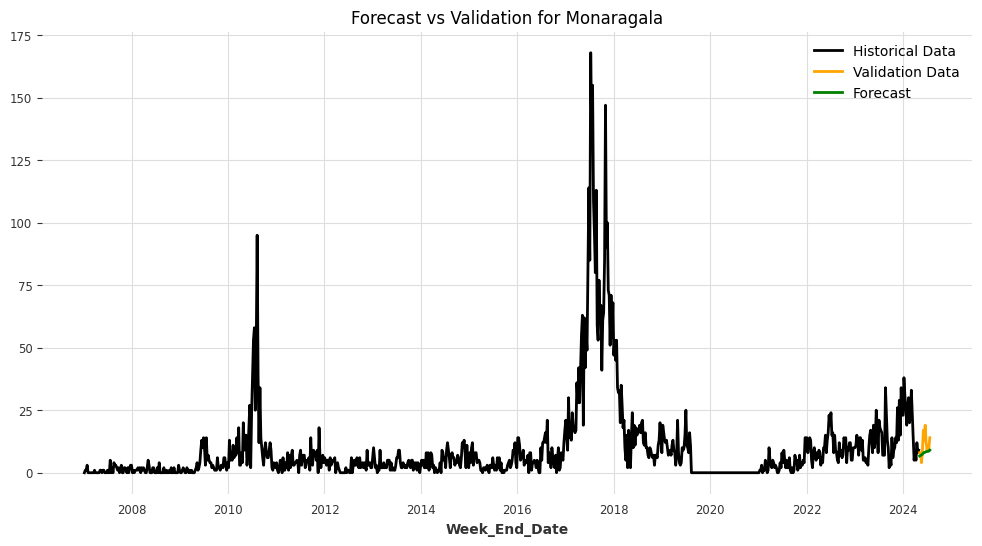

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Monaragala: /kaggle/working/Monaragala_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

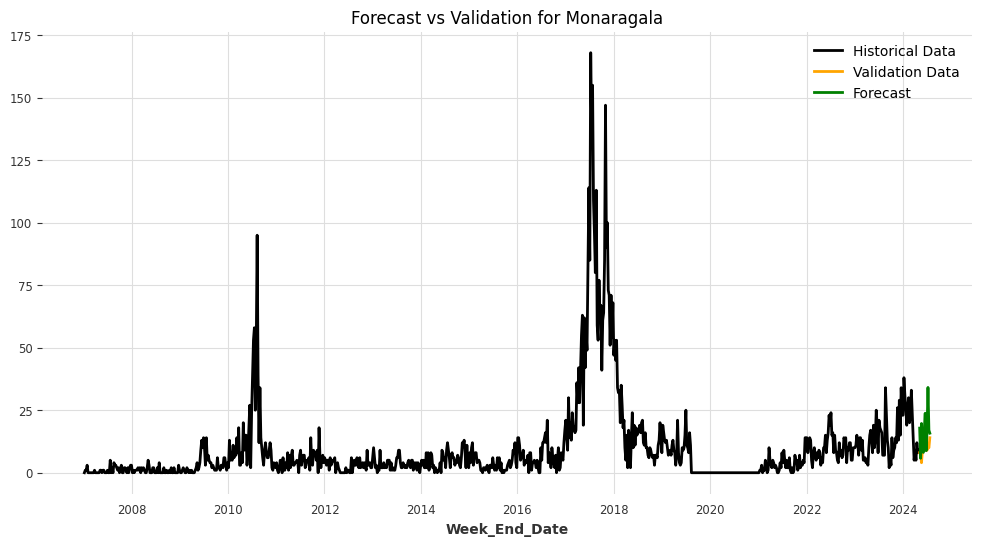

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Monaragala: /kaggle/working/Monaragala_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

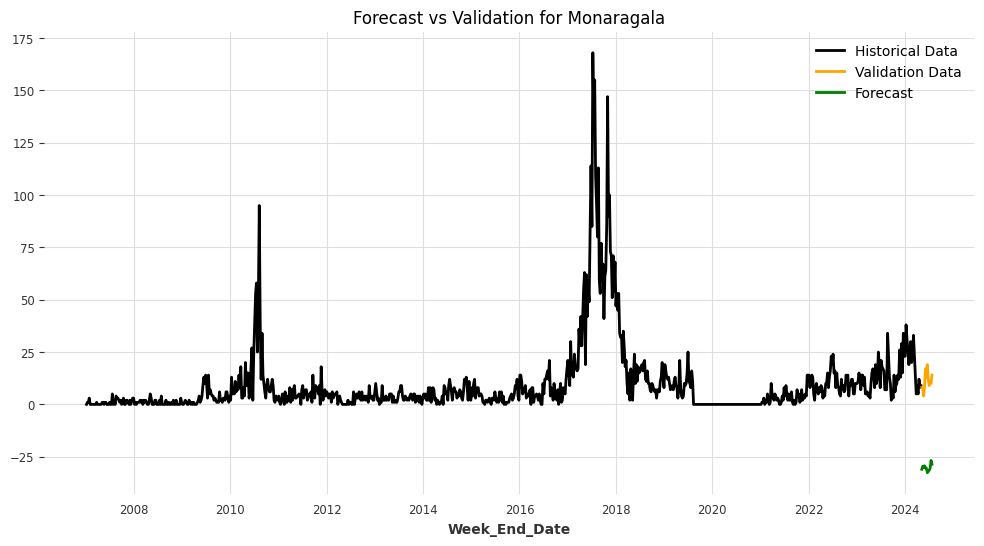

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Mullaitivu: /kaggle/working/Mullaitivu_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

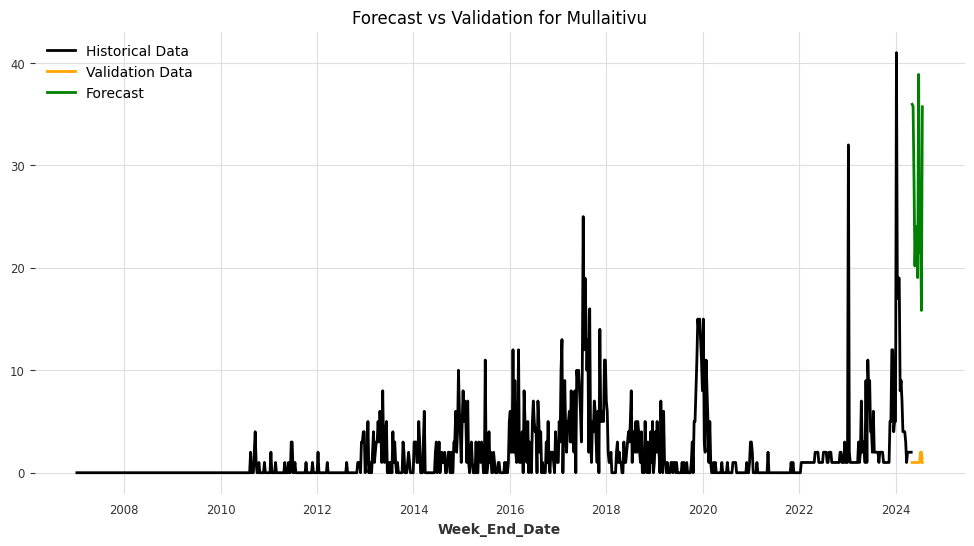

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Mullaitivu: /kaggle/working/Mullaitivu_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

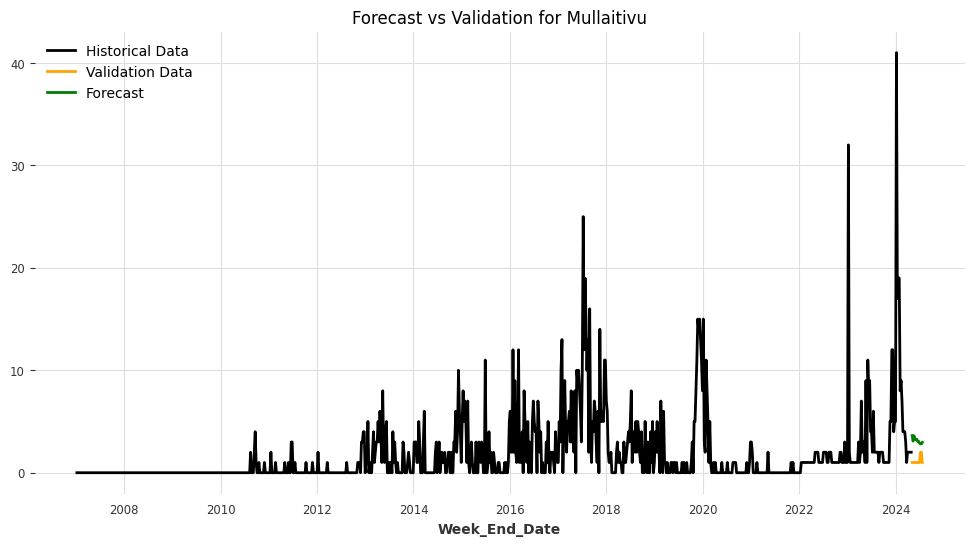

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Mullaitivu: /kaggle/working/Mullaitivu_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

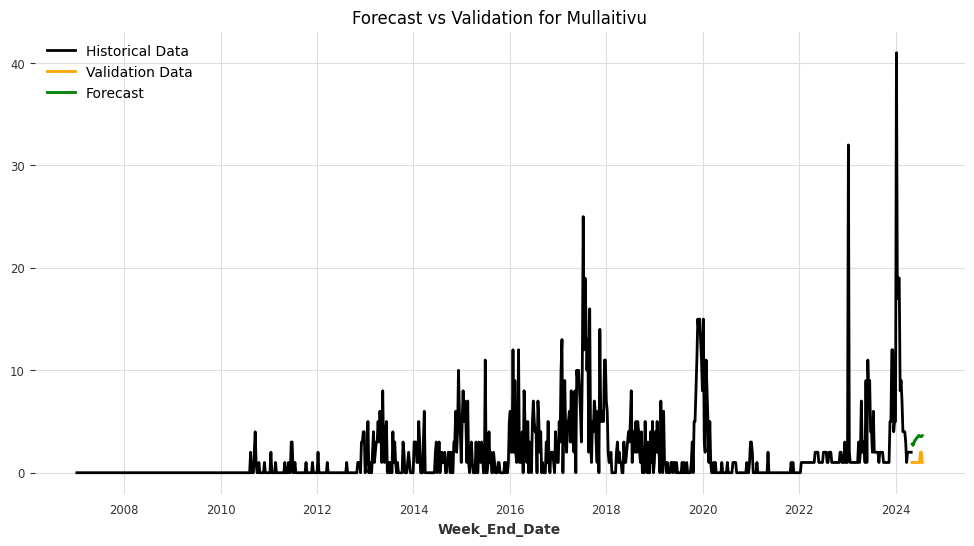

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Mullaitivu: /kaggle/working/Mullaitivu_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

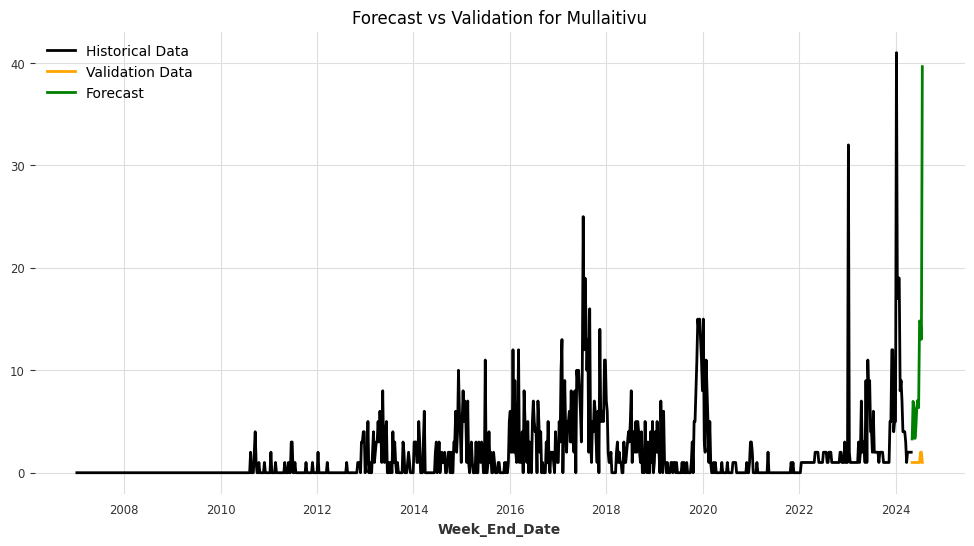

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Mullaitivu: /kaggle/working/Mullaitivu_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

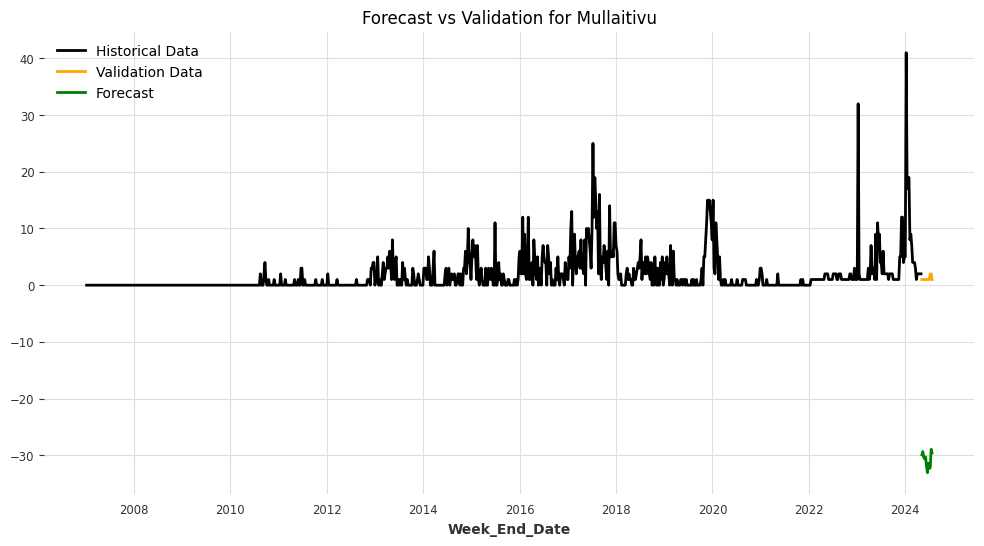

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/NuwaraEliya: /kaggle/working/NuwaraEliya_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

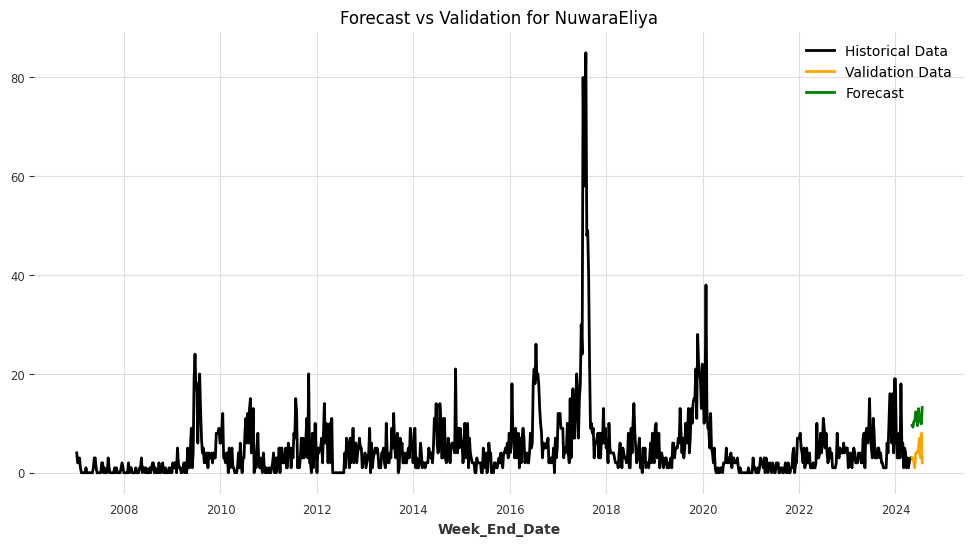

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/NuwaraEliya: /kaggle/working/NuwaraEliya_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

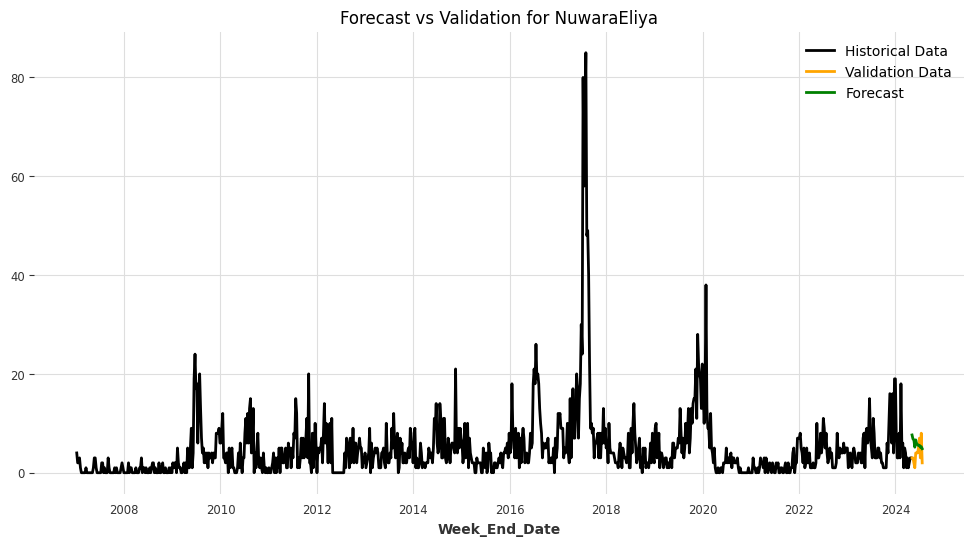

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/NuwaraEliya: /kaggle/working/NuwaraEliya_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

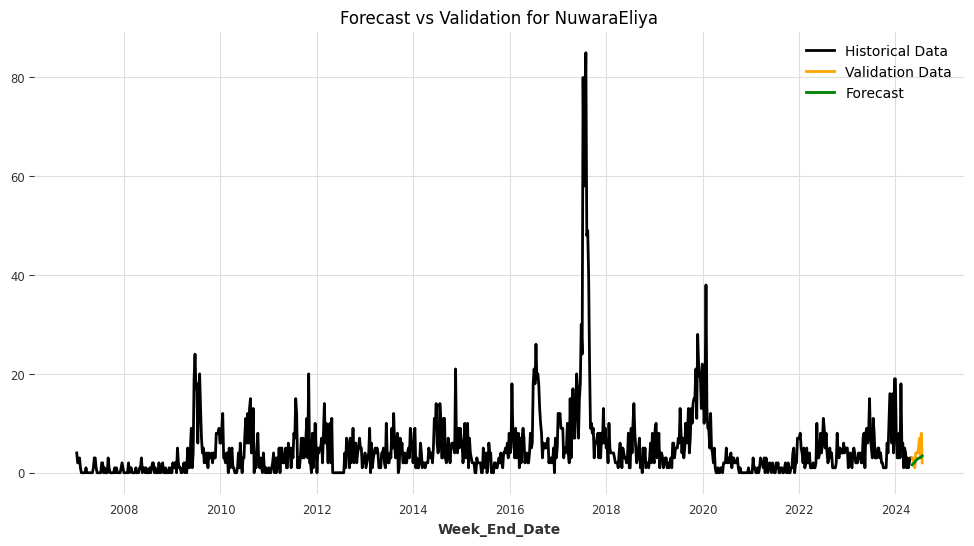

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/NuwaraEliya: /kaggle/working/NuwaraEliya_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

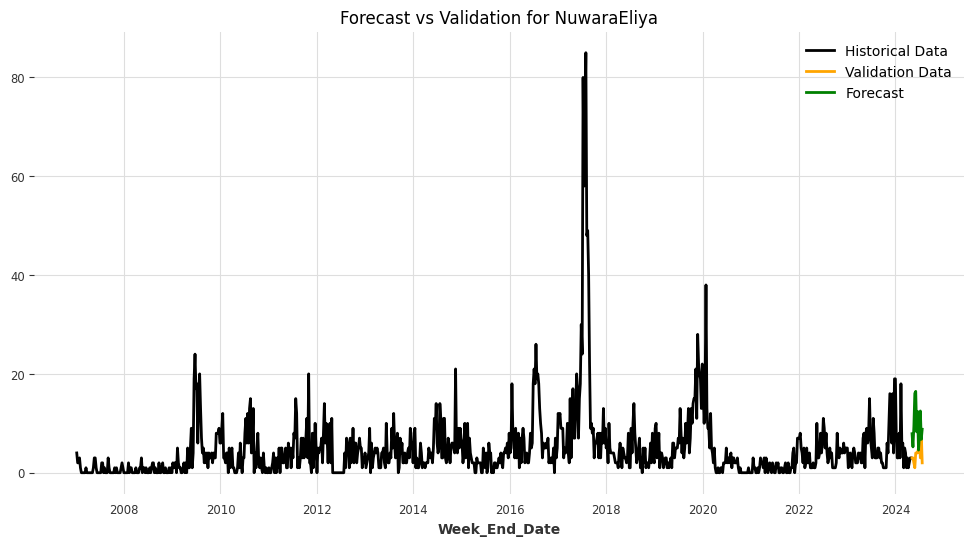

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/NuwaraEliya: /kaggle/working/NuwaraEliya_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

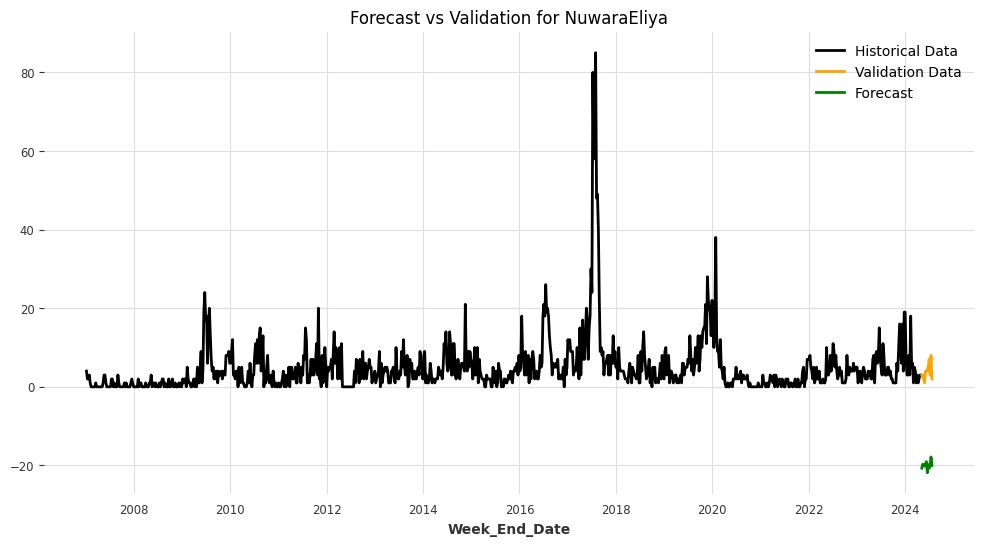

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Polonnaruwa: /kaggle/working/Polonnaruwa_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

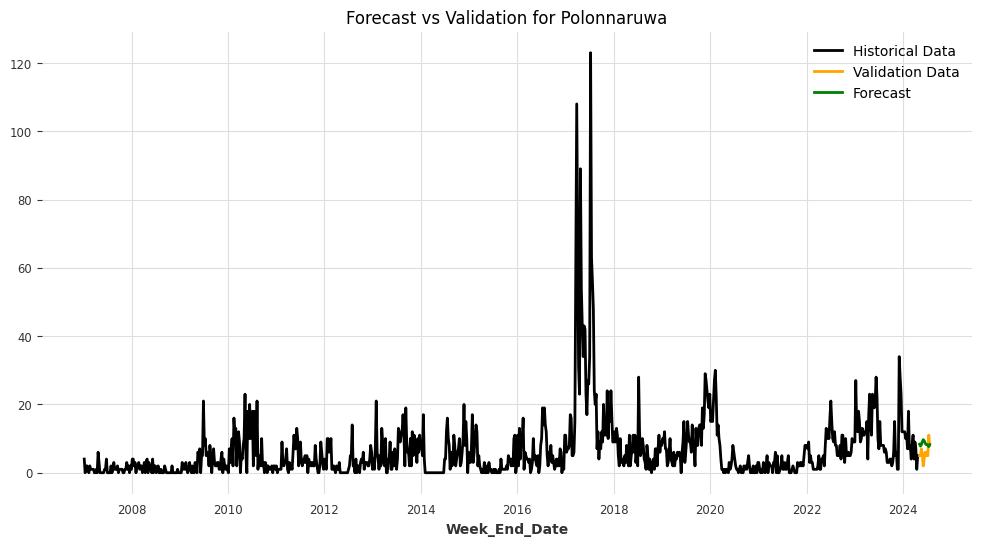

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Polonnaruwa: /kaggle/working/Polonnaruwa_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

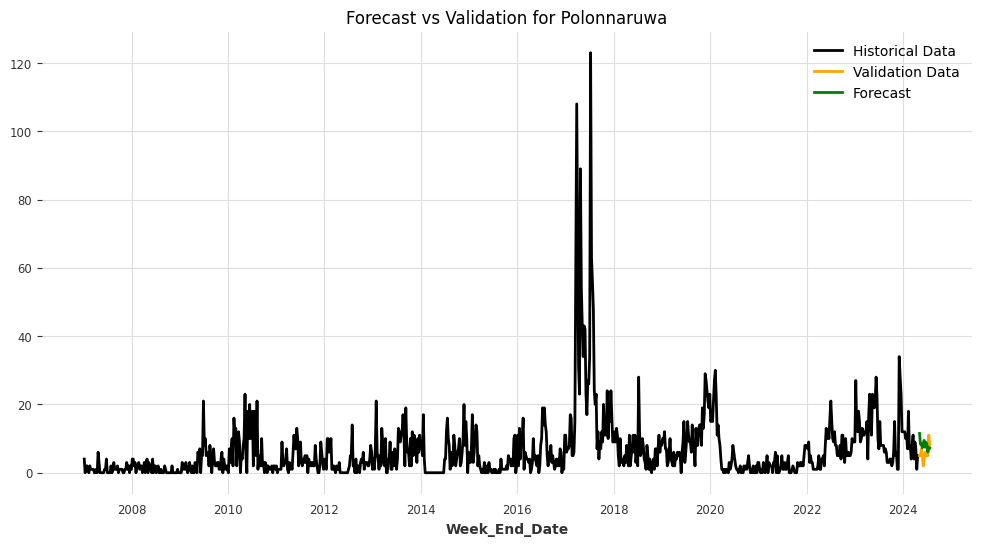

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Polonnaruwa: /kaggle/working/Polonnaruwa_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

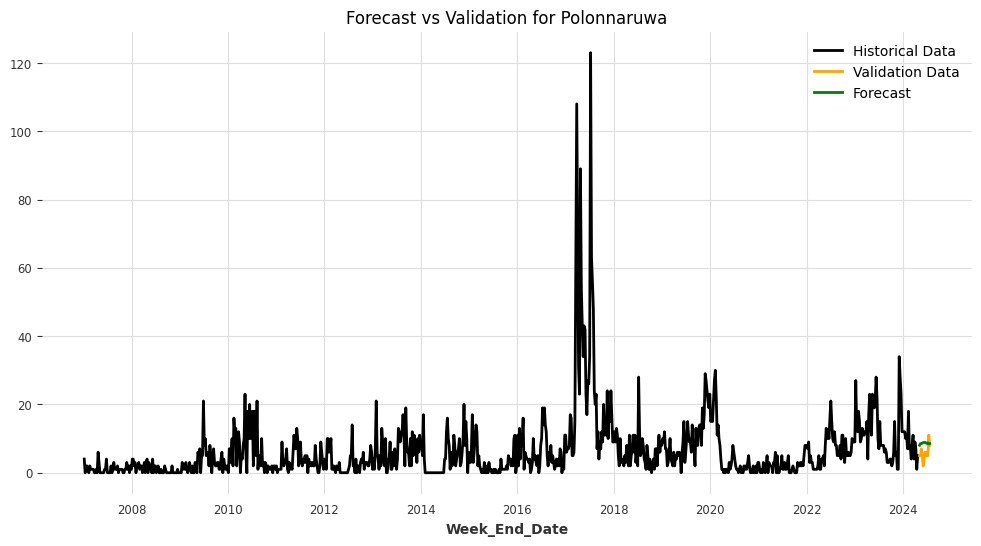

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Polonnaruwa: /kaggle/working/Polonnaruwa_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

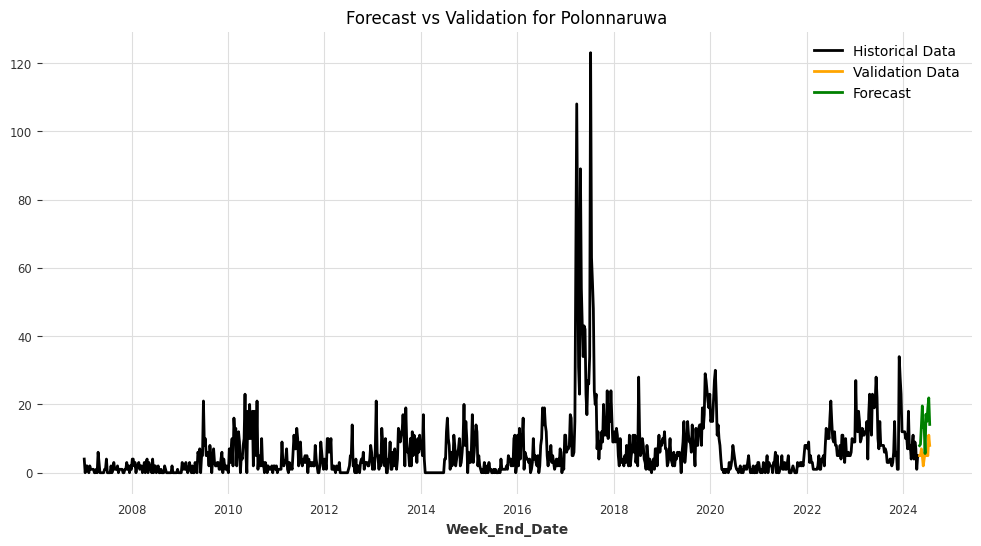

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Polonnaruwa: /kaggle/working/Polonnaruwa_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

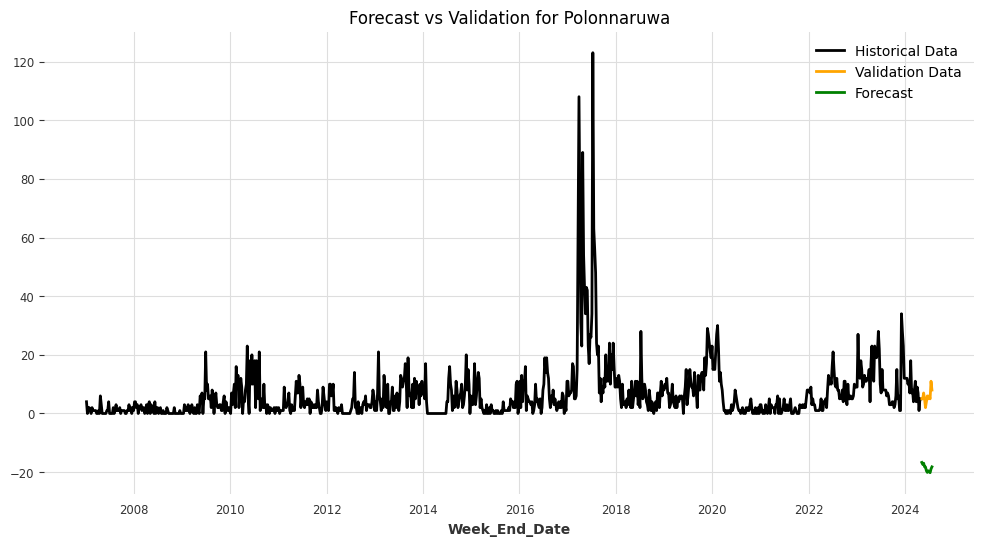

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Puttalam: /kaggle/working/Puttalam_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

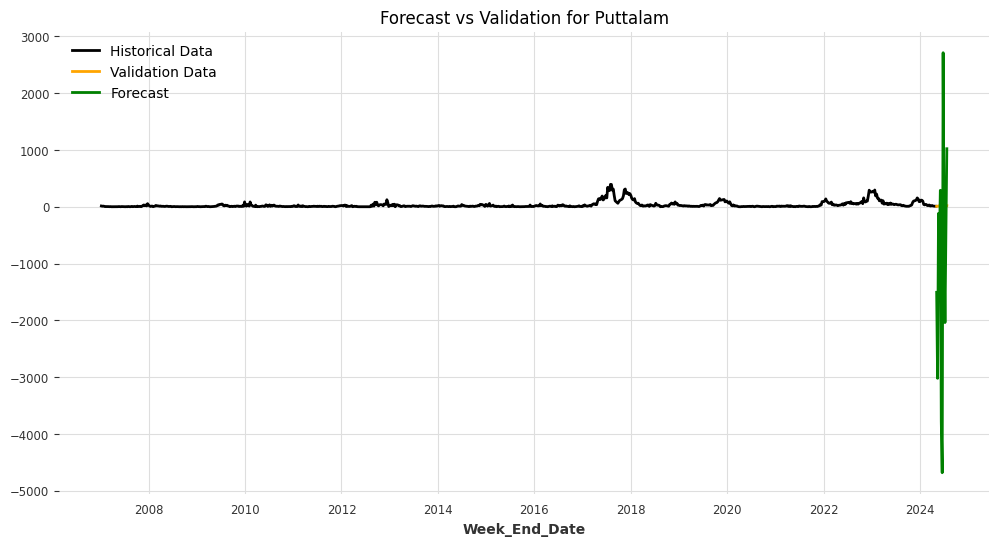

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Puttalam: /kaggle/working/Puttalam_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

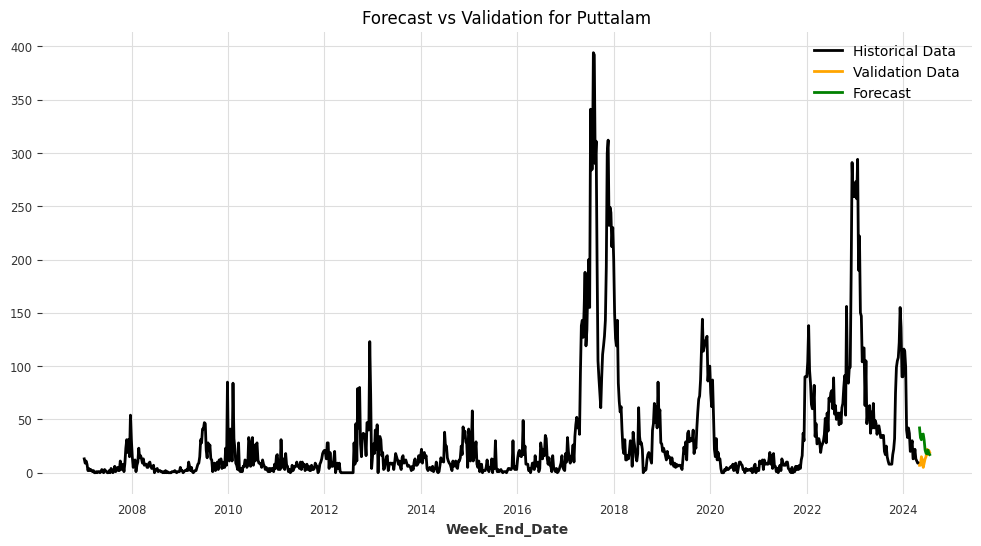

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Puttalam: /kaggle/working/Puttalam_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

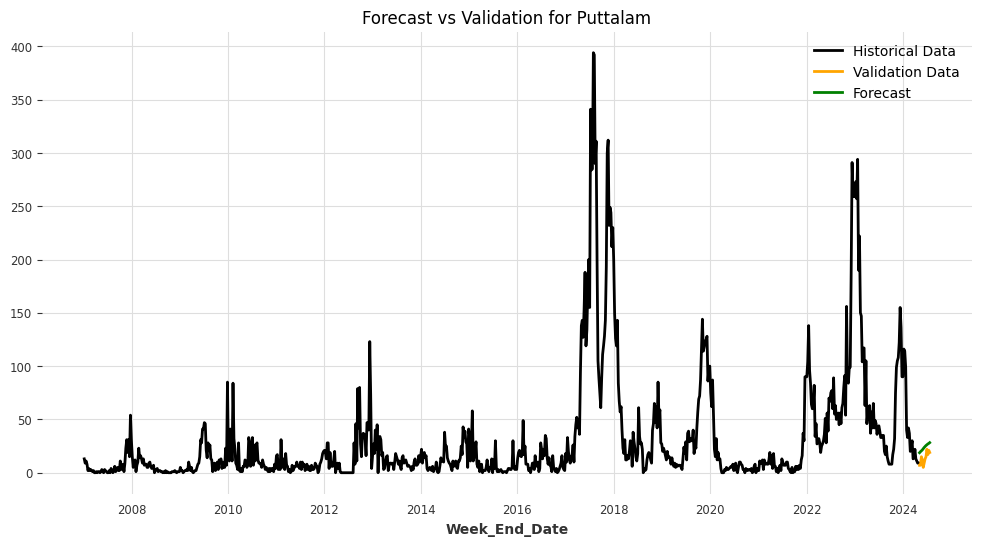

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Puttalam: /kaggle/working/Puttalam_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

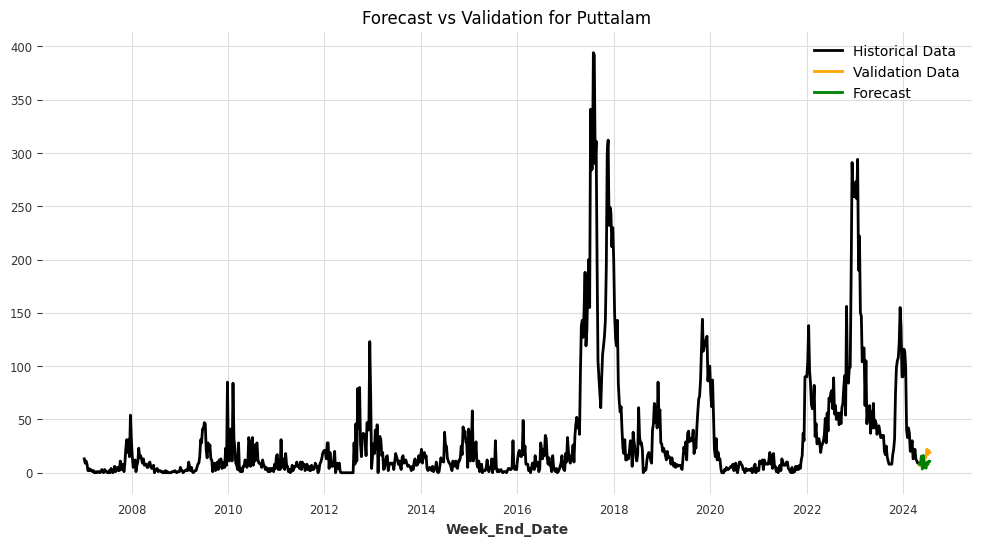

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Puttalam: /kaggle/working/Puttalam_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

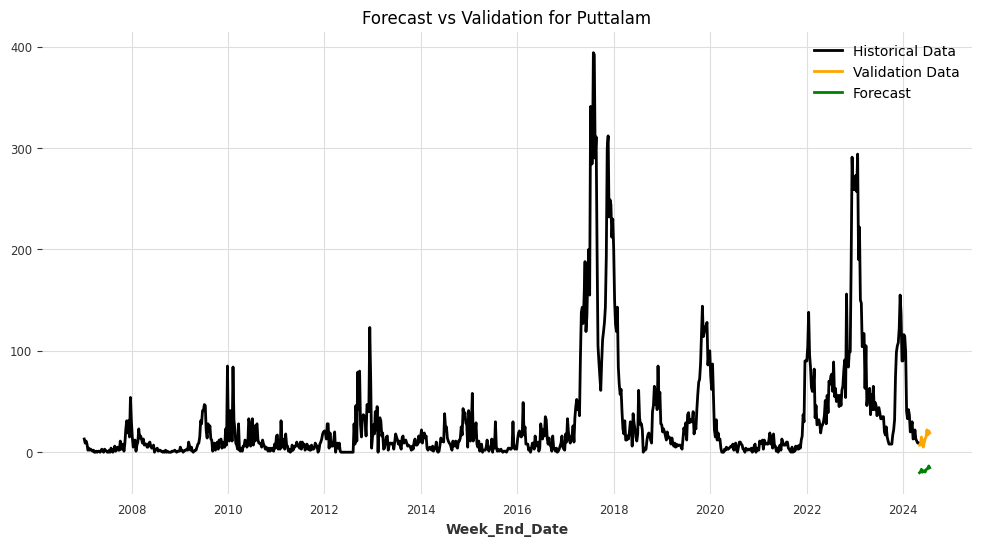

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Ratnapura: /kaggle/working/Ratnapura_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

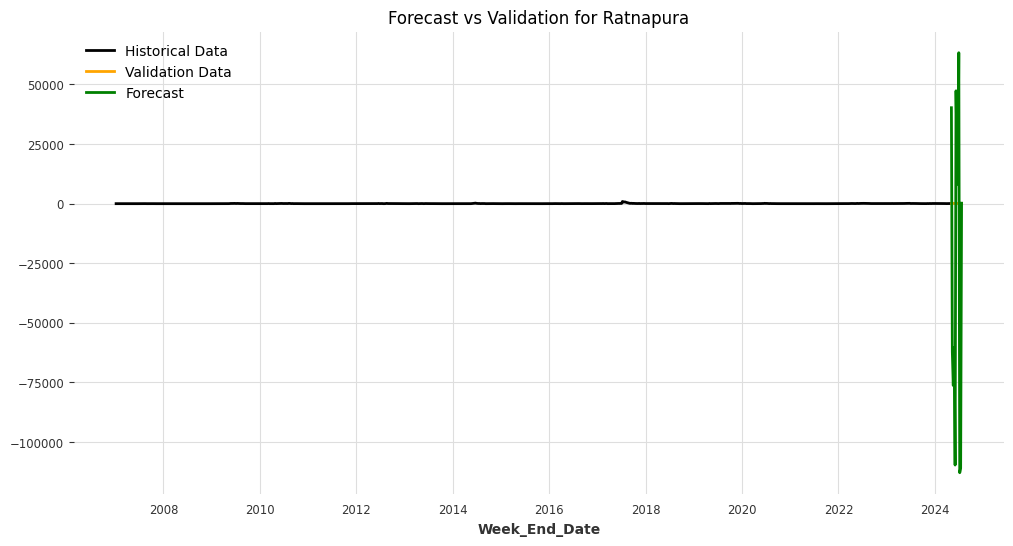

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Ratnapura: /kaggle/working/Ratnapura_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

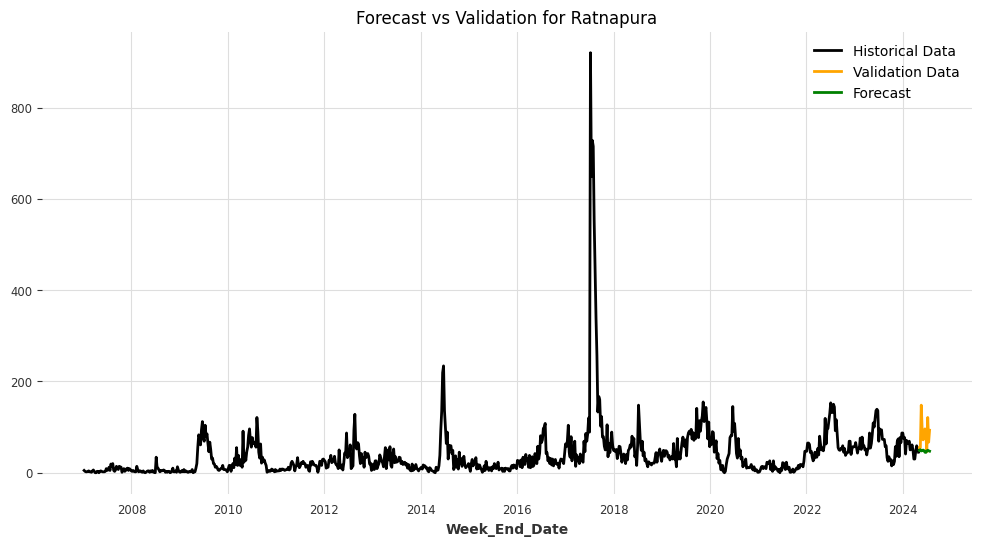

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Ratnapura: /kaggle/working/Ratnapura_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

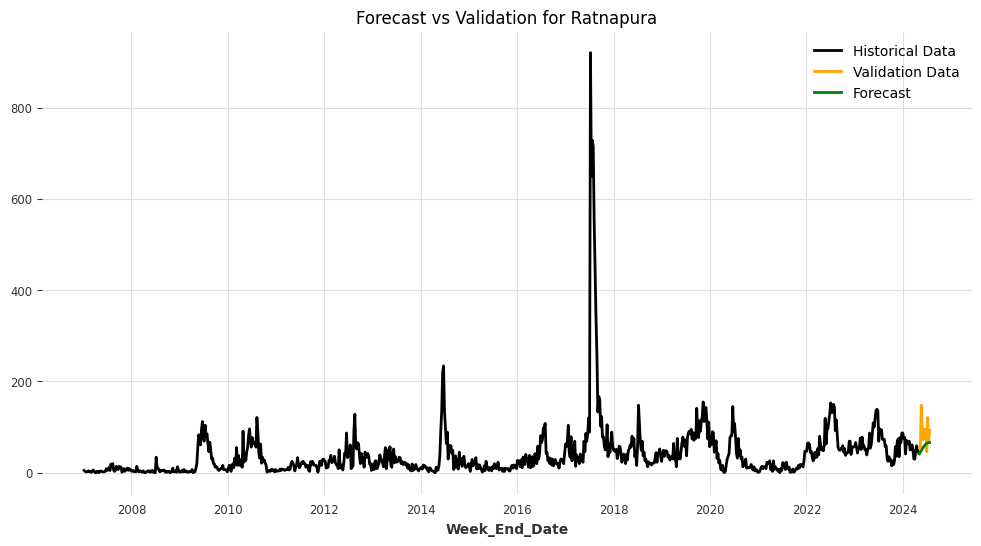

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Ratnapura: /kaggle/working/Ratnapura_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

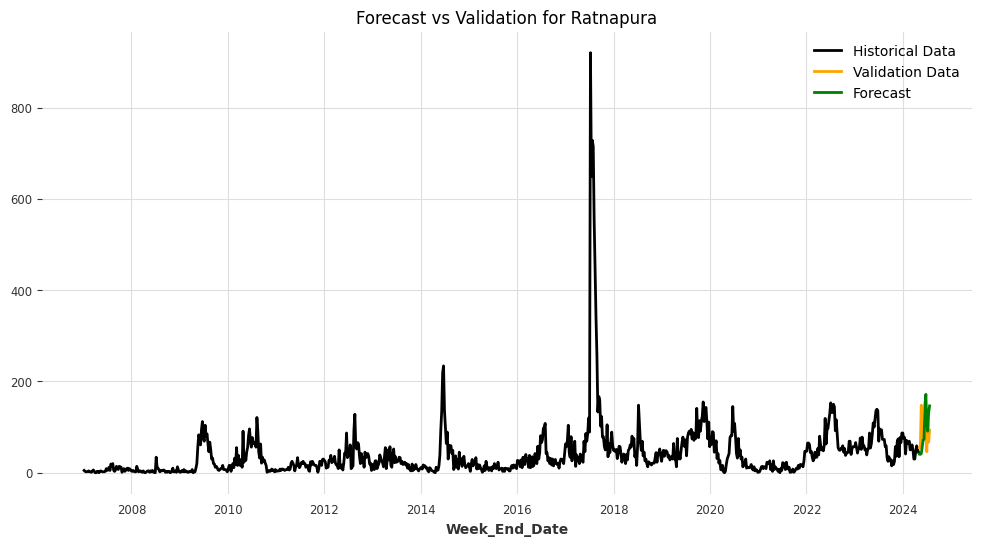

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Ratnapura: /kaggle/working/Ratnapura_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

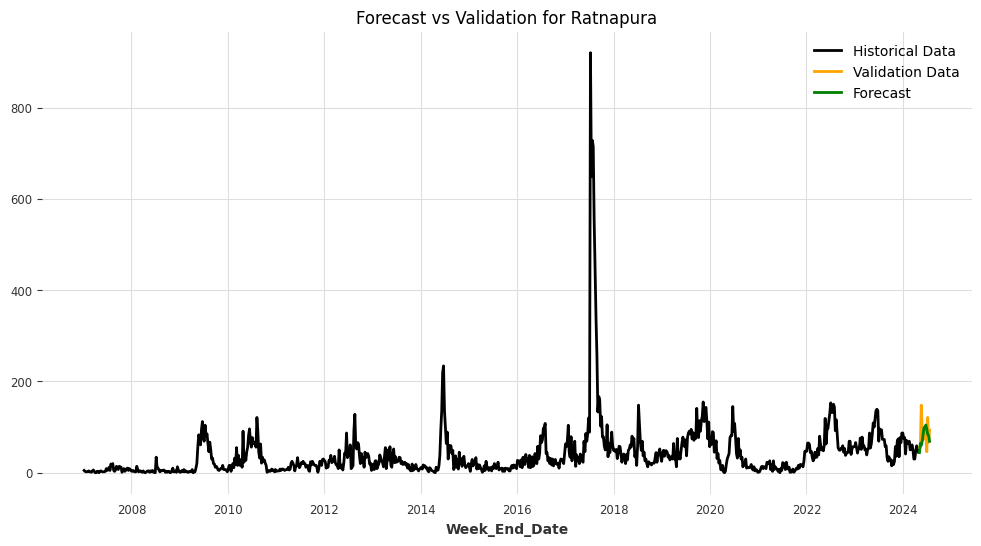

Training length: 904
Validation length: 12


/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Trincomalee: /kaggle/working/Trincomalee_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

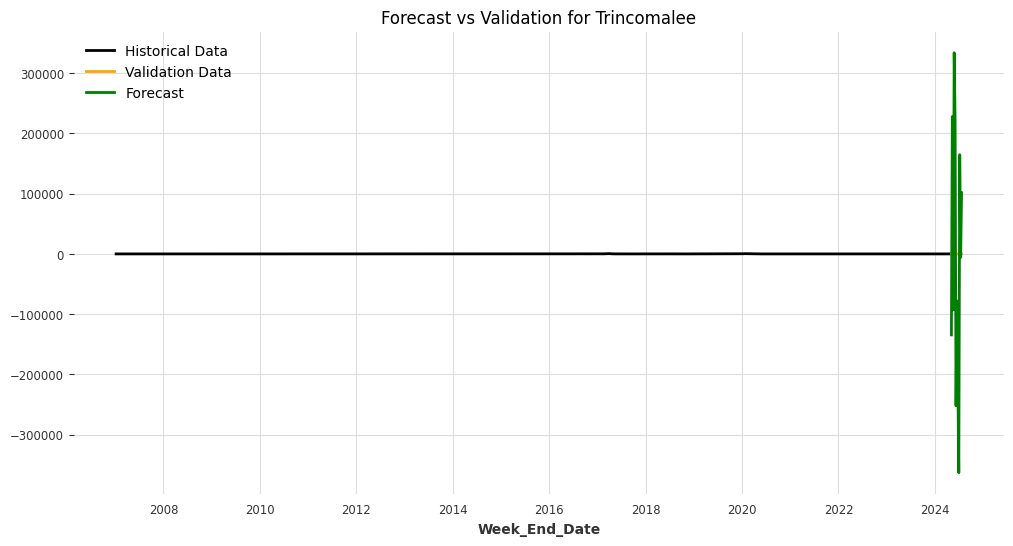

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Trincomalee: /kaggle/working/Trincomalee_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

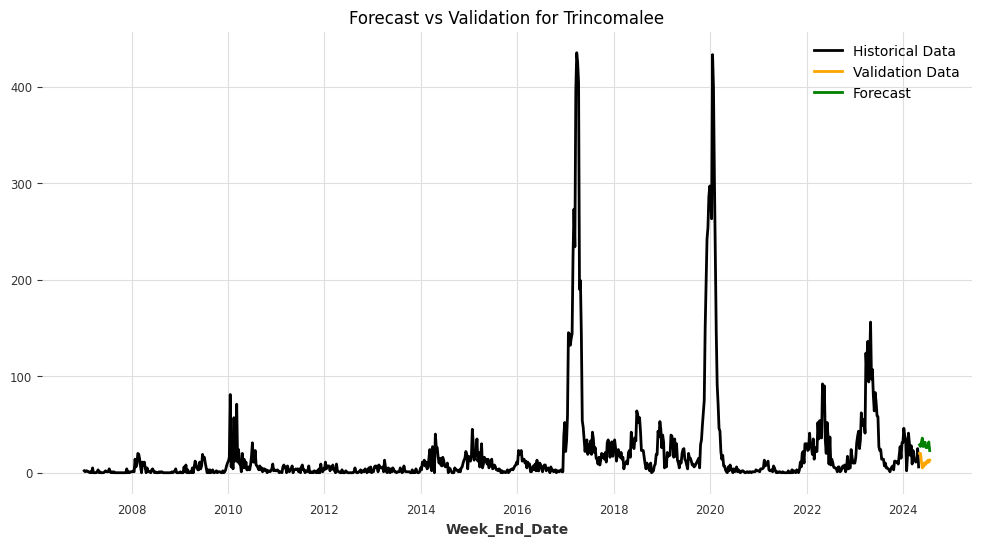

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Trincomalee: /kaggle/working/Trincomalee_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

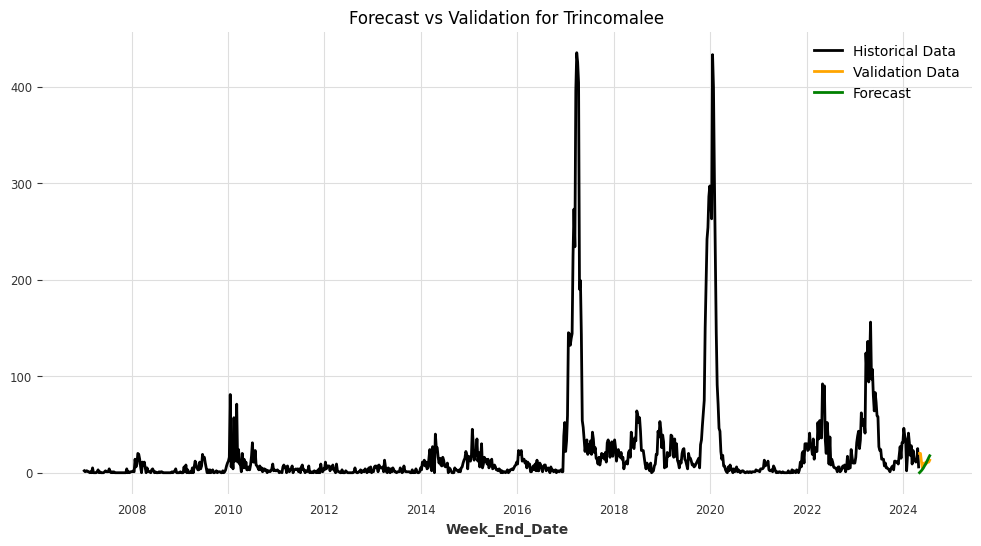

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Trincomalee: /kaggle/working/Trincomalee_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

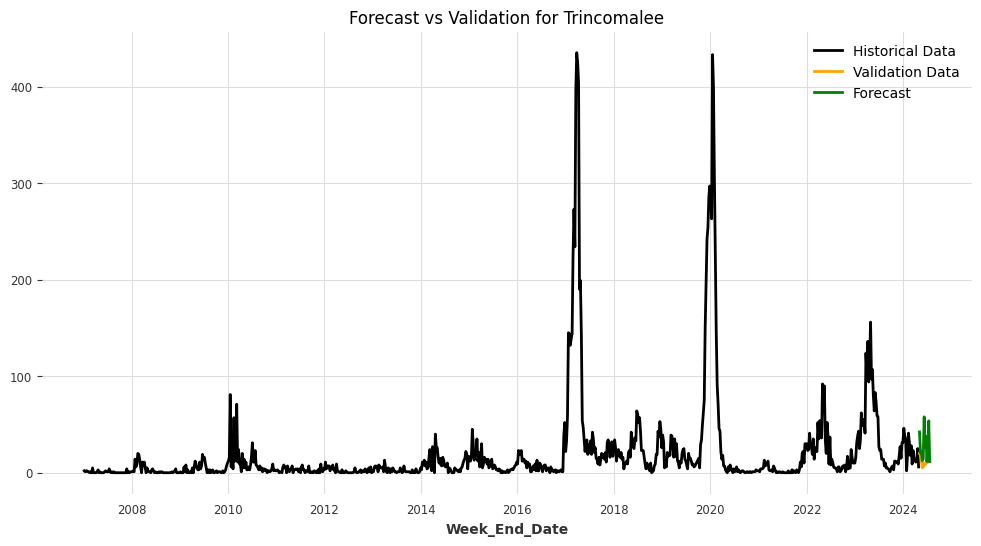

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Trincomalee: /kaggle/working/Trincomalee_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

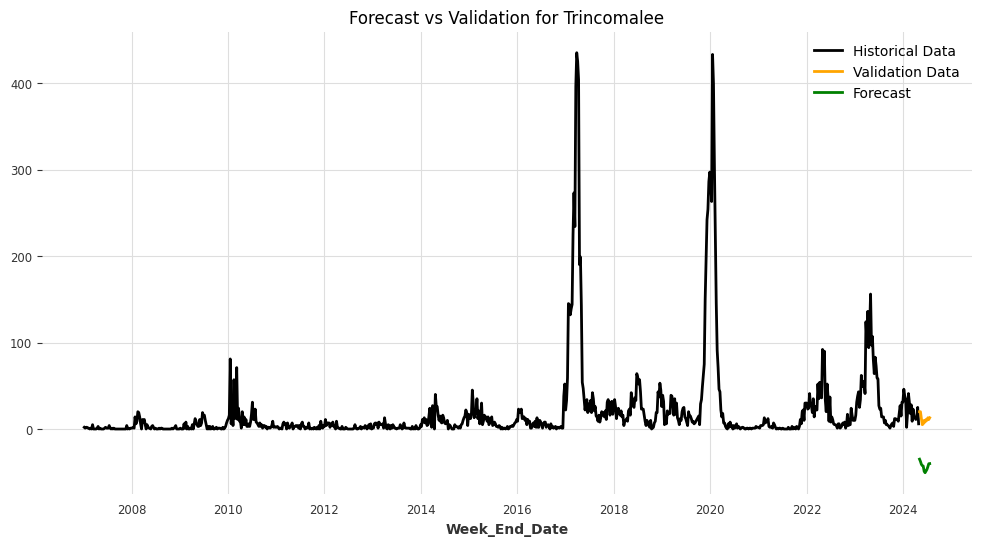

Training length: 904
Validation length: 12


/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice

/tmp/ipykernel_36/1255089486.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Vavuniya: /kaggle/working/Vavuniya_NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

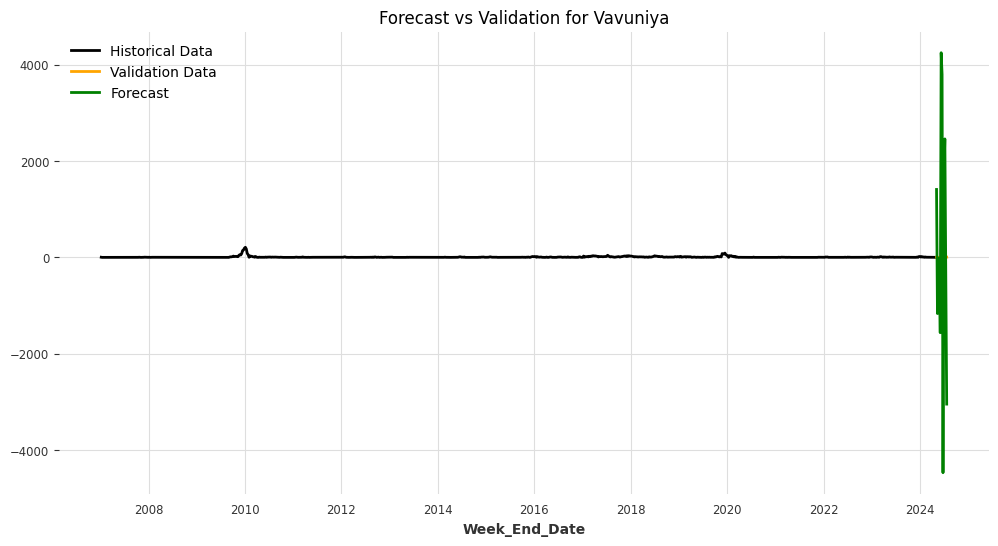

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Vavuniya: /kaggle/working/Vavuniya_TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

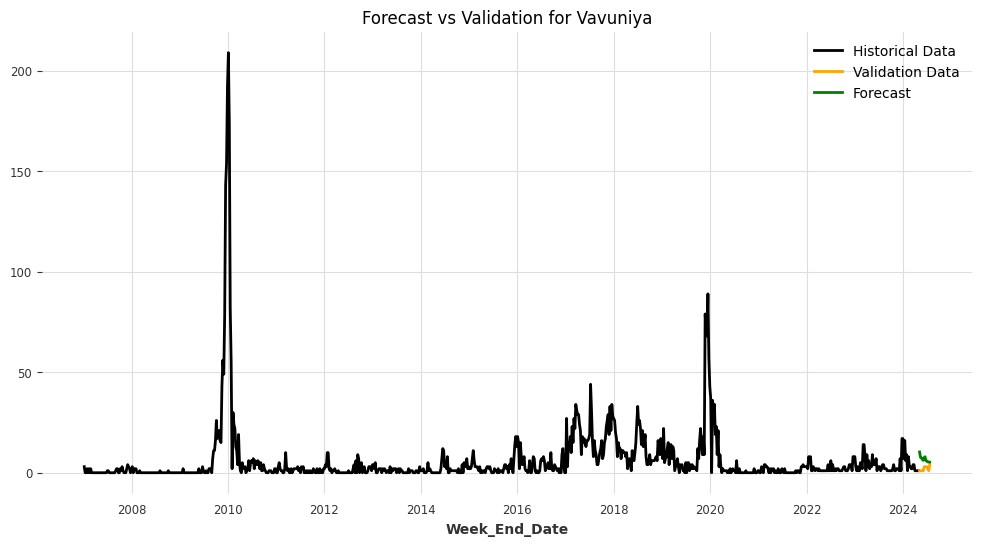

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Vavuniya: /kaggle/working/Vavuniya_TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

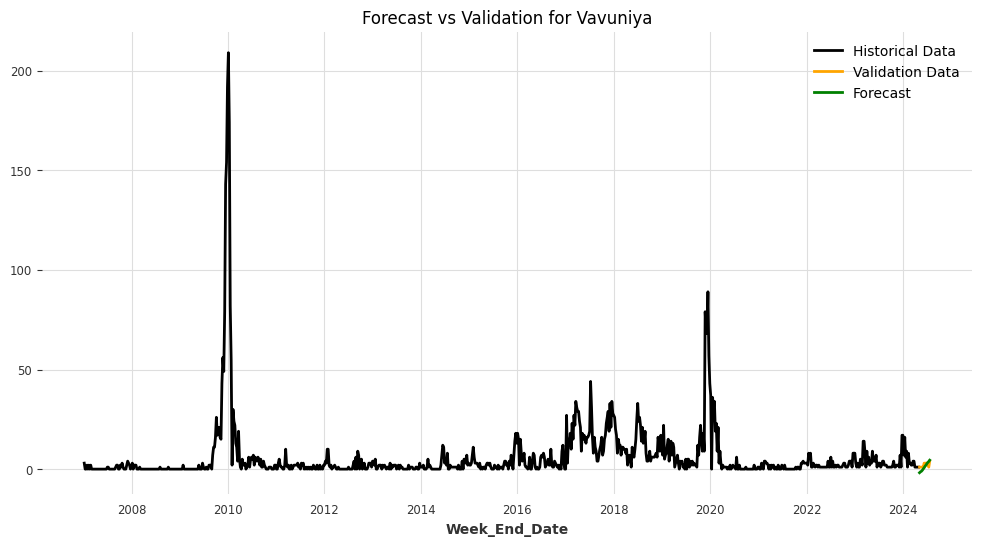

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log



Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Vavuniya: /kaggle/working/Vavuniya_TFTModel


Predicting: |          | 0/? [00:00<?, ?it/s]

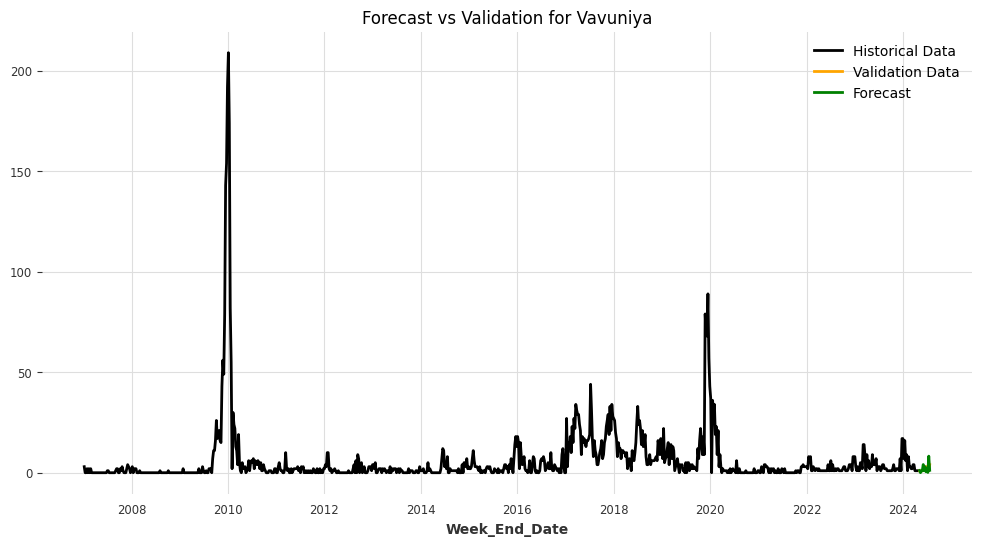

Training: |          | 0/? [00:00<?, ?it/s]

Model saved for /kaggle/working/Vavuniya: /kaggle/working/Vavuniya_TSMixerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

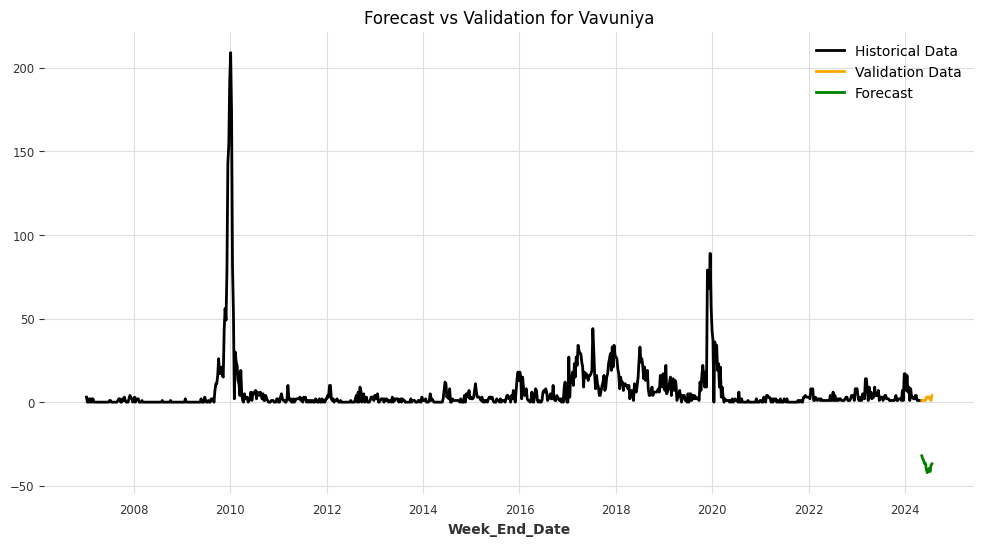

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1647: RuntimeWarning:

invalid value encountered in log

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:1720: RuntimeWarning:

Mean of empty slice

/opt/conda/lib/python3.10/site-packages/darts/metrics/metrics.py:244: RuntimeWarning:

Mean of empty slice



In [20]:
results = main(df, models)

## 6. Result

In [21]:
# Initialize a list to store metrics
metrics_list = []
districts = df['District'].unique()

# Iterate over results and extract metrics
for district_index, district_results in enumerate(results):
    for model_index, (forecast, metrics) in enumerate(district_results):
        metrics_list.append({
            'District': f'{districts[district_index]}',
            'Model': models[model_index],
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'SMAPE': metrics['SMAPE'],
            'R2': metrics['R2'],
            'RMSLE': metrics['RMSLE']
        })

# Create a DataFrame from the metrics list
df_metrics = pd.DataFrame(metrics_list)
df_metrics.set_index(['District', 'Model'], inplace=True)

In [22]:
from IPython.display import display
from IPython.display import HTML

def display_district_metrics(df_metrics):
    districts = df_metrics.index.get_level_values('District').unique()

    for district in districts:
        print(f"Metrics for {district}:")
        district_df = df_metrics.loc[district]
        styled_df = district_df.style \
         .highlight_min(color="lightgreen", axis=0)

        display(styled_df)

# Example usage
display_district_metrics(df_metrics)


Metrics for Ampara:


Metrics for Anuradhapura:


Metrics for Badulla:


Metrics for Batticaloa:


Metrics for Colombo:


Metrics for Galle:


Metrics for Gampaha:


Metrics for Hambantota:


Metrics for Jaffna:


Metrics for Kalutara:


Metrics for Kandy:


Metrics for Kegalle:


Metrics for Kilinochchi:


Metrics for Kurunegala:


Metrics for Mannar:


Metrics for Matale:


Metrics for Matara:


Metrics for Monaragala:


Metrics for Mullaitivu:


Metrics for NuwaraEliya:


Metrics for Polonnaruwa:


Metrics for Puttalam:


Metrics for Ratnapura:


Metrics for Trincomalee:


Metrics for Vavuniya:


## 7. Conclusion
To assess each models we need to see the error metrics of each model and then we have to decide which model outperformed.

Note: `We also need to do backtesting to make sure model is performing as intended`